<a href="https://colab.research.google.com/github/ghiathnj/impacket/blob/master/21_10_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from matplotlib import pyplot
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#np.random.seed(42)
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sn 
from math import ceil
import calendar
from google.colab import drive
#connect
drive.mount('/content/drive')
Energy_df = pd.read_csv('/content/drive/MyDrive/Masterarbeit/data_2019_run12.csv')
#import and resample
Energy_df["time"] = (pd.to_datetime(Energy_df['time']).add(pd.to_timedelta(Energy_df.time, unit='s')).dt.strftime('2019/%m/%d %H:%M:%S'))
Energy_df['time'] = pd.to_datetime(Energy_df['time'])
Energy_resampled = Energy_df.set_index('time').resample('15T').sum()
dftest= Energy_resampled
dftest=dftest.reset_index()
#edit the display
pd.set_option('display.float_format', lambda x: '%.1f' % x)
#drope Unnamed column (unusful)
dftest = dftest.drop(['Unnamed: 0'], axis = 1)



Mounted at /content/drive


In [2]:
#Feature Engineering(new one)
##Moving average
dftest['MA12'] = dftest['d_abs'].rolling(window=12).mean() 
dftest['MA20'] = dftest['d_abs'].rolling(window=20).mean() 
dftest['MA26'] = dftest['d_abs'].rolling(window=26).mean() 
dftest['MA100'] = dftest['d_abs'].rolling(window=100).mean()
dftest['MA200'] = dftest['d_abs'].rolling(window=200).mean()
##Moving Averages on std - different periods
dftest['MA20dSTD'] = dftest['d_abs'].rolling(window=20).std() 
## Exponential Moving Averages (EMAS) - different periods
dftest['EMA12'] = dftest['d_abs'].ewm(span=12, adjust=False).mean()
dftest['EMA20'] = dftest['d_abs'].ewm(span=20, adjust=False).mean()
dftest['EMA26'] = dftest['d_abs'].ewm(span=26, adjust=False).mean()
dftest['EMA100'] = dftest['d_abs'].ewm(span=100, adjust=False).mean()
dftest['EMA200'] = dftest['d_abs'].ewm(span=200, adjust=False).mean()
# Bollinger Bands
dftest['Bollinger_Upper'] = dftest['MA20'] + (dftest['MA20dSTD'] * 2)
dftest['Bollinger_Lower'] = dftest['MA20'] - (dftest['MA20dSTD'] * 2)
# Moving Average Convergence/Divergence (MACD)
dftest['MACD'] = dftest['EMA12'] - dftest['EMA26']
##SMA
dftest['DIFF-MA20-MA12'] = dftest['MA20'] - dftest['MA12']
dftest['DIFF-MA200-MA100'] = dftest['MA200'] - dftest['MA100']
dftest['DIFF-MA200-d_abs'] = dftest['MA200'] - dftest['d_abs']
dftest['DIFF-MA100-d_abs'] = dftest['MA100'] - dftest['d_abs']
dftest['DIFF-MA20-d_abs'] = dftest['MA20'] - dftest['d_abs']
##lags features
dftest['t-1'] = dftest['d_abs'].shift(1)
dftest['t-2'] = dftest['d_abs'].shift(2)
dftest['t-3'] = dftest['d_abs'].shift(3)
dftest['t-4'] = dftest['d_abs'].shift(4)
dftest['t-5'] = dftest['d_abs'].shift(5)
# Replace nas 
nareplace = dftest.at[dftest.index.max(), 'd_abs']    
dftest.fillna((nareplace), inplace=True)
#########dftest=dftest.dropna( axis=0, how="any", thresh=None, subset=None, inplace=False)
#Feature engnineering (old)
def get_season(month):

    if month =='September' or month =='October' or month =='November':
      Season= 'Autumn'
    elif month =='December' or month == 'January' or month =='February':
      Season= 'Winter'
    elif month =='March' or month =='April' or month =='May':
      Season= 'Spring'
    else:
      Season = 'Summer'

    return Season

dftest['Dates'] = pd.to_datetime(dftest['time']).dt.date
#dftest['TimeInHMS'] = pd.to_datetime(dftest['time']).dt.time
dftest['Hour']= pd.to_datetime(dftest['time']).dt.hour
dftest['minute']= pd.to_datetime(dftest['time']).dt.minute
#dftest['second']= pd.to_datetime(dftest['time']).dt.second
dftest['Day'] = pd.to_datetime(dftest['time']).dt.day_name()
dftest['DayOfYear'] = pd.to_datetime(dftest['time']).dt.dayofyear
dftest['Month'] = pd.to_datetime(dftest['time']).dt.month_name()
dftest['MonthInNum'] = pd.to_datetime(dftest['time']).dt.month
dftest['Quarter'] = pd.to_datetime(dftest['time']).dt.quarter
#dftest['Year'] = pd.to_datetime(dftest['time']).dt.year
dftest['Weekday'] = pd.to_datetime(dftest['time']).dt.weekday
dftest['DaysOfMonth'] = pd.to_datetime(dftest['time']).dt.day
#dftest['WeekOfMonth'] = week_of_month(dftest['time'])
#The weekday() function of date class in datetime module, returns an integer between 0(monday) and 6(sunday)
dftest['Seasons'] = dftest['Month'].apply(lambda x: get_season(x))
dftest['Weekend'] = dftest['Weekday'].apply(lambda x: x>=5).astype('int')
dftest['WeekOfYear'] = pd.to_datetime(dftest['time']).dt.week
dftest['Holiday'] = pd.to_datetime(dftest['time']).dt.date.apply(lambda x: holidays.CountryHoliday('DE',prov='BW').get(x)).values.astype('bool').astype('int')
dftest['DayAheadWeekend'] = dftest['Weekday'].apply(lambda x: x==4).astype('int')
dftest['DayAfterWeekend'] = dftest['Weekday'].apply(lambda x: x==0).astype('int')
dftest['Early_Morning'] = dftest['Hour'].apply(lambda x:(x > 4) and (x <= 8) ).astype('int')
dftest['Morning'] = dftest['Hour'].apply(lambda x:(x > 8) and (x <= 12 ) ).astype('int')
dftest['Noon'] = dftest['Hour'].apply(lambda x:(x > 16) and (x <= 20) ).astype('int')
dftest['Night'] = dftest['Hour'].apply(lambda x:(x > 20) and (x <= 24)).astype('int')
dftest['Late Night'] = dftest['Hour'].apply(lambda x:(x <= 4)).astype('int')
dftest.head()




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


time        p_eh    p_target      d_abs      MA12      MA20  \
0 2019-01-01 00:00:00  12680917.7 -30000000.0 42680917.7 1806530.4 1806530.4   
1 2019-01-01 00:15:00  -2466045.5 -26841704.5 24375659.1 1806530.4 1806530.4   
2 2019-01-01 00:30:00 -14512871.8 -23682529.7  9169657.9 1806530.4 1806530.4   
3 2019-01-01 00:45:00 -14046240.6 -16904848.3  2858607.8 1806530.4 1806530.4   
4 2019-01-01 01:00:00 -14546252.9 -15274927.5   760411.1 1806530.4 1806530.4   

       MA26     MA100     MA200  MA20dSTD  ...  Weekend  WeekOfYear  Holiday  \
0 1806530.4 1806530.4 1806530.4 1806530.4  ...        0           1        1   
1 1806530.4 1806530.4 1806530.4 1806530.4  ...        0           1        1   
2 1806530.4 1806530.4 1806530.4 1806530.4  ...        0           1        1   
3 1806530.4 1806530.4 1806530.4 1806530.4  ...        0           1        1   
4 1806530.4 1806530.4 1806530.4 1806530.4  ...        0           1        1   

   DayAheadWeekend  DayAfterWeekend  Early_Morning  Morning  Noon  Night  \
0                0                0              0        0     0      0   
1                0                0              0        0     0      0   
2                0                0              0        0     0      0   
3                0                0              0        0     0      0   
4                0                0              0        0     0      0   

   Late Night  
0           1  
1           1  
2           1  
3           1  
4           1  

[5 rows x 49 columns]

In [3]:
'''import tsfel
import pandas as pd

# load dataset

output_directory = '/content/drive/MyDrive/Masterarbeit'
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()
Energy_df=Energy_df[:20000]
# Extract features
X = tsfel.time_series_features_extractor(cfg,Energy_df)
X'''

"import tsfel\nimport pandas as pd\n\n# load dataset\n\noutput_directory = '/content/drive/MyDrive/Masterarbeit'\n# Retrieves a pre-defined feature configuration file to extract all available features\ncfg = tsfel.get_features_by_domain()\nEnergy_df=Energy_df[:20000]\n# Extract features\nX = tsfel.time_series_features_extractor(cfg,Energy_df)\nX"

In [4]:
'''dftest[['d_abs', 'EMA200']].plot(label='d_abs',
                                  figsize=(16, 8))'''

"dftest[['d_abs', 'EMA200']].plot(label='d_abs',\n                                  figsize=(16, 8))"

In [5]:
'''from enum import auto
#dftestslice2=dftestslice2.reset_index()
#df_train=df_train.set_index('time')
#pred = model.fit(X_train,y_train).get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#pred_ci = pred.conf_int()
#dftest=dftest.set_index('time')
#dftest=dftest.reset_index()


for date, d in dftest.groupby(dftest['Dates']):
 # fig, ax = plt.subplots(1,1,figsize=(16,7),sharex=True)
  fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,7))

  #ax1 = d['p_target'].plot(legend=True)
  ax1 = d['d_abs'].plot(legend=True,color='red',linestyle = '-',label='d_abs')
  ax1 = d['p_target'].plot(color='blue',legend=True,style='-',label='target value')
  ax1 = d['p_eh'].plot(color='green',legend=True,style='-',label='Ist value')
  #ax1.set_xlabel(f",{d['Day']}")
  ax1.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  ax1.set_title('Actual and predicted absolute error',  fontsize=20)
  #ax1.set_xlabel(d['Day'])
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)


  ax1.legend(loc='upper right')
  #ax1.set_xlabel(d['Day'])
  plt.xlim=auto
  plt.ylim=auto
  ax1.xlim=auto
'''

'from enum import auto\n#dftestslice2=dftestslice2.reset_index()\n#df_train=df_train.set_index(\'time\')\n#pred = model.fit(X_train,y_train).get_prediction(start=pd.to_datetime(\'2019-01-01\'), dynamic=False)\n#pred_ci = pred.conf_int()\n#dftest=dftest.set_index(\'time\')\n#dftest=dftest.reset_index()\n\n\nfor date, d in dftest.groupby(dftest[\'Dates\']):\n # fig, ax = plt.subplots(1,1,figsize=(16,7),sharex=True)\n  fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,7))\n\n  #ax1 = d[\'p_target\'].plot(legend=True)\n  ax1 = d[\'d_abs\'].plot(legend=True,color=\'red\',linestyle = \'-\',label=\'d_abs\')\n  ax1 = d[\'p_target\'].plot(color=\'blue\',legend=True,style=\'-\',label=\'target value\')\n  ax1 = d[\'p_eh\'].plot(color=\'green\',legend=True,style=\'-\',label=\'Ist value\')\n  #ax1.set_xlabel(f",{d[\'Day\']}")\n  ax1.set_xlabel(f",{d[\'Day\'].values[0]}".replace(\',\', \' \'),fontsize=15)\n  ax1.legend(loc=\'upper right\')\n  ax1.set_title(\'Actual and predicted absolute error\'

In [6]:
'''sns.boxplot(dftest['d_abs'])
plt.title('Box plot of absolute error before outlier removing')
plt.show()'''

"sns.boxplot(dftest['d_abs'])\nplt.title('Box plot of absolute error before outlier removing')\nplt.show()"

In [7]:
'''for i in dftest['d_abs']:
  q1= dftest['d_abs'].quantile(0.25)
  q3=dftest['d_abs'].quantile(0.75)
  iqr=q3-q1
  lower_tail=q1-1.5*iqr
  upper_tail=q3+1.5*iqr
  if i> upper_tail or i<lower_tail:
    dftest['d_abs']=dftest['d_abs'].replace(i,np.median(dftest['d_abs']))
sns.boxplot(dftest.d_abs)
plt.title('Box plot after mean imputaion')
plt.show()'''

"for i in dftest['d_abs']:\n  q1= dftest['d_abs'].quantile(0.25)\n  q3=dftest['d_abs'].quantile(0.75)\n  iqr=q3-q1\n  lower_tail=q1-1.5*iqr\n  upper_tail=q3+1.5*iqr\n  if i> upper_tail or i<lower_tail:\n    dftest['d_abs']=dftest['d_abs'].replace(i,np.median(dftest['d_abs']))\nsns.boxplot(dftest.d_abs)\nplt.title('Box plot after mean imputaion')\nplt.show()"

In [8]:
'''outliers=[]
def detect_outliers(data):
  threshold=3
  mean= np.mean(data)
  std= np.std(data)

  for i in data:
    z_score=(i-mean)/std
    if np.abs(z_score)> threshold:
      outliers.append(i)
  return outliers
outlier_pt=detect_outliers(dftest.d_abs)
outlier_pt'''

'outliers=[]\ndef detect_outliers(data):\n  threshold=3\n  mean= np.mean(data)\n  std= np.std(data)\n\n  for i in data:\n    z_score=(i-mean)/std\n    if np.abs(z_score)> threshold:\n      outliers.append(i)\n  return outliers\noutlier_pt=detect_outliers(dftest.d_abs)\noutlier_pt'

In [9]:
'''import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# PACF
pacf_values = (dftest['d_abs'])
 
# plot pacf
plot_pacf(dftest['d_abs'], lags=30)'''

"import numpy as np\nimport pandas as pd\nfrom statsmodels.tsa.stattools import acf, pacf\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\n# PACF\npacf_values = (dftest['d_abs'])\n \n# plot pacf\nplot_pacf(dftest['d_abs'], lags=30)"

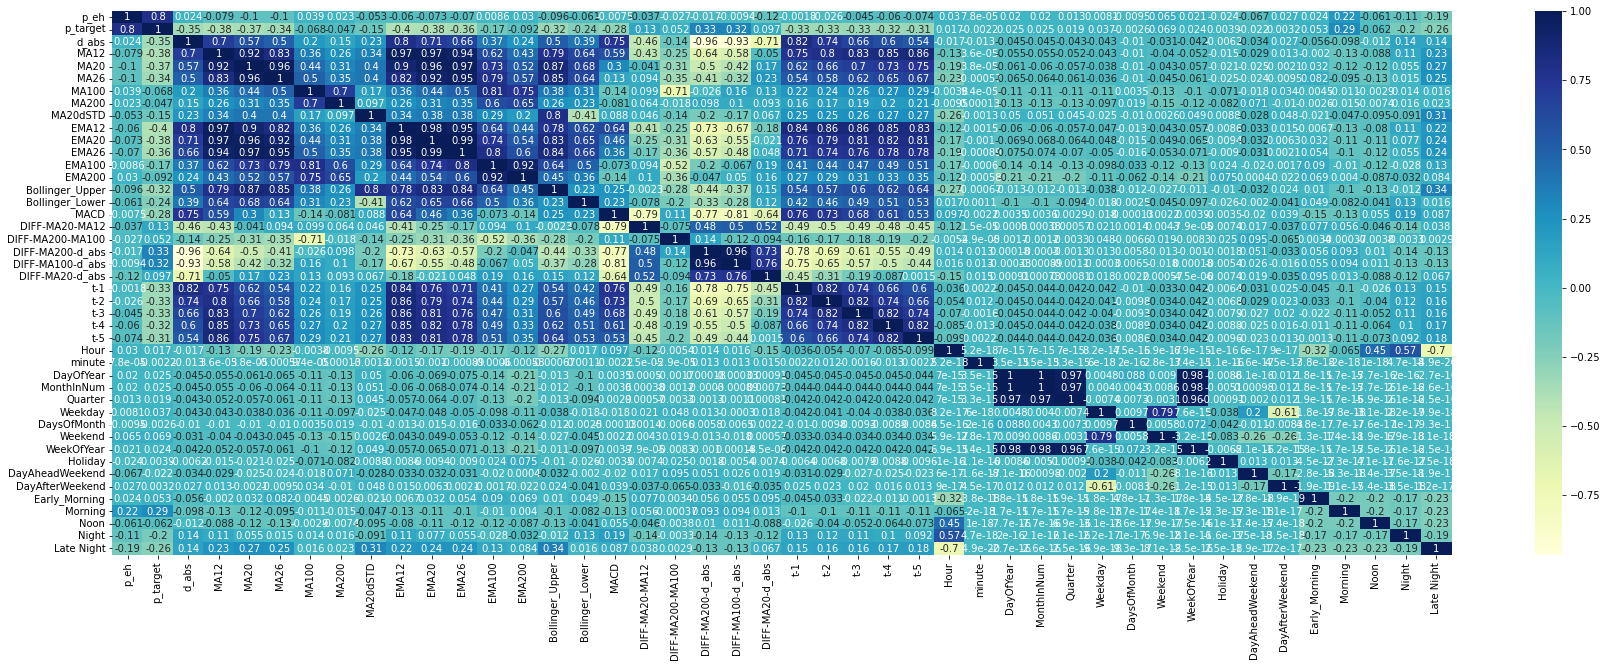

In [10]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
correlation = dftest.corr() #corr() method of pandas library calculates correlation between columns of dataframe
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
#plt.figsize=(16,7)
plt.show()

In [11]:
# calculate weekofmonth
from datetime import datetime as dt
from math import ceil
calendar.setfirstweekday(0)

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))
dftest['WeekOfMonth'] = dftest['time'].apply(week_of_month)
#encoding Seasons
from sklearn.preprocessing import LabelEncoder
categorical_features = [ 'Seasons']
le = LabelEncoder()
for i in range(1):
    new = le.fit_transform(dftest[categorical_features[i]])
    dftest[categorical_features[i]] = new
df_train=dftest


In [12]:
'''features=df_train.columns.drop(['time'])
for i in features:
    sns.lmplot(x=i, y="d_abs", data=df_train,line_kws={'color': 'red'})
    text="Relation between Points and " + i 
    plt.title(text)
    plt.show()'''

'features=df_train.columns.drop([\'time\'])\nfor i in features:\n    sns.lmplot(x=i, y="d_abs", data=df_train,line_kws={\'color\': \'red\'})\n    text="Relation between Points and " + i \n    plt.title(text)\n    plt.show()'

In [13]:
'''correlation = df_train.corr()['d_abs']
# convert series to dataframe so it can be sorted
correlation_df = pd.DataFrame(correlation)
# correct column label from Points to correlation
correlation_df.columns = ["Correlation"]
# sort correlation
corr_sorted = correlation_df.sort_values(by=['Correlation'], ascending=False)
corr_sorted.head(50)'''

'correlation = df_train.corr()[\'d_abs\']\n# convert series to dataframe so it can be sorted\ncorrelation_df = pd.DataFrame(correlation)\n# correct column label from Points to correlation\ncorrelation_df.columns = ["Correlation"]\n# sort correlation\ncorr_sorted = correlation_df.sort_values(by=[\'Correlation\'], ascending=False)\ncorr_sorted.head(50)'

In [56]:
'''
#normalize features

def normalize(df):
    result = df.copy()
    for feature_name in df[['Hour','Weekday','Weekend','minute','DayAheadWeekend','Seasons','DayAfterWeekend','Holiday','Early_Morning','Morning','Noon','Night','Late Night','DaysOfMonth','DayOfYear','Quarter','MonthInNum','d_abs']]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

en=normalize(df_train)
df_train=en
'''
#sort by Seasons
Seasons_W  = df_train.query(' Seasons==Seasons.unique()[0]')
Seasons_F  = df_train.query(' Seasons==Seasons.unique()[1]')
Seasons_S = df_train.query(' Seasons==Seasons.unique()[2]')
Seasons_H = df_train.query(' Seasons==Seasons.unique()[3]')
#Apply splitting( training and testing split)
import random
list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
df_for_testing = pd.DataFrame(columns=df_train.columns) 
df_for_training = pd.DataFrame(columns=df_train.columns) 
for i in list_of_datasets:
  test_list=(i.DayOfYear)
  test_list_rand=random.sample(list(test_list),18)# 18 is 20 procent of the three months
  df_for_test_check=i[i.DayOfYear.isin(test_list_rand)]
  df_for_train_check=i[~(i.DayOfYear.isin(test_list_rand))]
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
  proportion_test =round(((df_for_testing.groupby('Weekend').size()/df_for_testing['Weekend'].count())*100).iloc[1])


In [57]:
proportion_test

30

# Stacked generalization

In [72]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import svm
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
estimators = [('RF', RandomForestRegressor()),
              ('SVM', svm.SVR()),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]

final_estimator = GradientBoostingRegressor(
    n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
scaler = MinMaxScaler()
df_for_training_apart = df_for_training


X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']



start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")




Training time: 531.8247573375702s


# KNN

In [70]:

#KNN

import time
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training


X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
model = KNeighborsRegressor(n_neighbors=2)

#,'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
#'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'

start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")




Training time: 0.0009026527404785156s


# SVM

In [68]:
#SVM

import time
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_for_training_apart = df_for_training

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm



df_for_training_apart = df_for_training


X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
model = svm.SVR()

#,'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
#'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'

start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")


Training time: 59.71505618095398s


# GradientBoostingRegressor

In [46]:
#GradientBoostingRegressor

import time
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training
#,'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
#'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']

model = GradientBoostingRegressor(random_state=0)
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")


Training time: 16.12356209754944s


# Random Forest

In [40]:
#Random Forest
import time
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training
#,'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
#'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']

model = RandomForestRegressor(n_estimators= 100, max_depth= 50,min_samples_leaf=4,min_samples_split=5)
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")


Training time: 39.18715786933899s


# Neural Networka

In [58]:
#Neural Network
import time
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_for_training_apart = df_for_training
#,'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
#'t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning'
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_train = df_for_training_apart['d_abs']
X_train_scaled = scaler.fit_transform(X_train)

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','t-5','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Bollinger_Upper','Noon','Night','Late Night','Early_Morning']]
y_test = df_for_testing['d_abs']
#1-use parameter alpha for regularization (L2 regularization) term which helps in avoiding overfitting by penalizing weights with large magnitudes.
#2-hidden_layer_sizes= drei hidden layer with each 50 neureus structure
#3-The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
#4-The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
#5-solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’: The solver for weight optimization.‘adam’ refers to a stochastic gradient-based optimizer 
model = MLPRegressor(activation='relu',alpha= 0.05,hidden_layer_sizes= (50, 50, 50),learning_rate= 'constant',solver= 'adam')
start = time.time()
model.fit(X_train_scaled, y_train)
stop = time.time()
X_test_scaled = scaler.transform(X_test)
y_preds = model.predict(X_test_scaled)
print(f"Training time: {stop - start}s")



Training time: 73.14890241622925s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [120]:

#print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
#score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
#print(f'Root Mean Squared Error:{score:0.2f}')

##Evaluation metric (MER), and the distribution of error realtively to data points per day


Root Mean Squared Error:4017226.55


In [73]:
from operator import index
result = pd.DataFrame()
result['y_test'] = y_test
result['y_preds'] = y_preds
result['Absolute error'] = abs(y_test-y_preds)
#####result['Relative_error'] = (result['Absolute error']*100)/result['y_test']
result['MSE']  = (result['y_preds'] - result['y_test'])**2
result['RMSE']= np.sqrt(result['MSE'])
result['MPE'] = ((result['y_test'] - result['y_preds'])/result['y_test'])*100
result['MAPE'] = (np.abs((result['y_test'] - result['y_preds'])/result['y_test'] ))*100
#result['MER'] = (sum(result['Absolute error']/ np.mean(result['y_test'])))*100/len(result)
#mean pro tag
merged=df_for_testing
merged=merged.merge(result[['y_test','y_preds','Absolute error','MSE','RMSE','MPE','MAPE']],how='left',left_index=True,right_index=True)
merged


time       p_eh    p_target      d_abs       MA12  \
192   2019-01-03 00:00:00 37570905.1 -28983444.1 66554349.2 14600932.7   
193   2019-01-03 00:15:00  6417459.7 -28549178.9 34966638.6 16709625.7   
194   2019-01-03 00:30:00  -388999.4 -29463649.1 29074649.7 18417984.2   
195   2019-01-03 00:45:00 -1053689.1 -30000000.0 28946310.9 19891902.0   
196   2019-01-03 01:00:00  -953689.1 -28906724.0 27953035.0 21451534.8   
...                   ...        ...         ...        ...        ...   
34075 2019-12-21 22:45:00 -4809465.9 -14357508.4  9548042.4  8103910.2   
34076 2019-12-21 23:00:00 -5492841.0 -13724804.5  8231963.5  8575658.2   
34077 2019-12-21 23:15:00 -5509502.6 -18031305.2 12521802.6  9152162.4   
34078 2019-12-21 23:30:00 -5642832.2 -15485223.6  9842391.5  9427174.3   
34079 2019-12-21 23:45:00 -5542910.5 -14953504.4  9410593.9  9379192.3   

            MA20       MA26      MA100      MA200   MA20dSTD  ...  Night  \
192   13582036.1 12568928.3  9874302.6  1806530.4 12889220.0  ...      0   
193   14264672.9 13711567.4 10108501.9  1806530.4 13658826.8  ...      0   
194   14815577.4 14533265.0 10255607.1  1806530.4 14036783.5  ...      0   
195   15754177.5 15391491.5 10325849.7  1806530.4 14334557.8  ...      0   
196   16640500.5 16121255.3 10248116.6  1806530.4 14521595.1  ...      0   
...          ...        ...        ...        ...        ...  ...    ...   
34075  6242089.8  5994387.3 11521232.0 14638913.0  3781887.6  ...      1   
34076  6269308.0  6274857.8 11279999.9 14526136.7  3794775.3  ...      1   
34077  6872987.2  6705086.3 11088270.9 14443658.3  3780323.8  ...      1   
34078  6893188.4  6728967.9 10873874.9 14341288.7  3795802.0  ...      1   
34079  7143327.2  6690338.3 10650111.4 14237032.5  3788229.9  ...      1   

       Late Night  WeekOfMonth     y_test    y_preds  Absolute error  \
192             1            1 66554349.2 16665773.6      49888575.7   
193             1            1 34966638.6 29121117.3       5845521.2   
194             1            1 29074649.7 29868647.7        793997.9   
195             1            1 28946310.9 22478293.4       6468017.6   
196             1            1 27953035.0 23797776.4       4155258.6   
...           ...          ...        ...        ...             ...   
34075           0            4  9548042.4  9323622.2        224420.2   
34076           0            4  8231963.5  8457107.7        225144.2   
34077           0            4 12521802.6  9558719.5       2963083.1   
34078           0            4  9842391.5 10747861.7        905470.3   
34079           0            4  9410593.9 10836540.8       1425946.9   

                     MSE       RMSE   MPE  MAPE  
192   2488869981602848.0 49888575.7  75.0  75.0  
193     34170118276618.3  5845521.2  16.7  16.7  
194       630432730579.9   793997.9  -2.7   2.7  
195     41835251187246.9  6468017.6  22.3  22.3  
196     17266174092519.4  4155258.6  14.9  14.9  
...                  ...        ...   ...   ...  
34075      50364446392.4   224420.2   2.4   2.4  
34076      50689930198.0   225144.2  -2.7   2.7  
34077    8779861204160.5  2963083.1  23.7  23.7  
34078     819876417352.6   905470.3  -9.2   9.2  
34079    2033324537348.8  1425946.9 -15.2  15.2  

[6432 rows x 57 columns]

In [74]:
#this worked one for the aggregation
mode_df=merged.groupby(['Dates']).mean()[['y_test']]

###########mode_df=merged.groupby(['Dates']).mean()[['y_test']]
##must use this index Dates first
#merged=merged.set_index('Dates')

merged1=merged.set_index('Dates').merge(mode_df[['y_test']],how='left',left_index=True,right_index=True)
merged1=merged1.rename(columns = {'y_test_y':'Mean_y_test_Daily'})
merged1=merged1.rename(columns = {'y_test_x':'y_test'})
#mode_df.head()
#merged1.reset_index()
merged1['MER']=(merged1['Absolute error']/merged1['Mean_y_test_Daily'])*100
merged1=merged1.reset_index(None)
merged1

Dates                time       p_eh    p_target      d_abs  \
0     2019-01-03 2019-01-03 00:00:00 37570905.1 -28983444.1 66554349.2   
1     2019-01-03 2019-01-03 00:15:00  6417459.7 -28549178.9 34966638.6   
2     2019-01-03 2019-01-03 00:30:00  -388999.4 -29463649.1 29074649.7   
3     2019-01-03 2019-01-03 00:45:00 -1053689.1 -30000000.0 28946310.9   
4     2019-01-03 2019-01-03 01:00:00  -953689.1 -28906724.0 27953035.0   
...          ...                 ...        ...         ...        ...   
6427  2019-12-21 2019-12-21 22:45:00 -4809465.9 -14357508.4  9548042.4   
6428  2019-12-21 2019-12-21 23:00:00 -5492841.0 -13724804.5  8231963.5   
6429  2019-12-21 2019-12-21 23:15:00 -5509502.6 -18031305.2 12521802.6   
6430  2019-12-21 2019-12-21 23:30:00 -5642832.2 -15485223.6  9842391.5   
6431  2019-12-21 2019-12-21 23:45:00 -5542910.5 -14953504.4  9410593.9   

           MA12       MA20       MA26      MA100      MA200  ...  WeekOfMonth  \
0    14600932.7 13582036.1 12568928.3  9874302.6  1806530.4  ...            1   
1    16709625.7 14264672.9 13711567.4 10108501.9  1806530.4  ...            1   
2    18417984.2 14815577.4 14533265.0 10255607.1  1806530.4  ...            1   
3    19891902.0 15754177.5 15391491.5 10325849.7  1806530.4  ...            1   
4    21451534.8 16640500.5 16121255.3 10248116.6  1806530.4  ...            1   
...         ...        ...        ...        ...        ...  ...          ...   
6427  8103910.2  6242089.8  5994387.3 11521232.0 14638913.0  ...            4   
6428  8575658.2  6269308.0  6274857.8 11279999.9 14526136.7  ...            4   
6429  9152162.4  6872987.2  6705086.3 11088270.9 14443658.3  ...            4   
6430  9427174.3  6893188.4  6728967.9 10873874.9 14341288.7  ...            4   
6431  9379192.3  7143327.2  6690338.3 10650111.4 14237032.5  ...            4   

         y_test    y_preds  Absolute error                MSE       RMSE  \
0    66554349.2 16665773.6      49888575.7 2488869981602848.0 49888575.7   
1    34966638.6 29121117.3       5845521.2   34170118276618.3  5845521.2   
2    29074649.7 29868647.7        793997.9     630432730579.9   793997.9   
3    28946310.9 22478293.4       6468017.6   41835251187246.9  6468017.6   
4    27953035.0 23797776.4       4155258.6   17266174092519.4  4155258.6   
...         ...        ...             ...                ...        ...   
6427  9548042.4  9323622.2        224420.2      50364446392.4   224420.2   
6428  8231963.5  8457107.7        225144.2      50689930198.0   225144.2   
6429 12521802.6  9558719.5       2963083.1    8779861204160.5  2963083.1   
6430  9842391.5 10747861.7        905470.3     819876417352.6   905470.3   
6431  9410593.9 10836540.8       1425946.9    2033324537348.8  1425946.9   

       MPE  MAPE  Mean_y_test_Daily   MER  
0     75.0  75.0         18924656.7 263.6  
1     16.7  16.7         18924656.7  30.9  
2     -2.7   2.7         18924656.7   4.2  
3     22.3  22.3         18924656.7  34.2  
4     14.9  14.9         18924656.7  22.0  
...    ...   ...                ...   ...  
6427   2.4   2.4          9774788.2   2.3  
6428  -2.7   2.7          9774788.2   2.3  
6429  23.7  23.7          9774788.2  30.3  
6430  -9.2   9.2          9774788.2   9.3  
6431 -15.2  15.2          9774788.2  14.6  

[6432 rows x 59 columns]

# used code for solving the MER at the beginning


In [135]:
'''

#merged1['MER_new']=  (sum(merged1['Absolute error']/ merged1['y_test_y']))*100/96
merged2=merged1[['time','Absolute error','y_test_y']]
merged2['newMER']=merged2['Absolute error']/merged2['y_test_y']
merged2['MERfinal_perDatapoint']=merged2['newMER']*100
#merged2=merged2.set_index('Dates')
#merged2=merged2.reset_index()
#merged3=merged2.set_index('time')
merged3['sum']=merged2['newMER'].sum()
#merged3['MERfinal_Daily']=merged3['sum']*100/96
#merged2=merged2.reset_index()
merged3
#################merged3['MERfinal_1'].head(96).nsmallest(10)

merged1[['time','MER']].head(96).sort_values(by=['MER'],ascending=False)
'''

"\n\n#merged1['MER_new']=  (sum(merged1['Absolute error']/ merged1['y_test_y']))*100/96\nmerged2=merged1[['time','Absolute error','y_test_y']]\nmerged2['newMER']=merged2['Absolute error']/merged2['y_test_y']\nmerged2['MERfinal_perDatapoint']=merged2['newMER']*100\n#merged2=merged2.set_index('Dates')\n#merged2=merged2.reset_index()\n#merged3=merged2.set_index('time')\nmerged3['sum']=merged2['newMER'].sum()\n#merged3['MERfinal_Daily']=merged3['sum']*100/96\n#merged2=merged2.reset_index()\nmerged3\n#################merged3['MERfinal_1'].head(96).nsmallest(10)\n\nmerged1[['time','MER']].head(96).sort_values(by=['MER'],ascending=False)\n"

# Visualization of  actual/predicted  and the error and metrics for all the **test dataset**


In [ ]:
#Visualization
from enum import auto
#merged1=merged1.set_index('time')
#merged1=merged1.reset_index()
for date, d in merged1.groupby(merged1['Dates']):
  fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(16,16))
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Actual value',ax=axes[0])
  ax1 = d['y_preds'].plot(color='red',legend=True,style='-',label='Predicted value',ax=axes[0])
  ax1.legend(loc='upper right')
  ax1.set_title('Actual and predicted absolute error',  fontsize=20)
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax2=sns.scatterplot(data=d,x = d.index,y=d['Absolute error'],ax=axes[1], color='red')
  ax3=sns.scatterplot(data=d,x = d.index,y=d['MPE'],ax=axes[2], color='green')
  ax4=sns.scatterplot(data=d,x = d.index,y=d['MAPE'],ax=axes[3], color='purple')
  ax5=sns.scatterplot(data=d,x = d.index,y=d['MSE'],ax=axes[4], color='orange')
  ax6=sns.scatterplot(data=d,x = d.index,y=d['RMSE'],ax=axes[5], color='grey')
  ax7=sns.scatterplot(data=d,x = d.index,y=d['Relative_error'],ax=axes[6], color='cyan')
  ax8=sns.scatterplot(data=d,x = d.index,y=d['MER'],ax=axes[7], color='deeppink')
  #ax2.set_ylabel('Absolute error')
  #ax2.set_title('Absolute error for each datapoint in a day ',  fontsize=20)
  ax2.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax2.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  ax2.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax3.grid(b=True, which='major', color='#666666', linestyle='-')
  ax4.grid(b=True, which='major', color='#666666', linestyle='-')
  ax5.grid(b=True, which='major', color='#666666', linestyle='-')
  ax6.grid(b=True, which='major', color='#666666', linestyle='-')
  ax7.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax8.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax2.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax3.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax4.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax5.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax6.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax7.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax8.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  plt.tight_layout()
  plt.xlim=auto
  plt.ylim=auto
  ax1.xlim=auto
  ax2.ylim=auto


#To show the results of the different metrics in seperate dataframe

In [ ]:

'''
result.describe().loc['75%']
#merged.relative_error.between(-10, 61921, inclusive=False)
df = merged[merged['Relative_error'].between(merged['Relative_error'].describe().loc['75%'], merged['Relative_error'].describe().loc['max'])]
df[['time','d_abs','y_preds','Relative_error']].sort_values(by=['Relative_error'],ascending=False)
#df
'''




#To determine the highst value of an metric

In [75]:
df2=merged1[['time','y_test','y_preds','Dates','Absolute error','MSE','RMSE','MPE','MAPE','MER']]
#df2[0:96].nlargest(10, 'MER')
df2.nlargest(10, 'MER')

time     y_test    y_preds       Dates  Absolute error  \
4416 2019-08-30 00:00:00 44815217.2 15721773.7  2019-08-30      29093443.5   
2880 2019-05-25 00:00:00 54876718.4 22254957.4  2019-05-25      32621761.0   
5952 2019-11-30 00:00:00 47533808.0 23870671.5  2019-11-30      23663136.4   
0    2019-01-03 00:00:00 66554349.2 16665773.6  2019-01-03      49888575.7   
2976 2019-06-08 00:00:00 58294756.7 27377382.5  2019-06-08      30917374.2   
2497 2019-04-29 00:15:00 54845998.3 27353390.2  2019-04-29      27492608.0   
4608 2019-09-19 00:00:00 36345396.4 20296446.4  2019-09-19      16048950.0   
2788 2019-05-17 01:00:00  1976896.7 18598083.2  2019-05-17      16621186.5   
769  2019-02-04 00:15:00 51588379.1 20596374.6  2019-02-04      30992004.5   
4961 2019-10-05 16:15:00 38955962.3 16923275.6  2019-10-05      22032686.6   

                    MSE       RMSE    MPE  MAPE   MER  
4416  846428453949022.8 29093443.5   64.9  64.9 399.1  
2880 1064179292910499.0 32621761.0   59.4  59.4 375.0  
5952  559944025271903.2 23663136.4   49.8  49.8 281.9  
0    2488869981602848.0 49888575.7   75.0  75.0 263.6  
2976  955884027633670.4 30917374.2   53.0  53.0 243.7  
2497  755843497173750.5 27492608.0   50.1  50.1 222.7  
4608  257568796477581.6 16048950.0   44.2  44.2 222.1  
2788  276263841057047.7 16621186.5 -840.8 840.8 220.8  
769   960504345440781.0 30992004.5   60.1  60.1 211.1  
4961  485439280440445.3 22032686.6   56.6  56.6 207.1

#After the determination of this highst value, it will be called by its **time** 

In [76]:
#here we can access the data frame of the metrics by a specific day range
df2[(df2['time'] >= '2019-05-25 00:00:00') & (df2['time'] <= '2019-05-25 23:45:00')]

time     y_test    y_preds       Dates  Absolute error  \
2880 2019-05-25 00:00:00 54876718.4 22254957.4  2019-05-25      32621761.0   
2881 2019-05-25 00:15:00  7662287.2 13831252.3  2019-05-25       6168965.1   
2882 2019-05-25 00:30:00  6127107.5 11122935.4  2019-05-25       4995827.9   
2883 2019-05-25 00:45:00  4897533.6 12657336.9  2019-05-25       7759803.3   
2884 2019-05-25 01:00:00 10116960.5 13751756.9  2019-05-25       3634796.4   
...                  ...        ...        ...         ...             ...   
2971 2019-05-25 22:45:00  3155534.2  4912407.9  2019-05-25       1756873.7   
2972 2019-05-25 23:00:00  4610080.4  4912407.9  2019-05-25        302327.5   
2973 2019-05-25 23:15:00  6013908.8  5529528.4  2019-05-25        484380.4   
2974 2019-05-25 23:30:00  3371411.6  5235189.0  2019-05-25       1863777.4   
2975 2019-05-25 23:45:00  7883825.9  5606171.5  2019-05-25       2277654.5   

                    MSE       RMSE    MPE  MAPE   MER  
2880 1064179292910499.0 32621761.0   59.4  59.4 375.0  
2881   38056130411239.4  6168965.1  -80.5  80.5  70.9  
2882   24958295980228.9  4995827.9  -81.5  81.5  57.4  
2883   60214547793198.5  7759803.3 -158.4 158.4  89.2  
2884   13211744534357.8  3634796.4  -35.9  35.9  41.8  
...                 ...        ...    ...   ...   ...  
2971    3086605336386.7  1756873.7  -55.7  55.7  20.2  
2972      91401943347.7   302327.5   -6.6   6.6   3.5  
2973     234624377395.2   484380.4    8.1   8.1   5.6  
2974    3473666280194.4  1863777.4  -55.3  55.3  21.4  
2975    5187709830261.8  2277654.5   28.9  28.9  26.2  

[96 rows x 10 columns]

1. RMSE: it gives more weight to large error since it squares it.
2. MPE: If the sign of MPE is negative, then the model predicts values higher
than actual values. Nevertheless, if the sign is positive, then the model estimate values under than actual values  under-predicts 
3. MAPE as well as MPE are not suitable to use when there are zero values or even very small values in the ground truth since they are calculated by dividing the difference between predicted value and actual
value over the actual value.Therefore, we use Mean Error Relative (MER) as alternative metric.
4. Consequently, the problems that appeared by using MPE
and MAPE are eliminated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

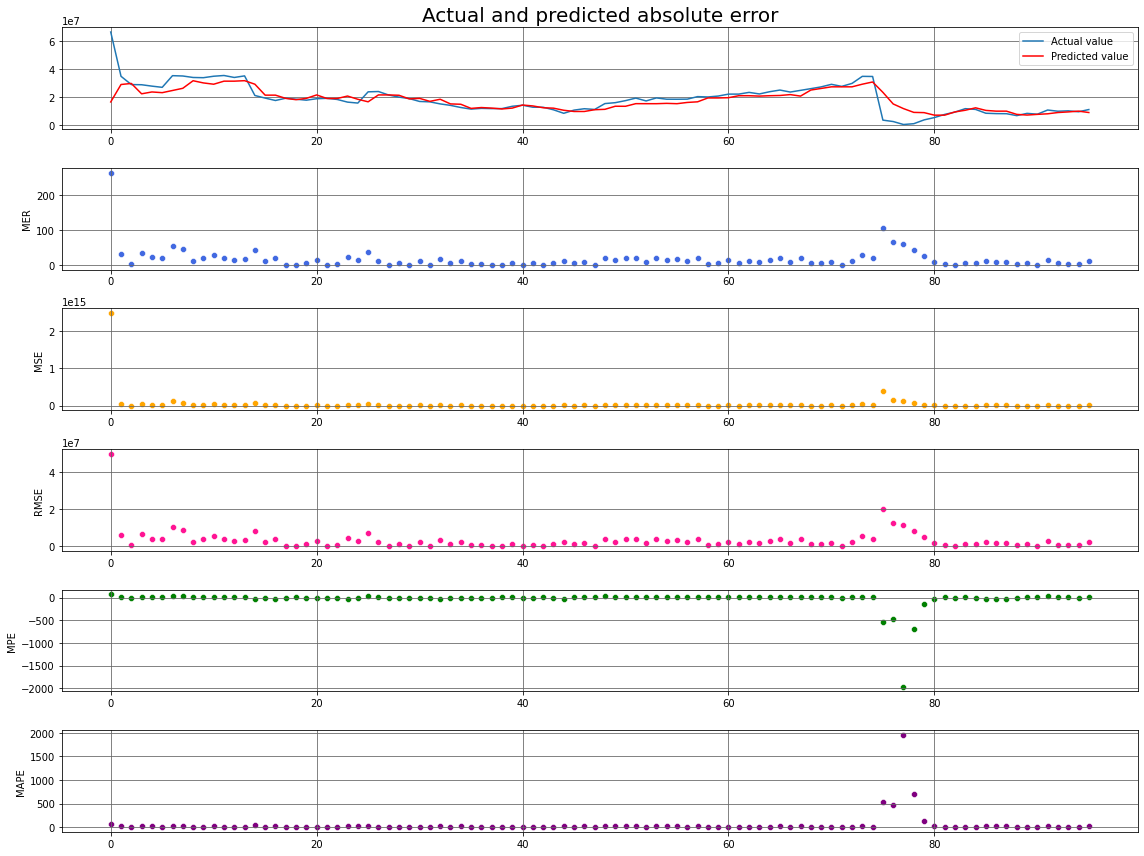

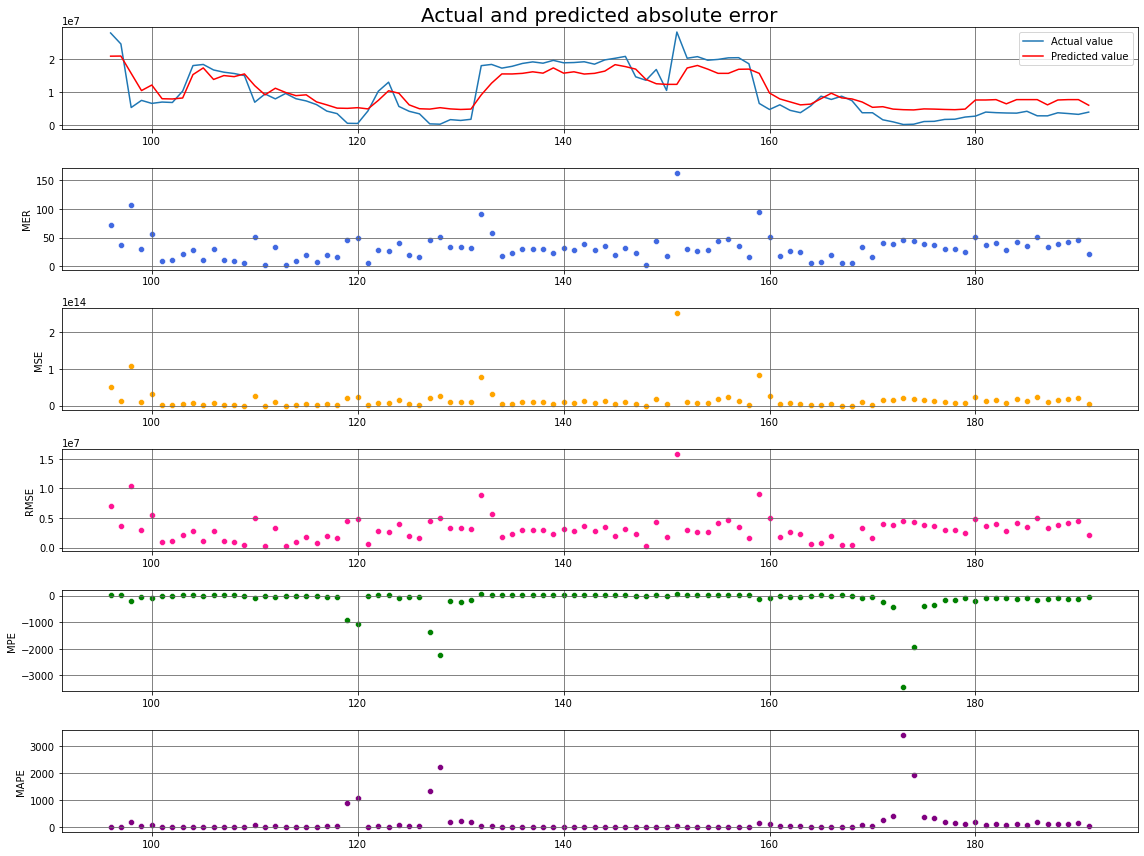

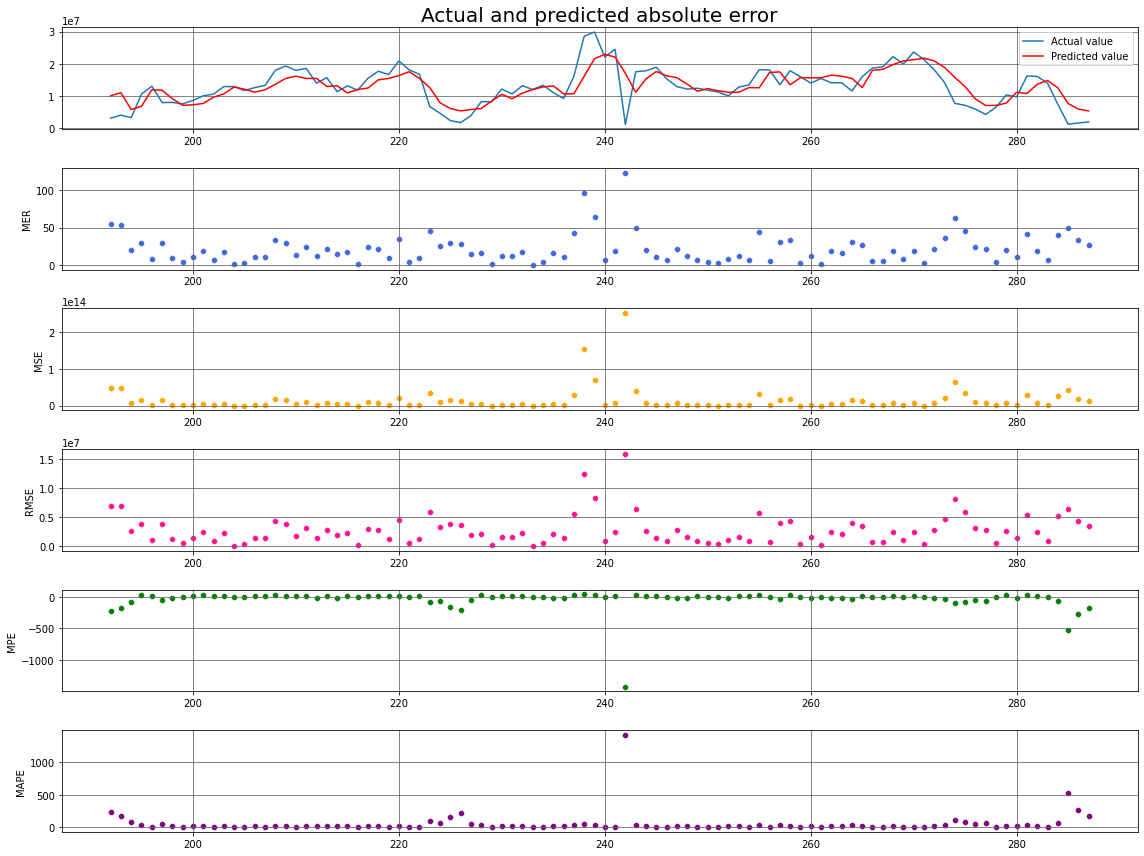

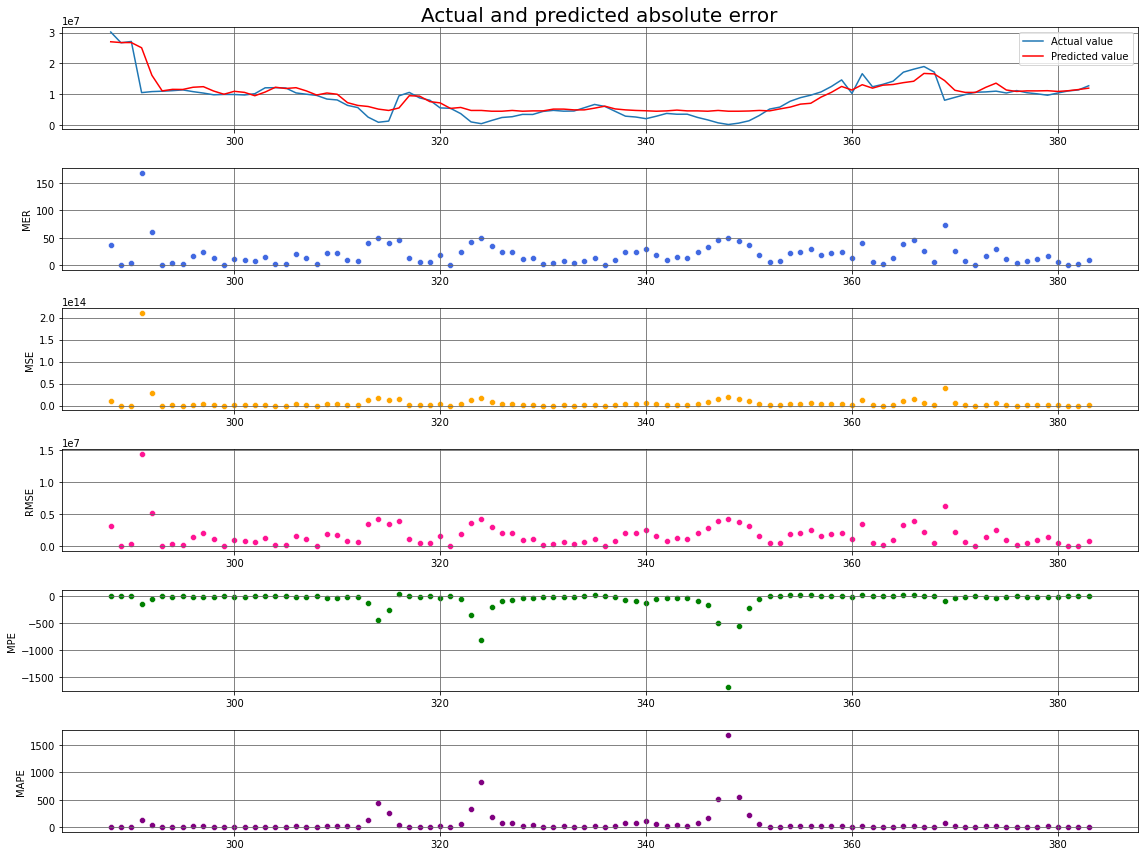

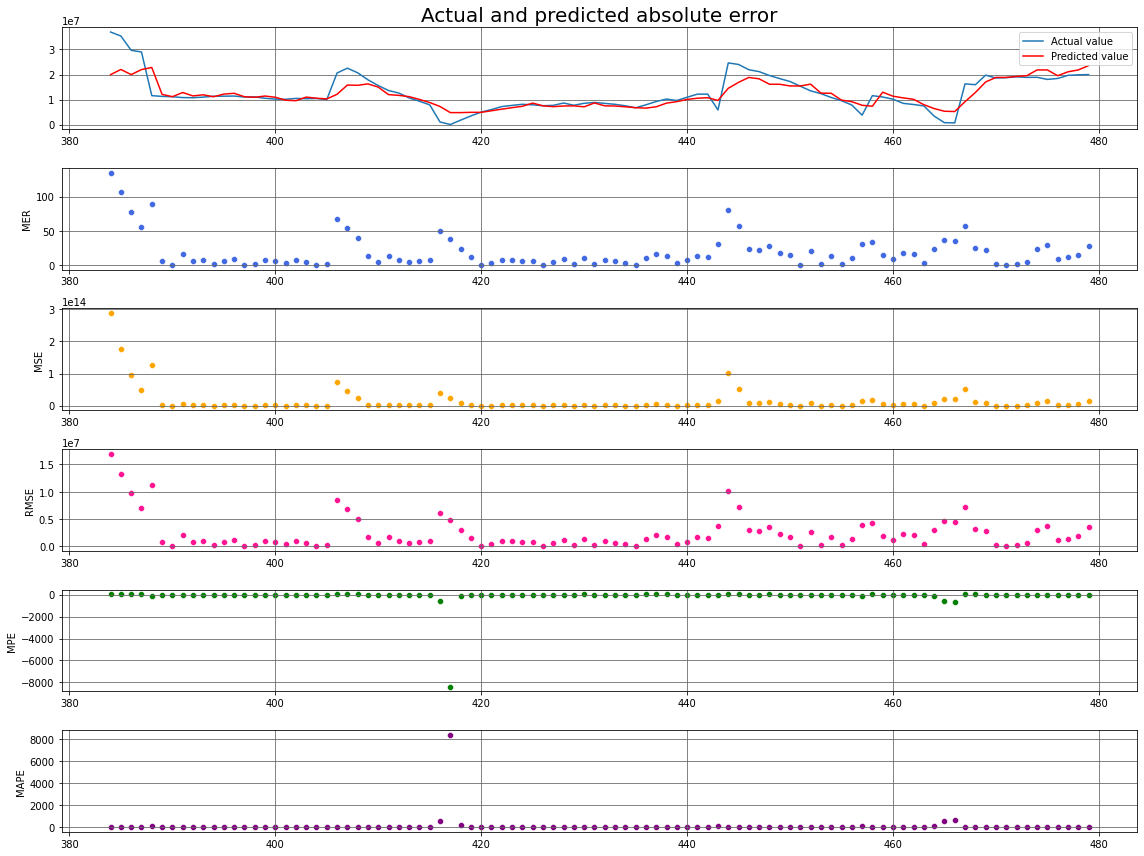

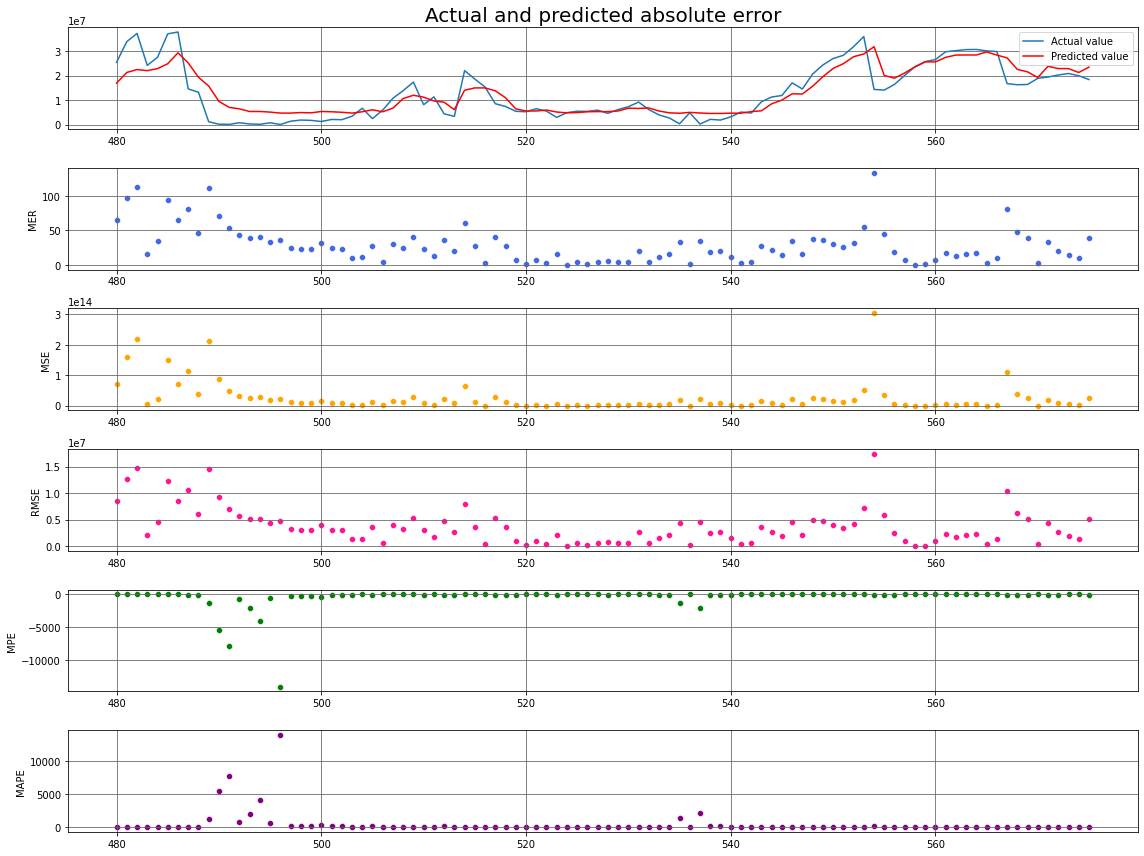

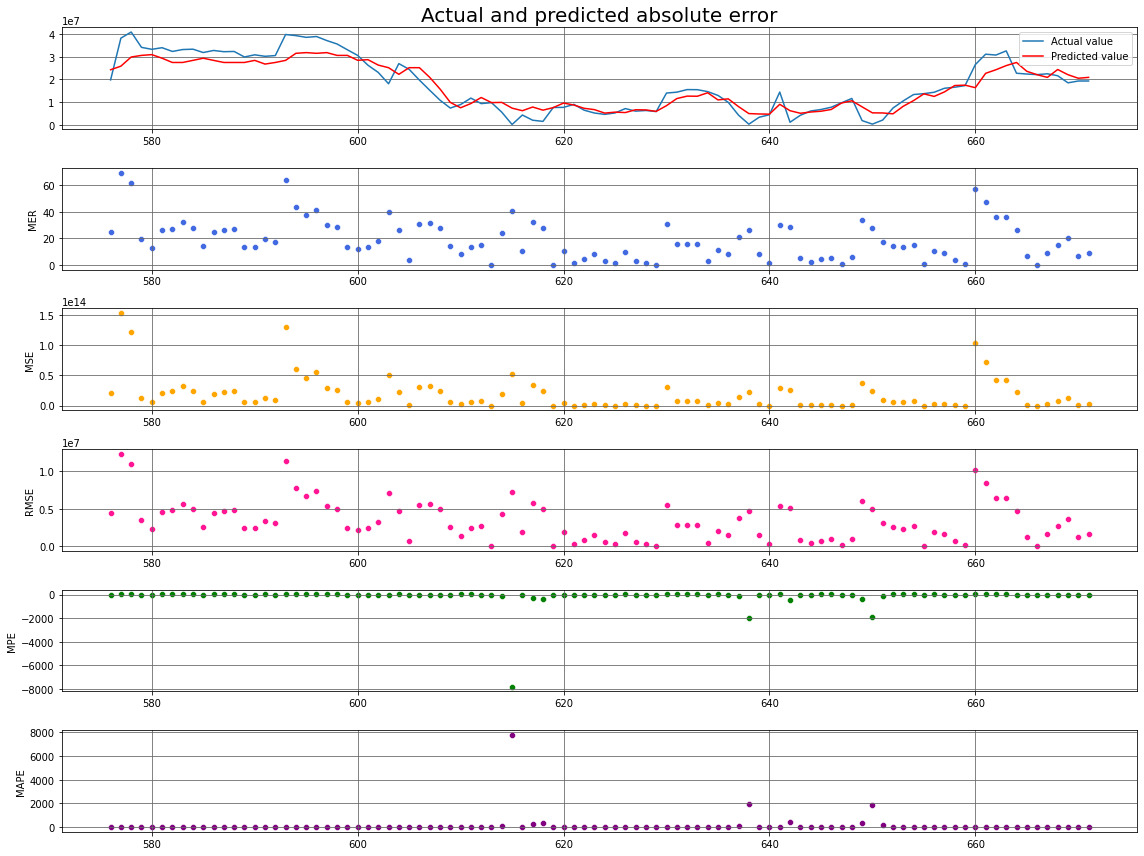

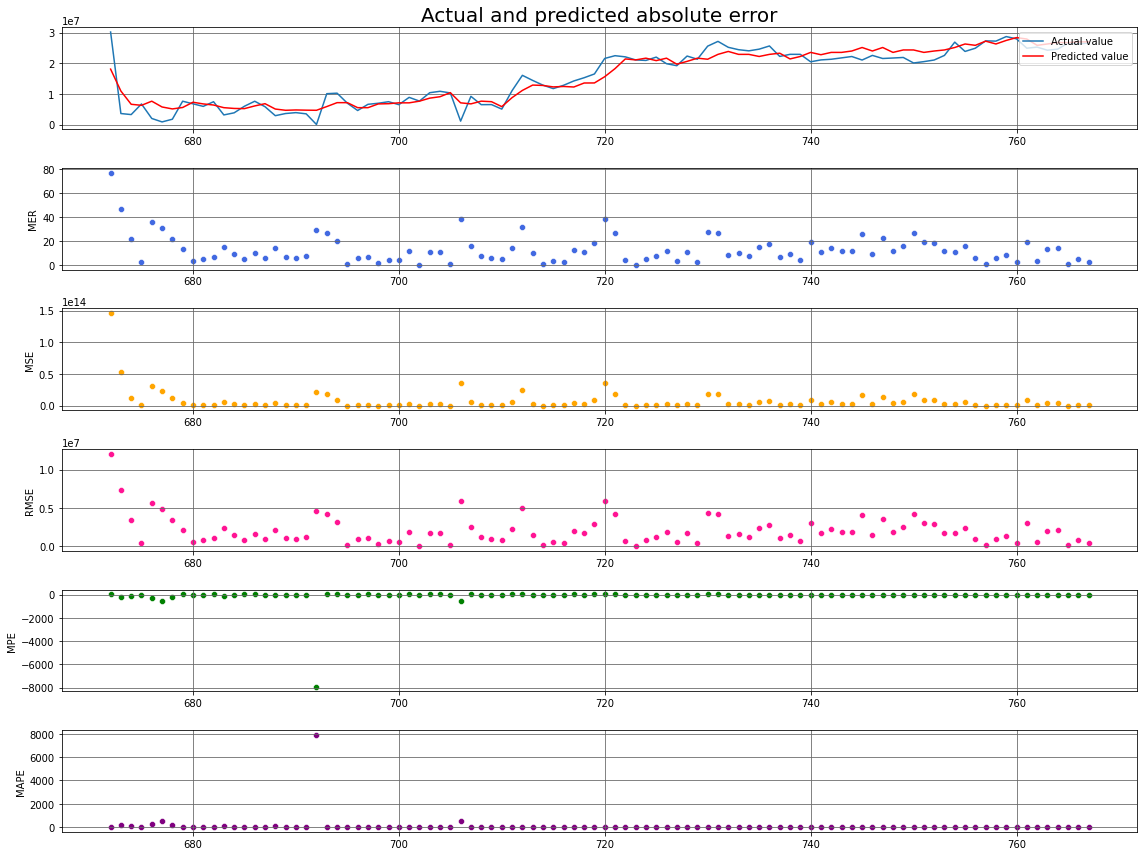

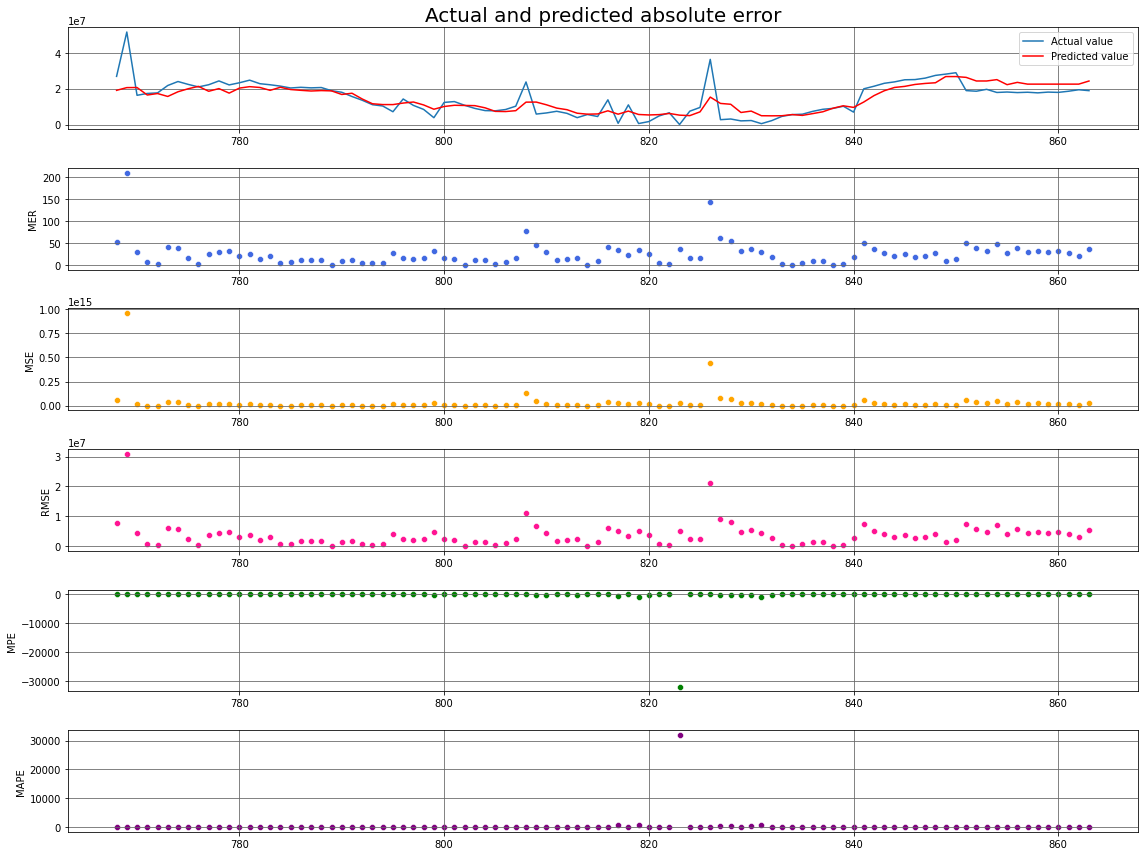

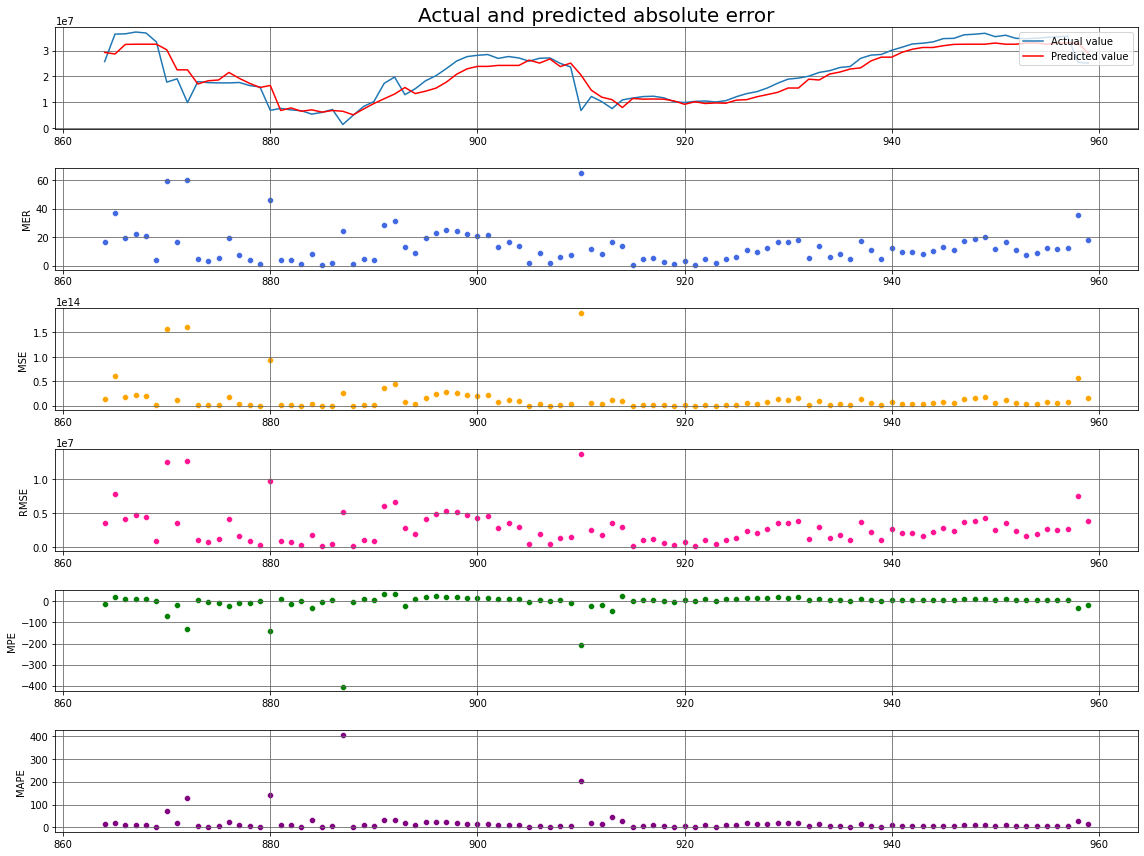

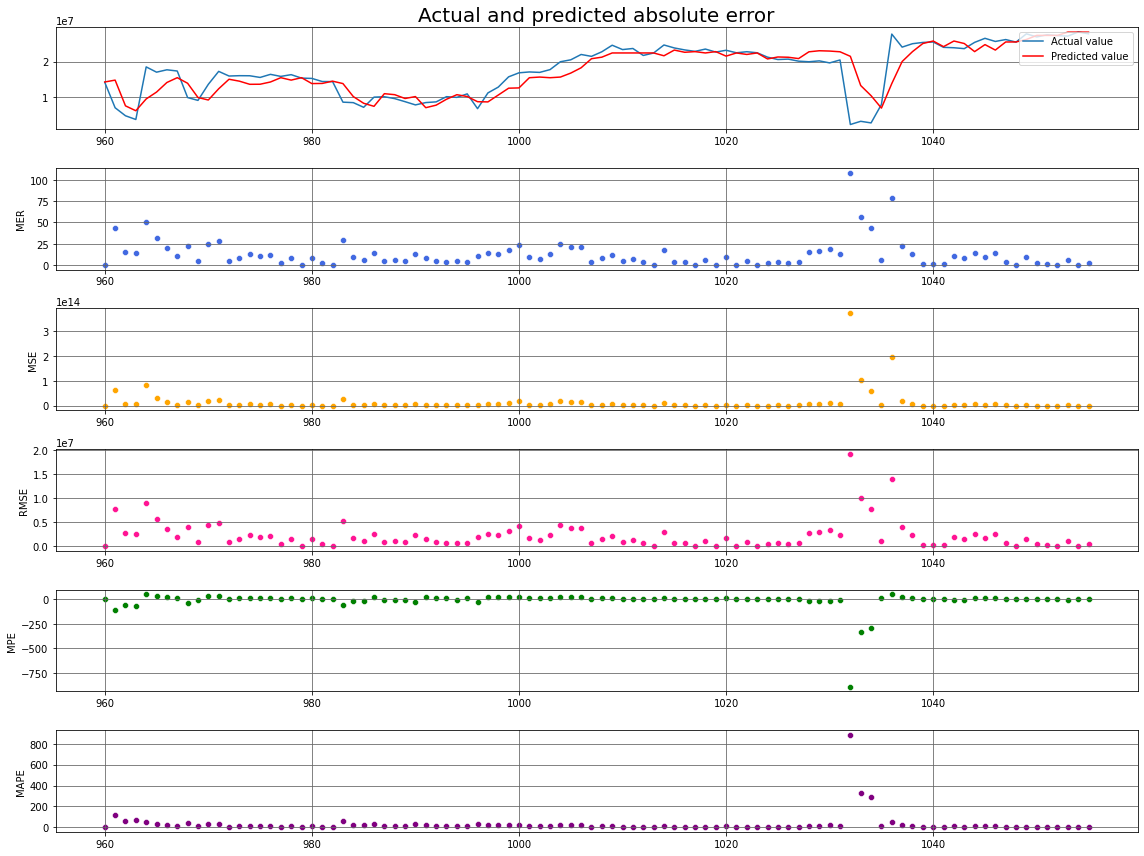

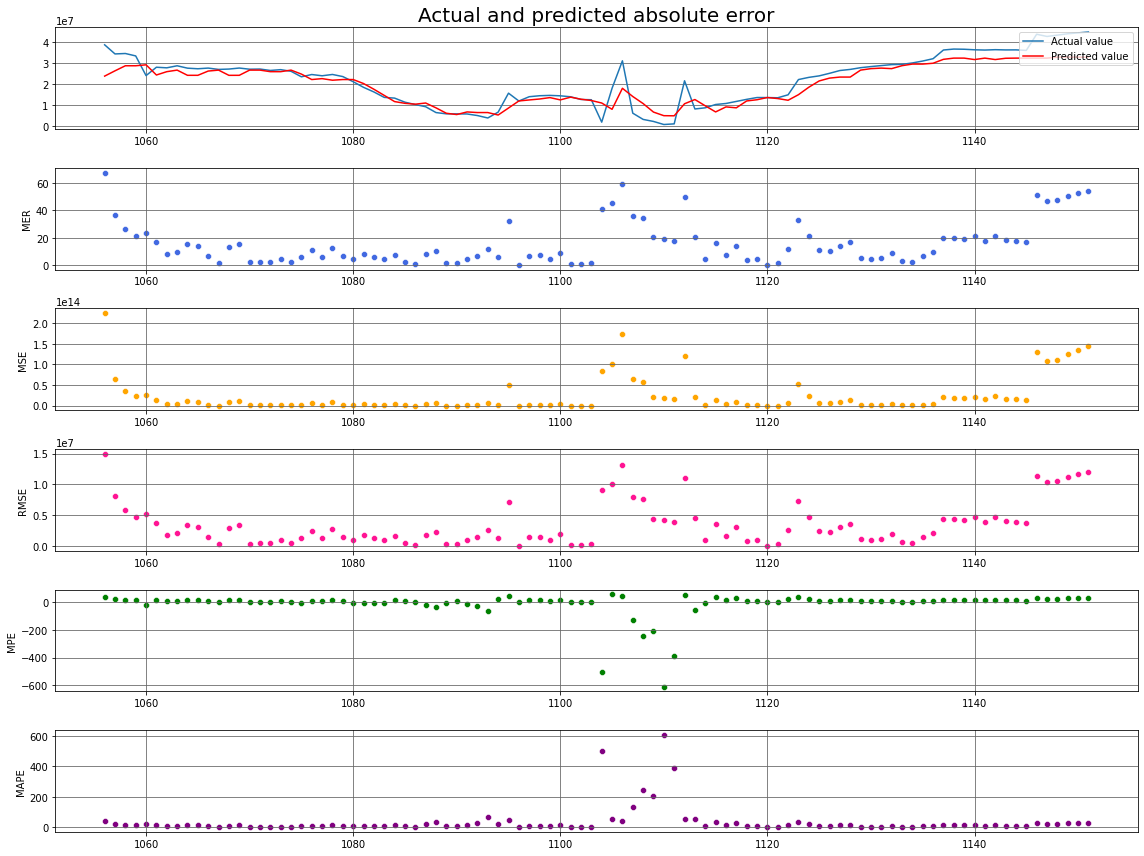

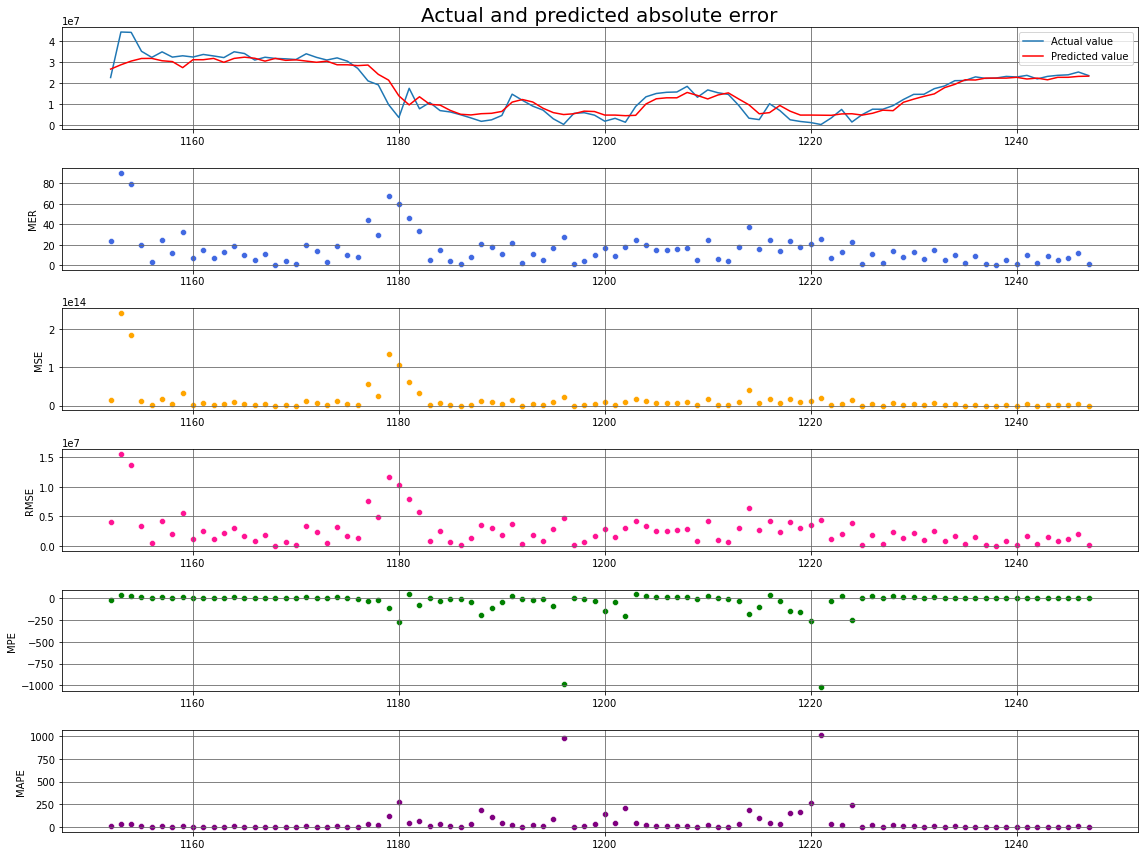

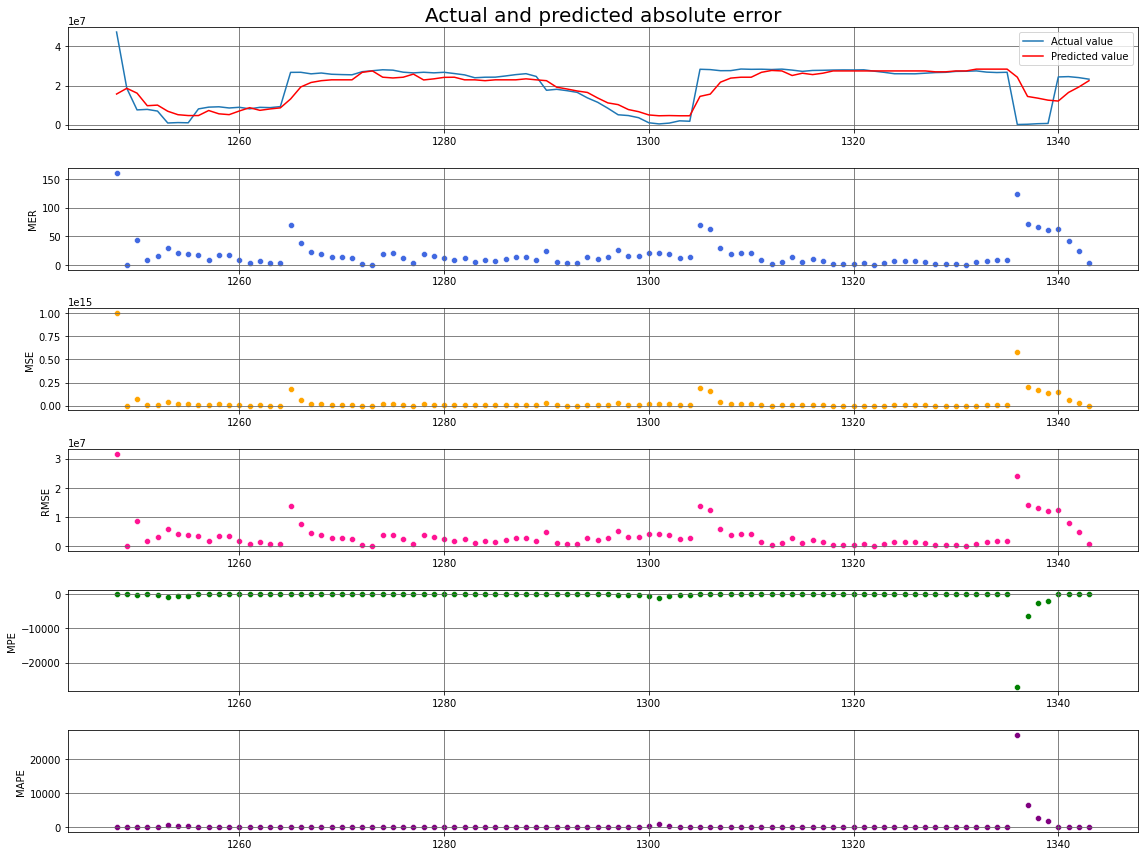

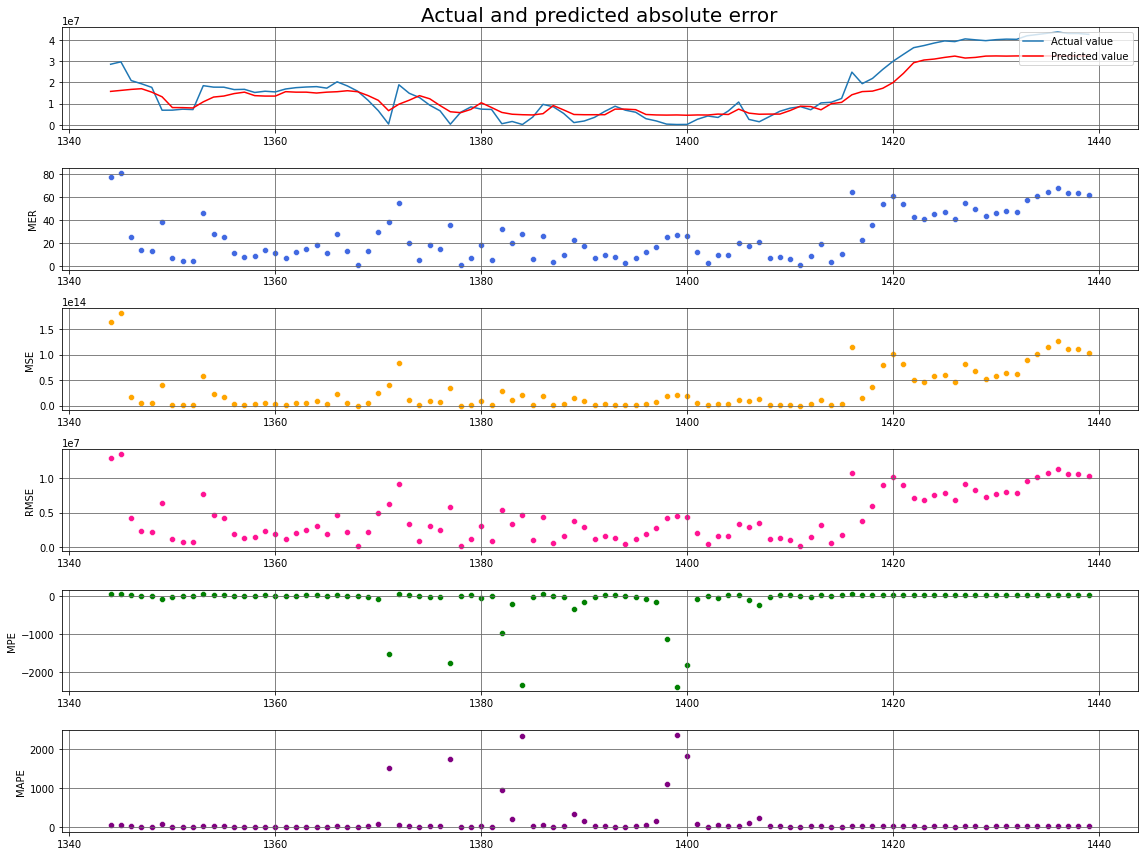

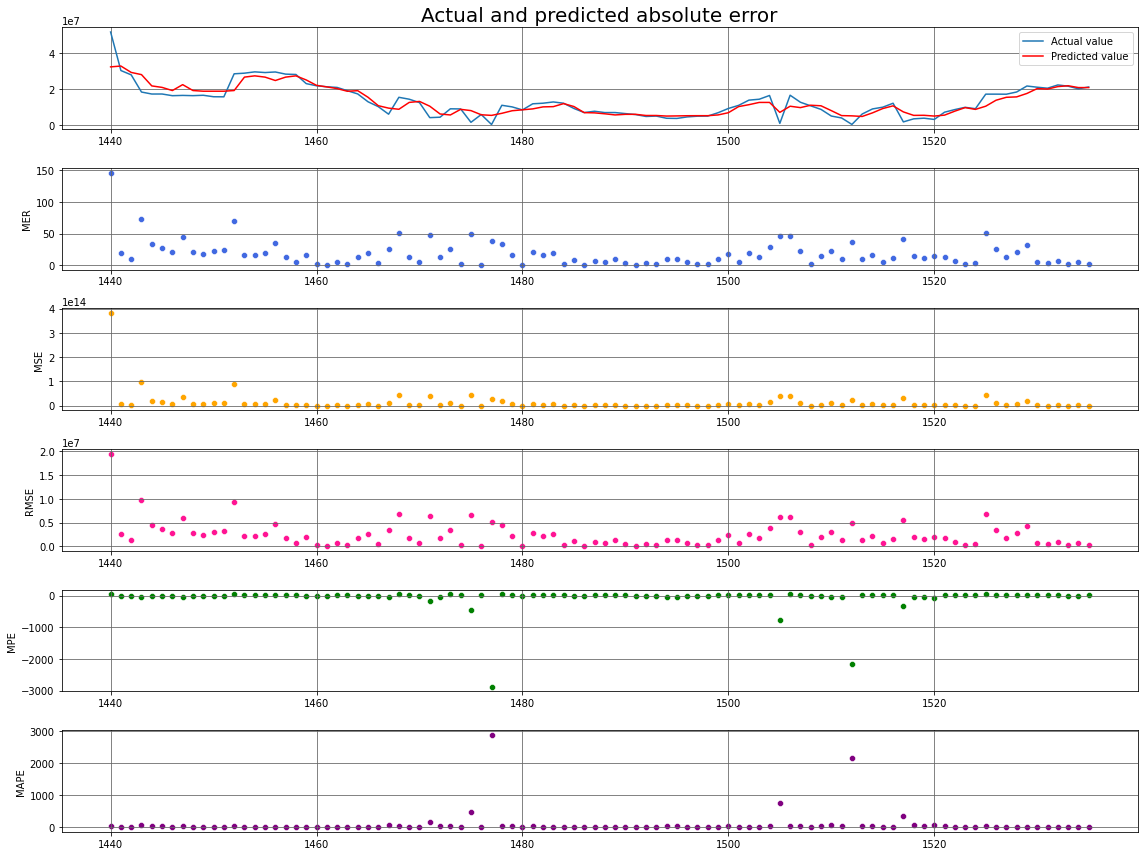

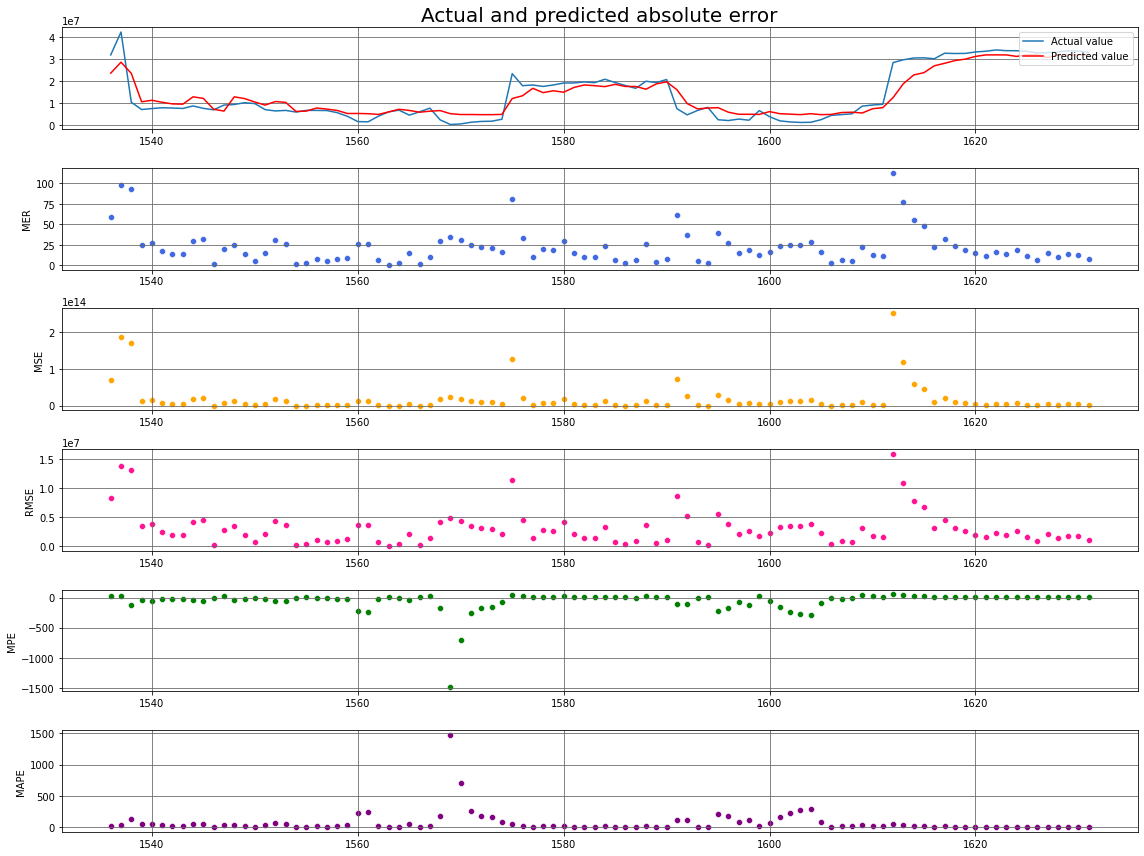

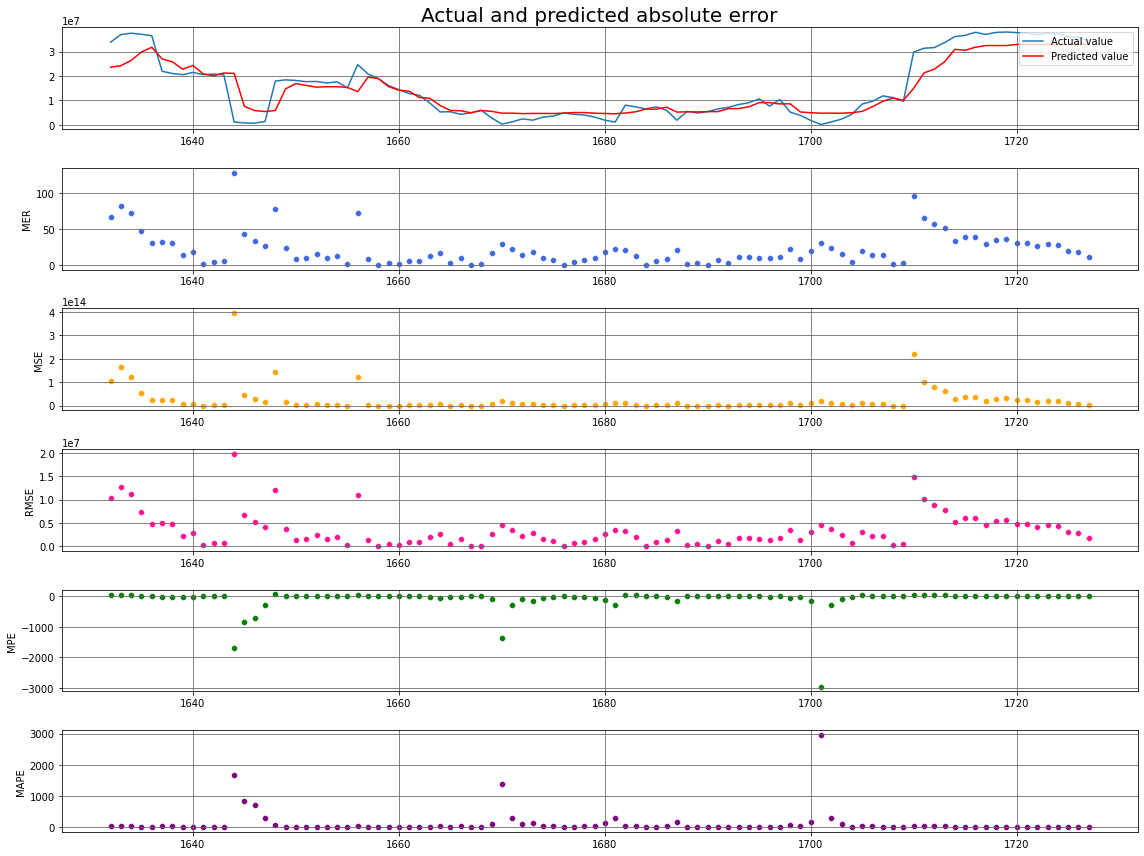

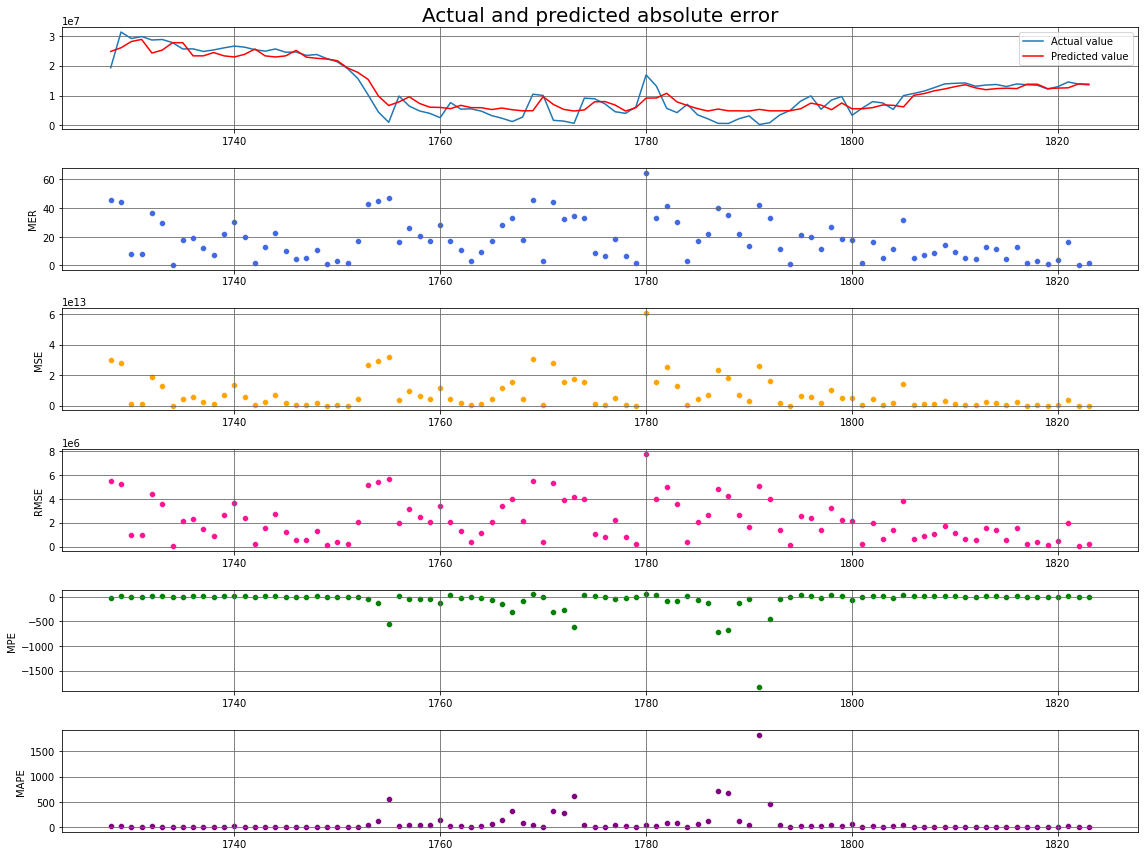

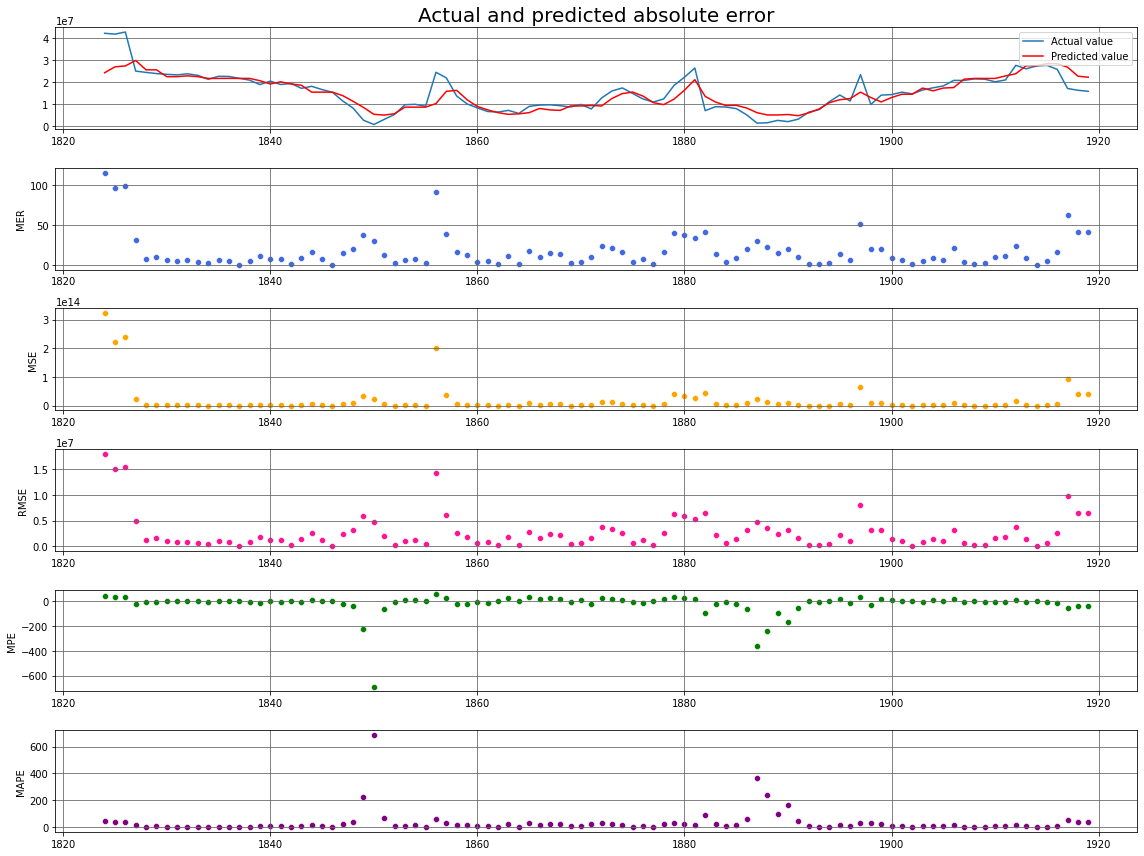

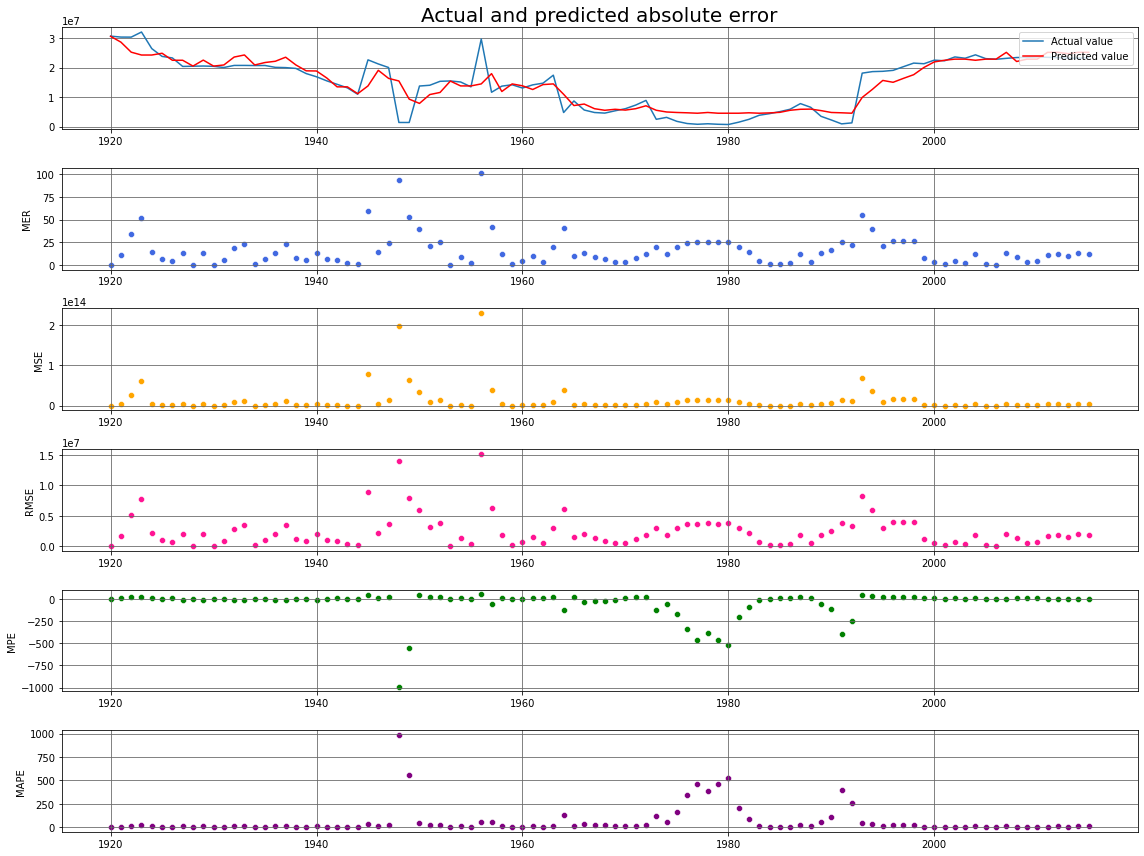

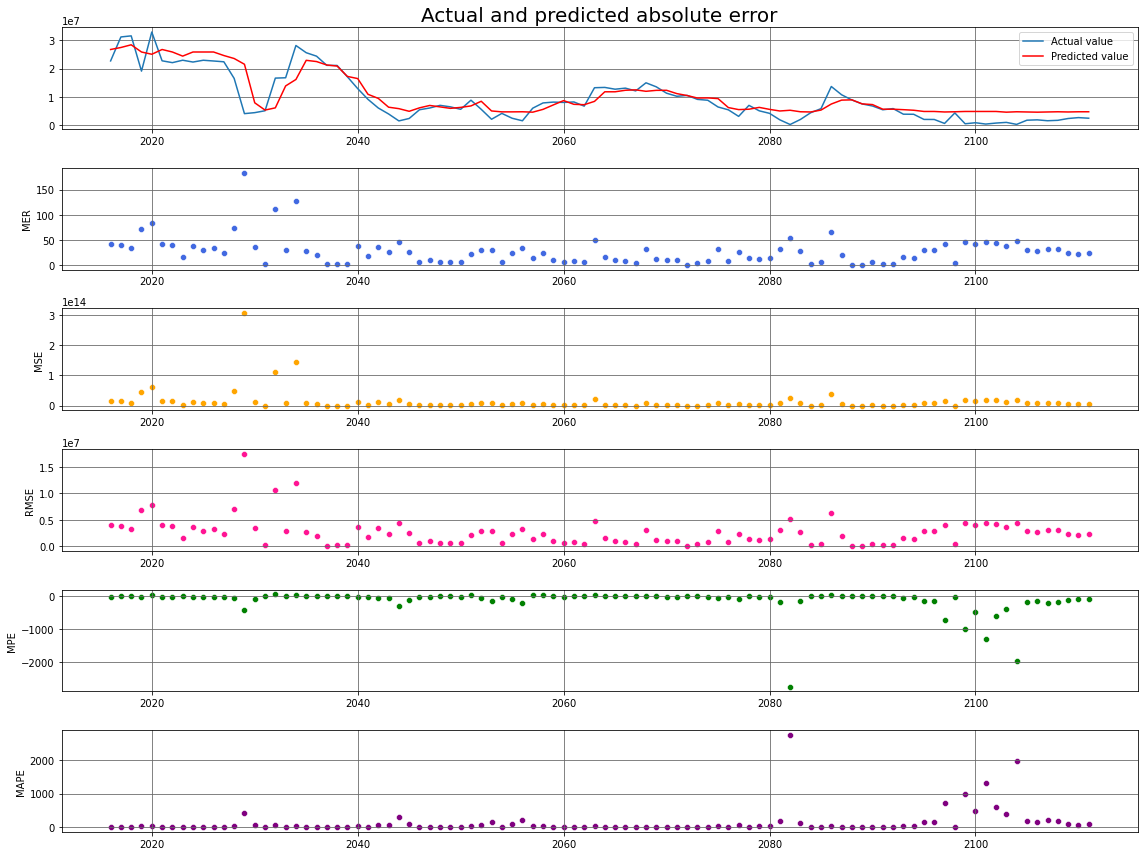

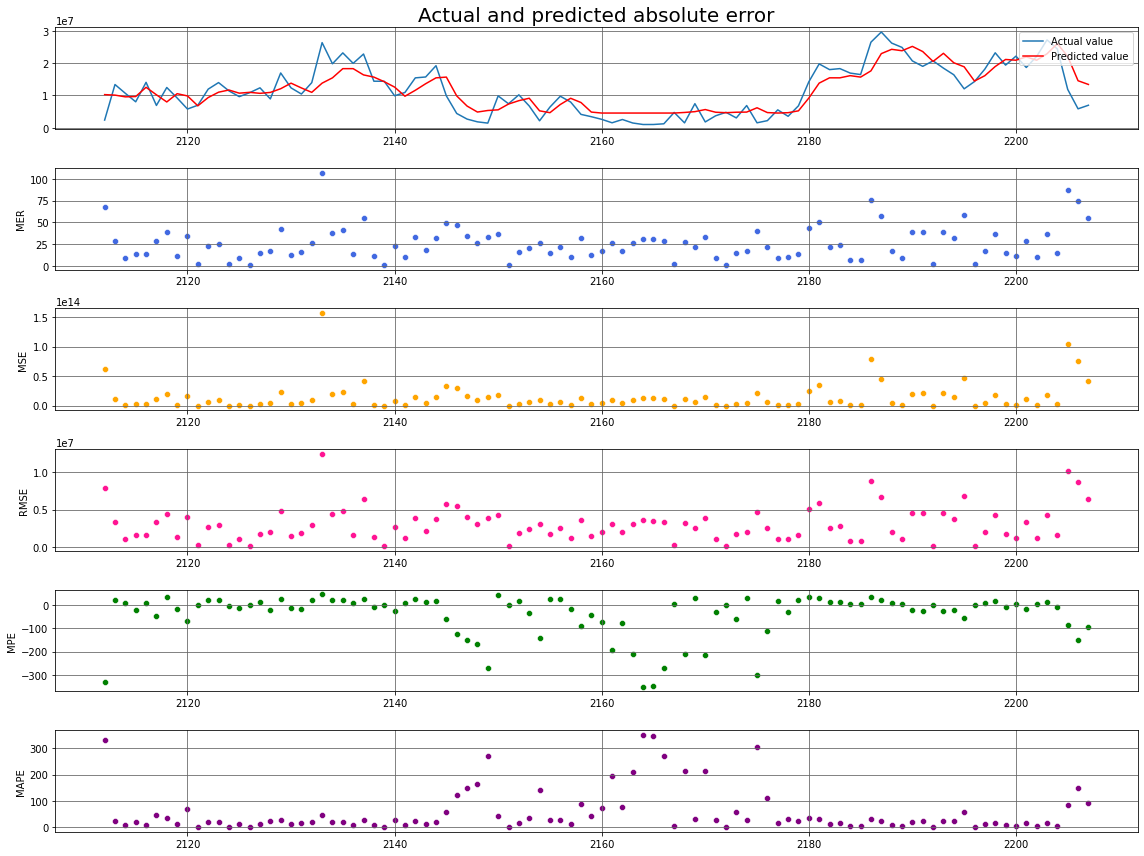

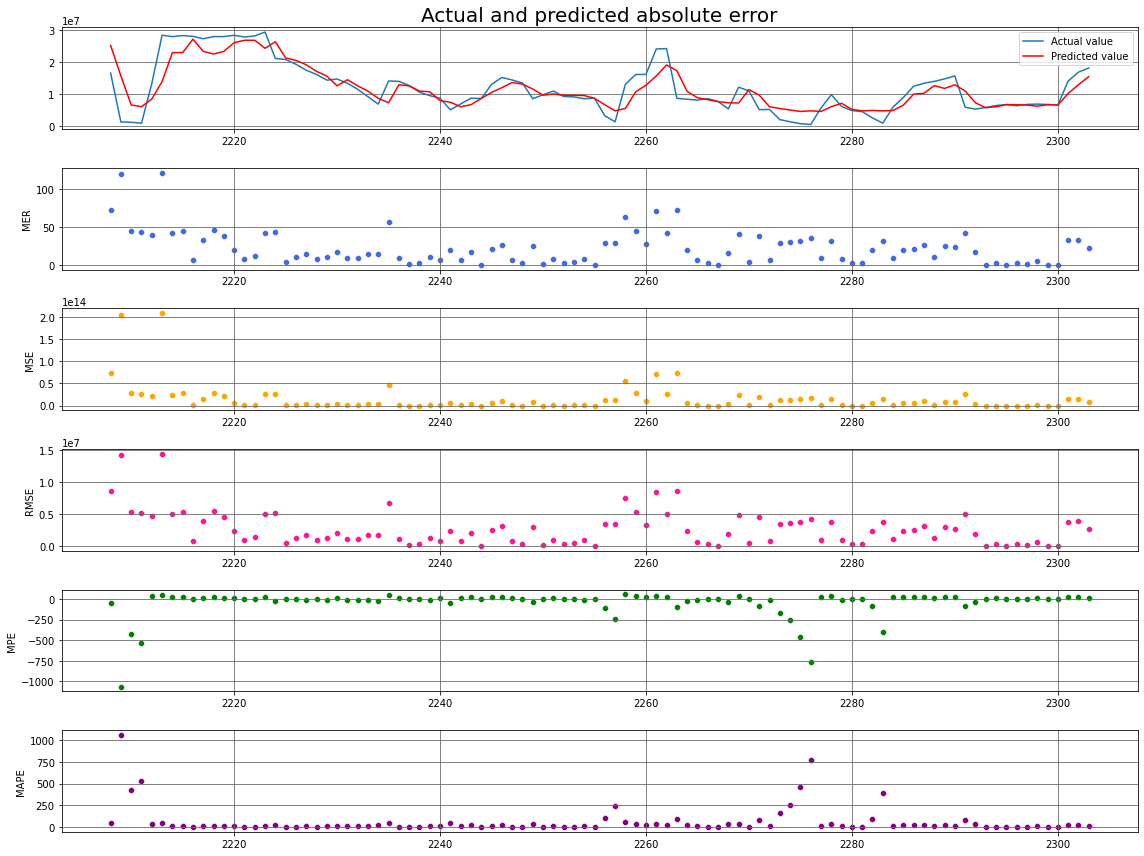

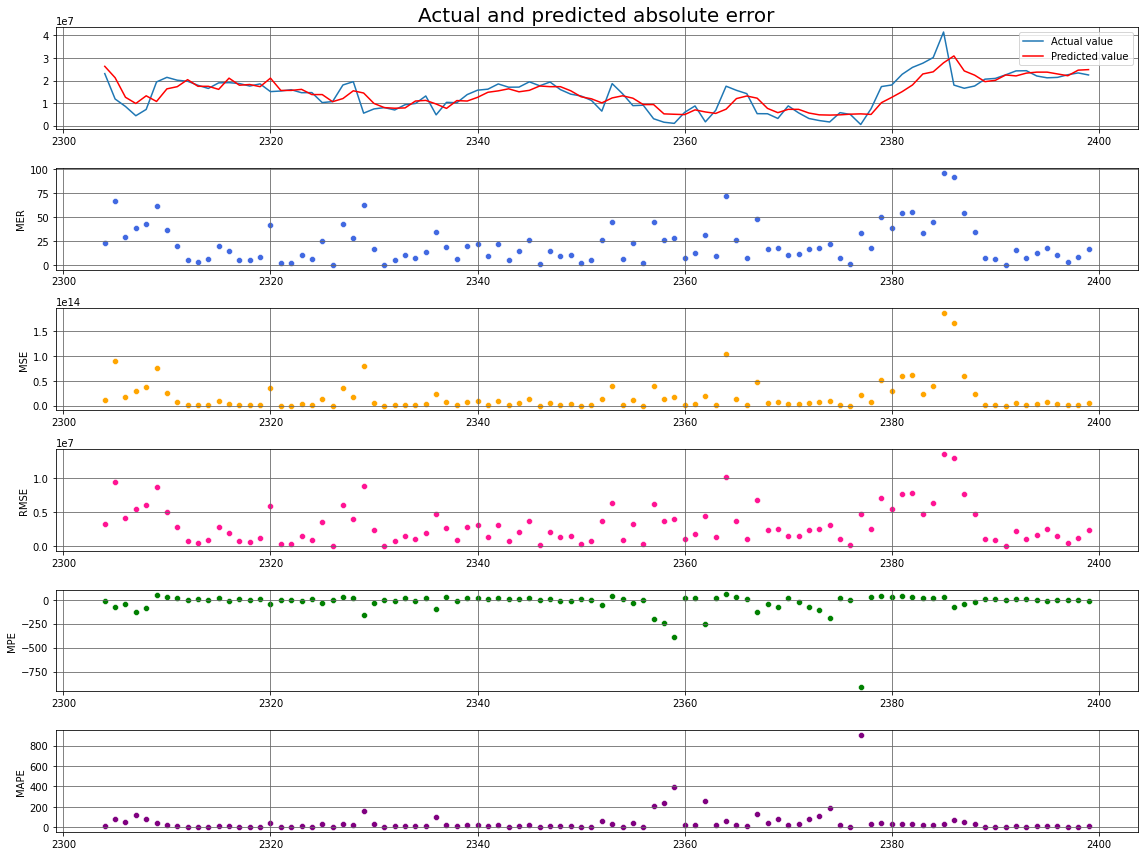

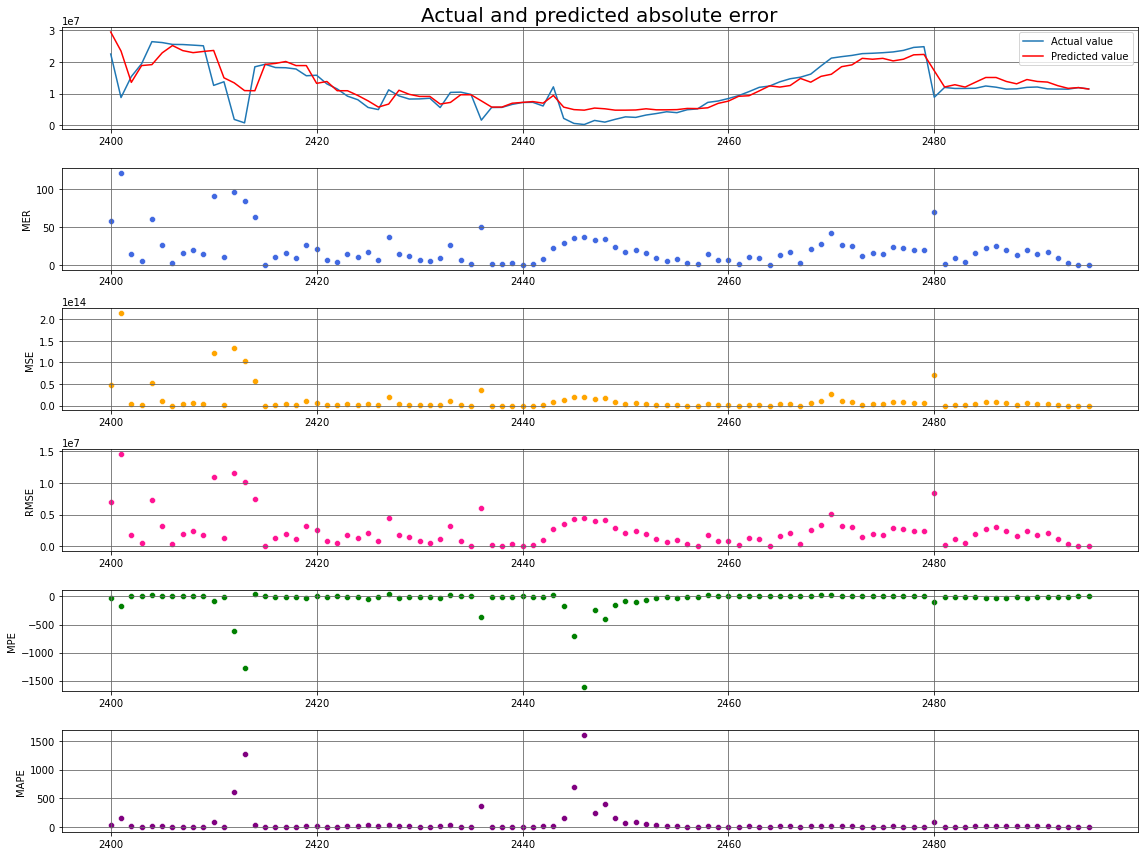

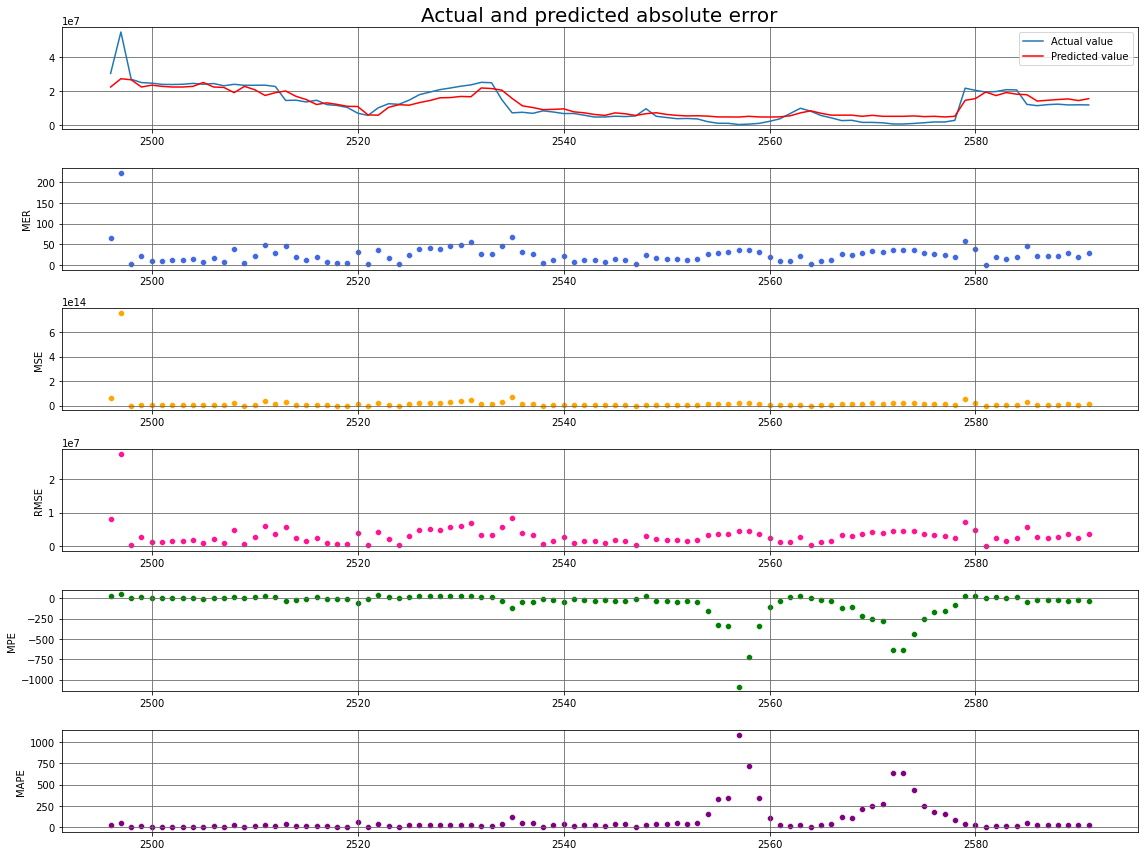

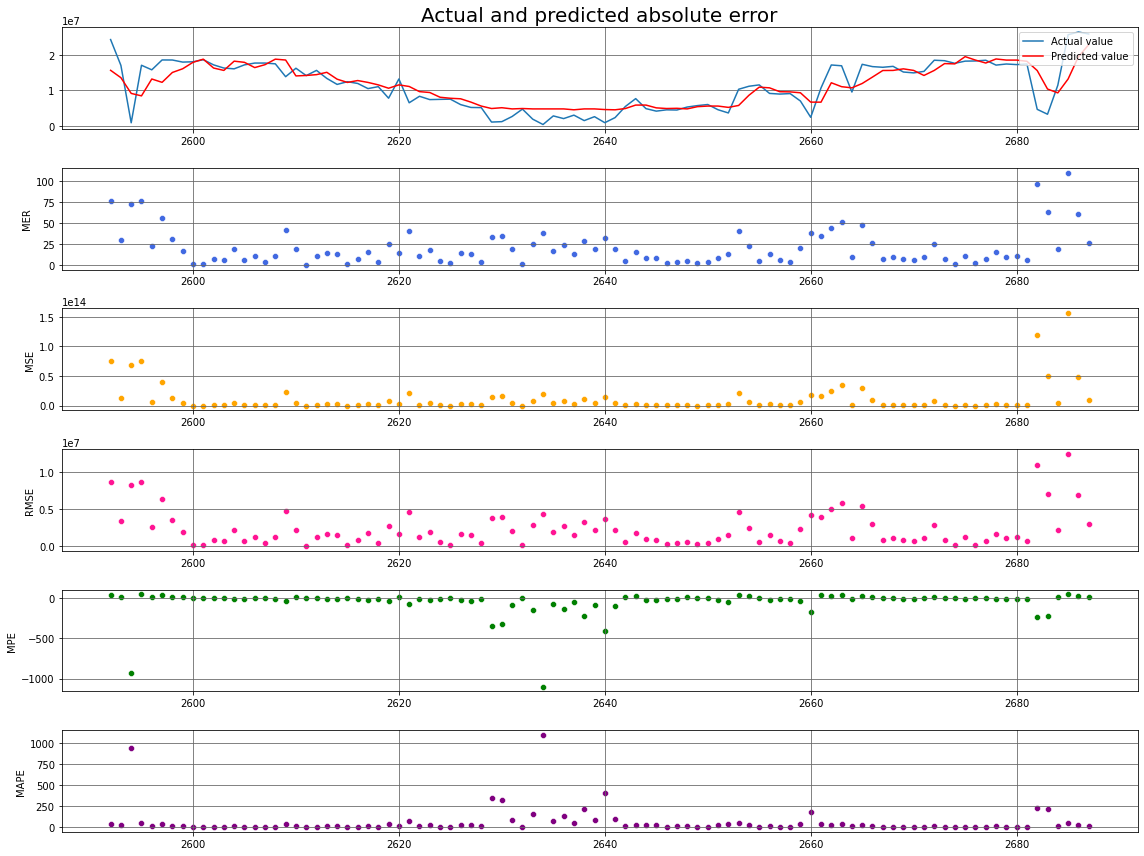

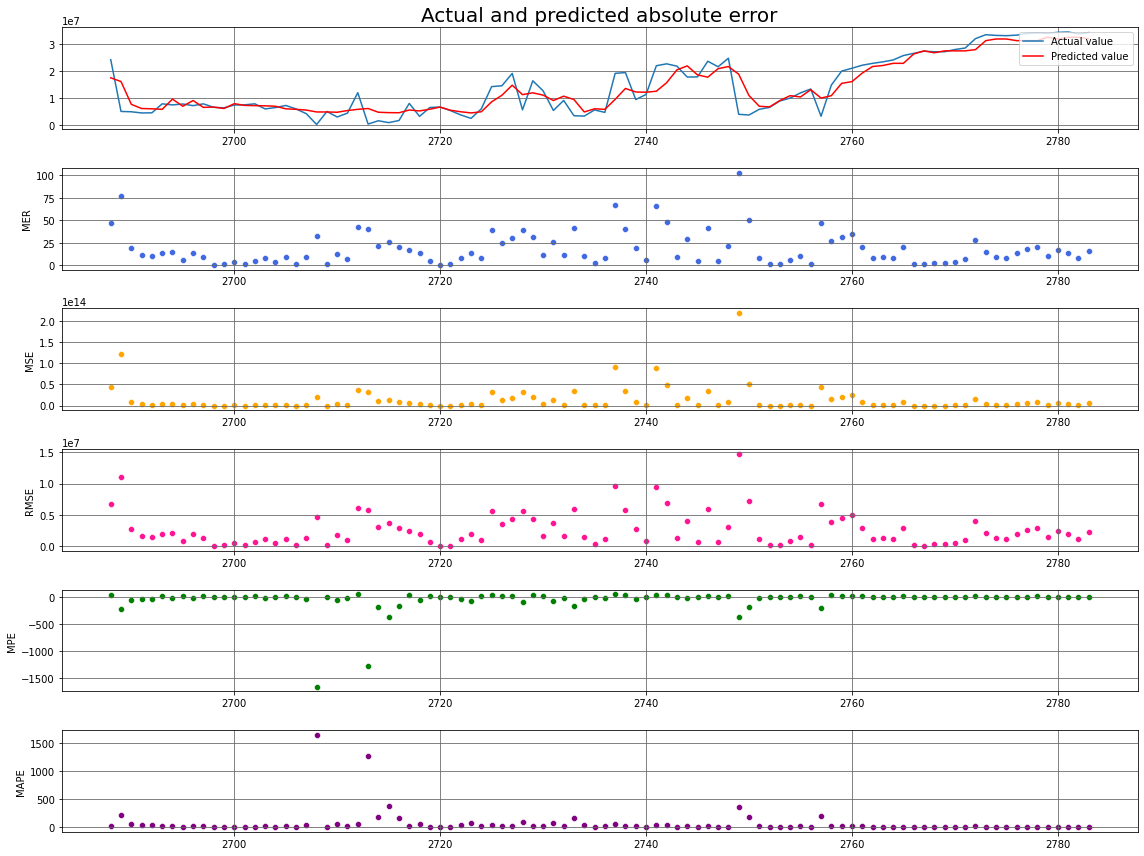

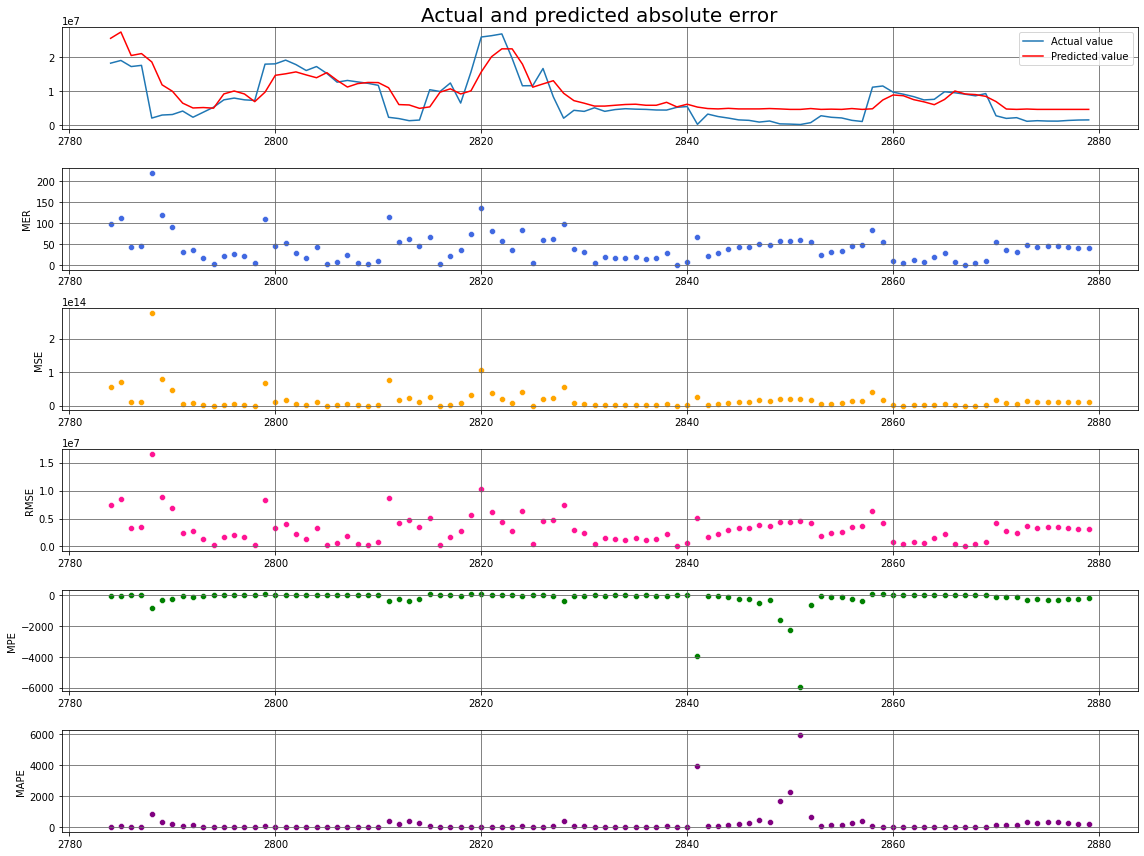

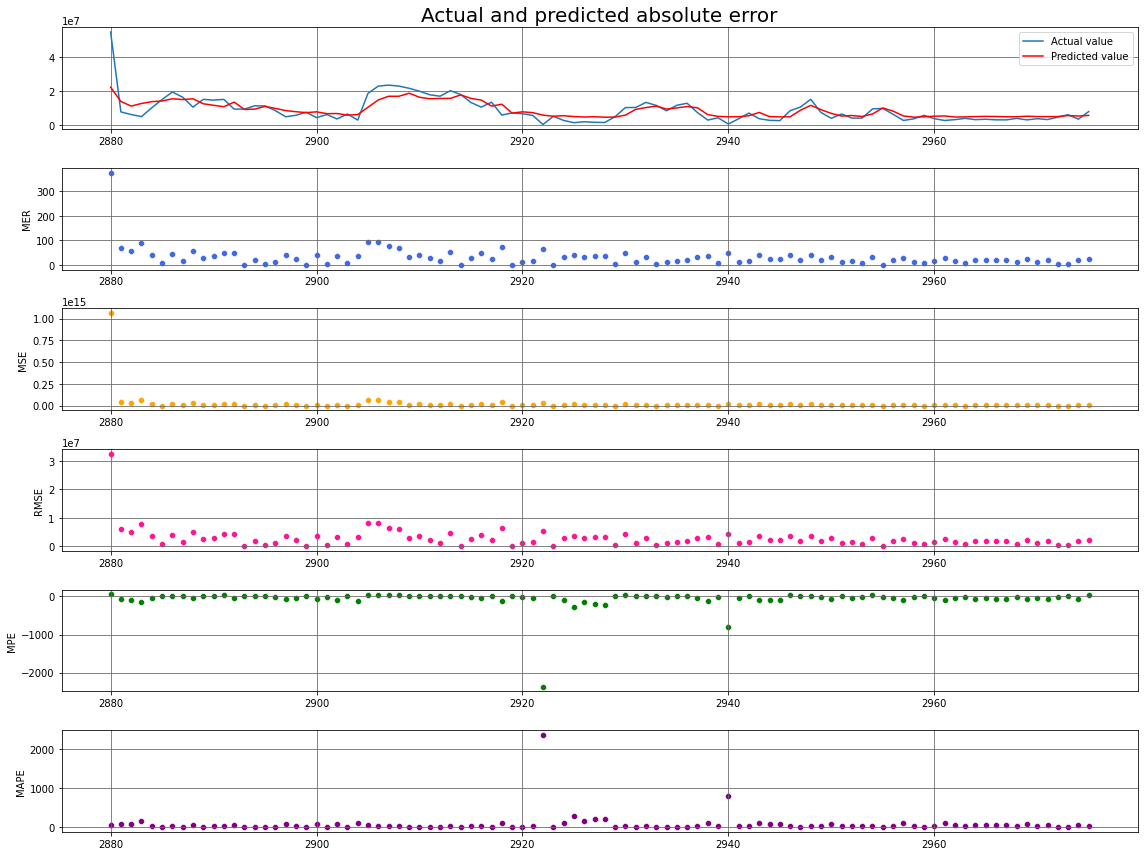

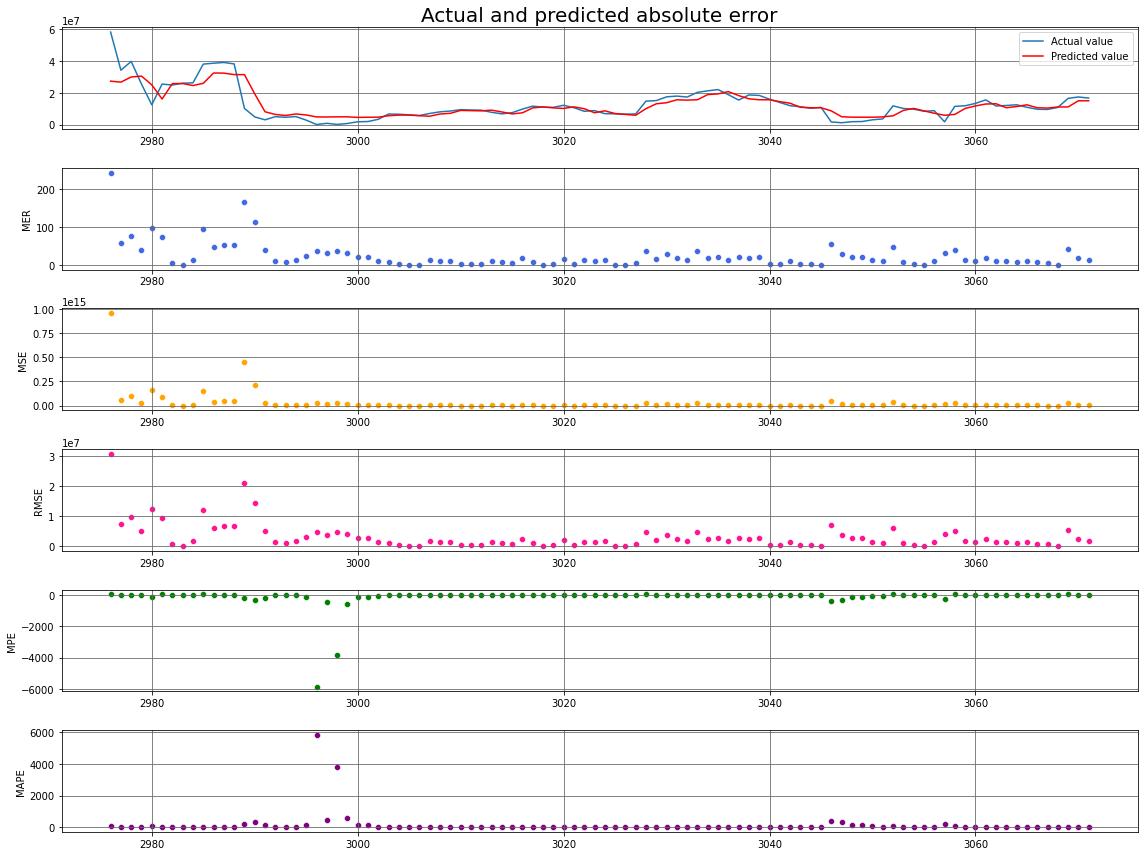

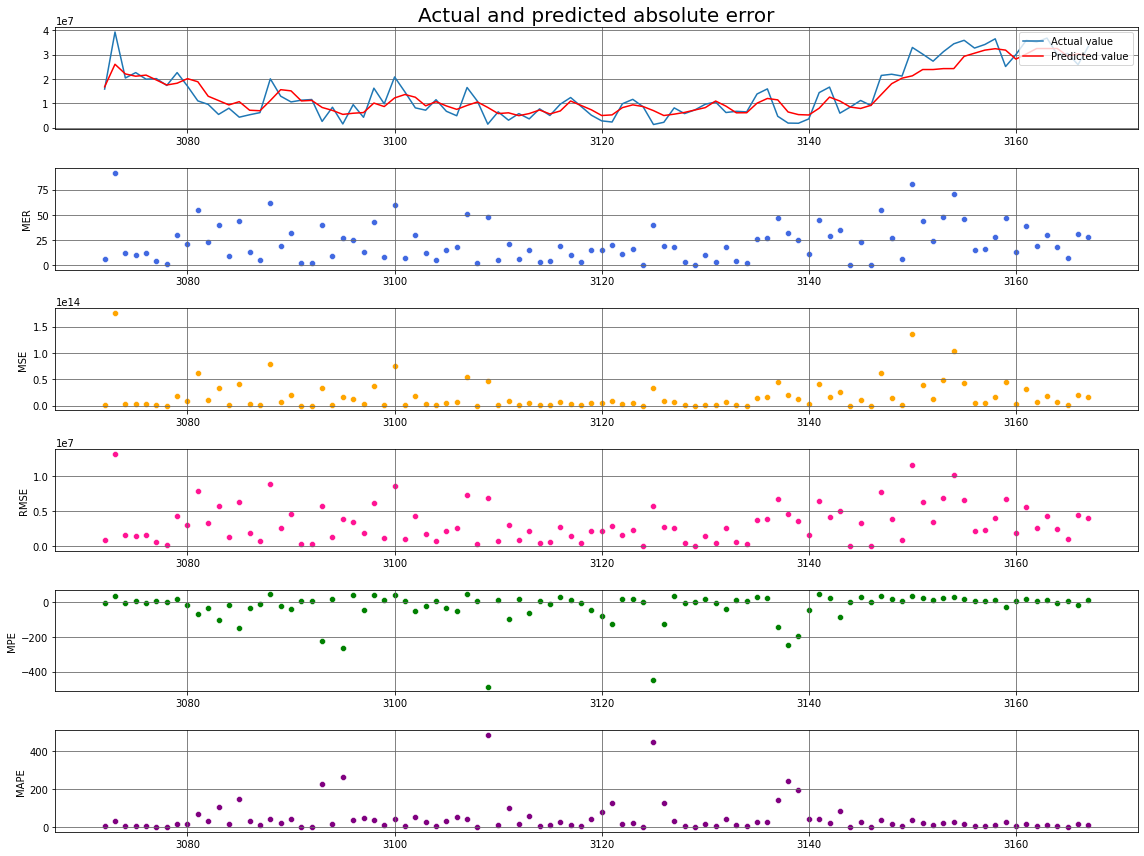

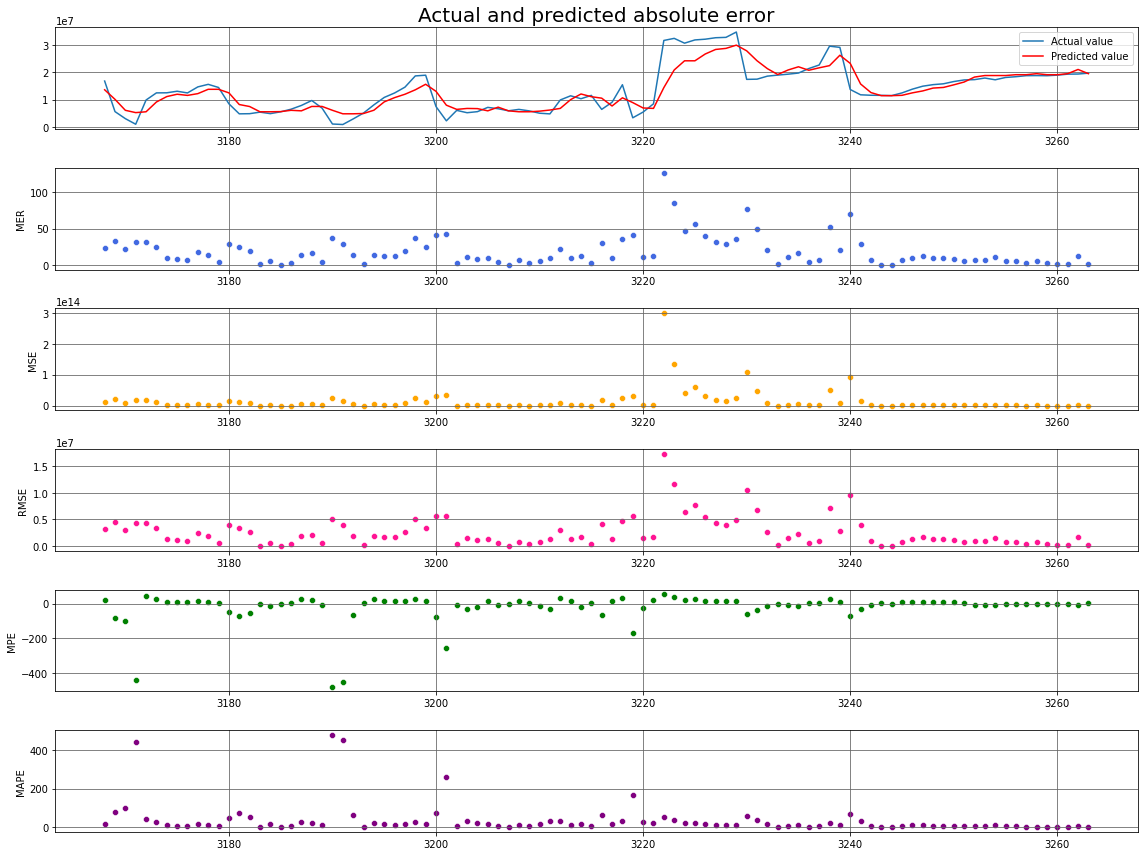

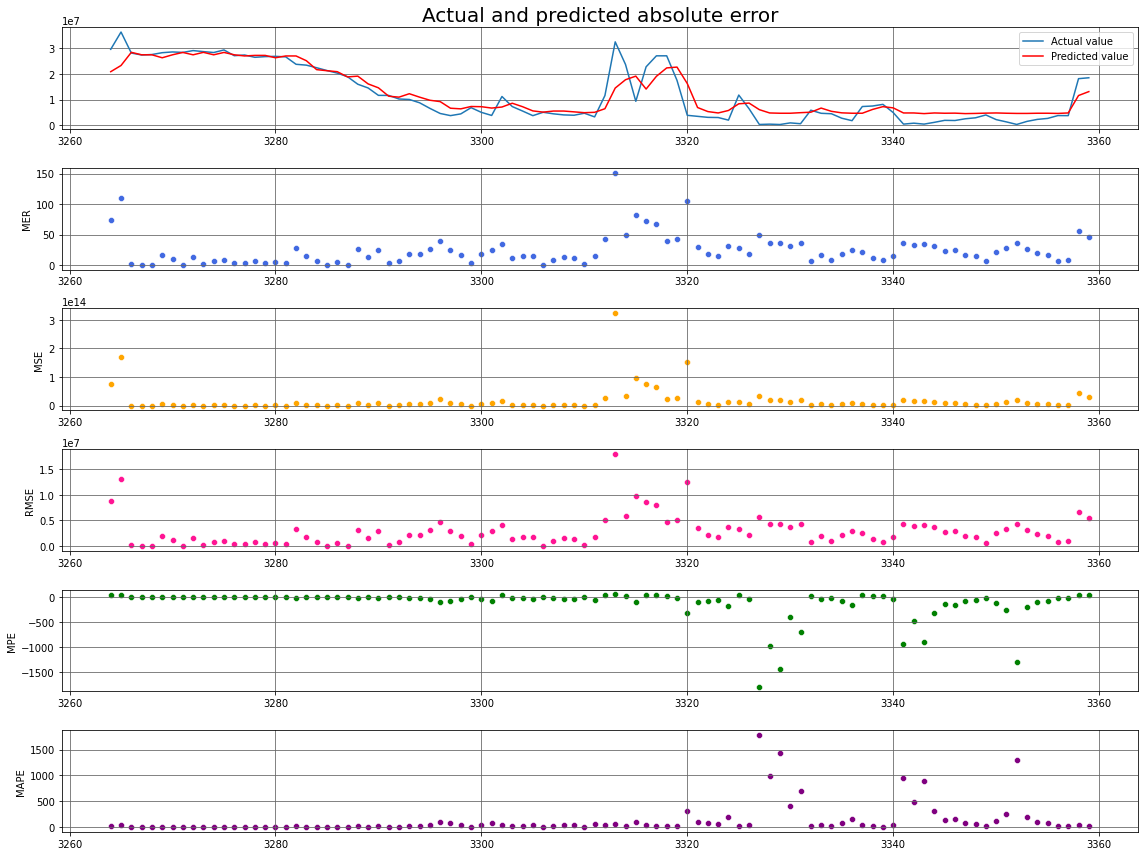

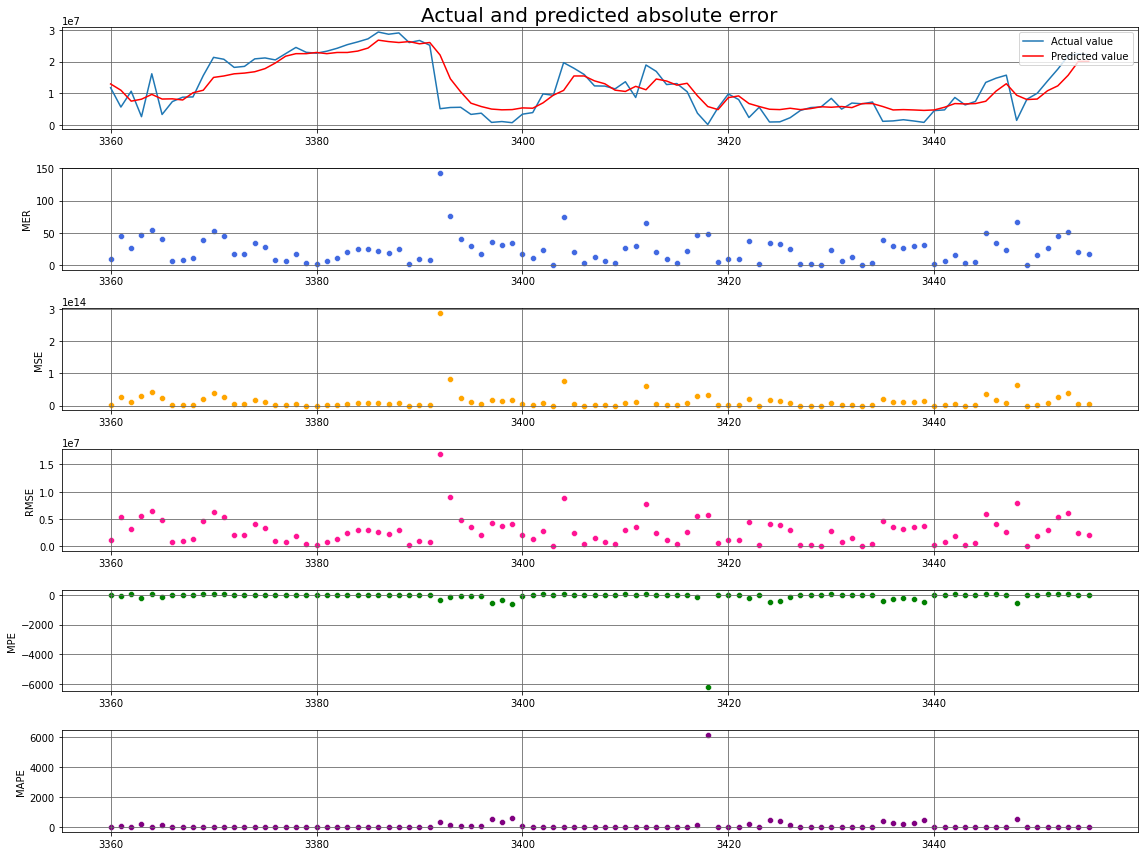

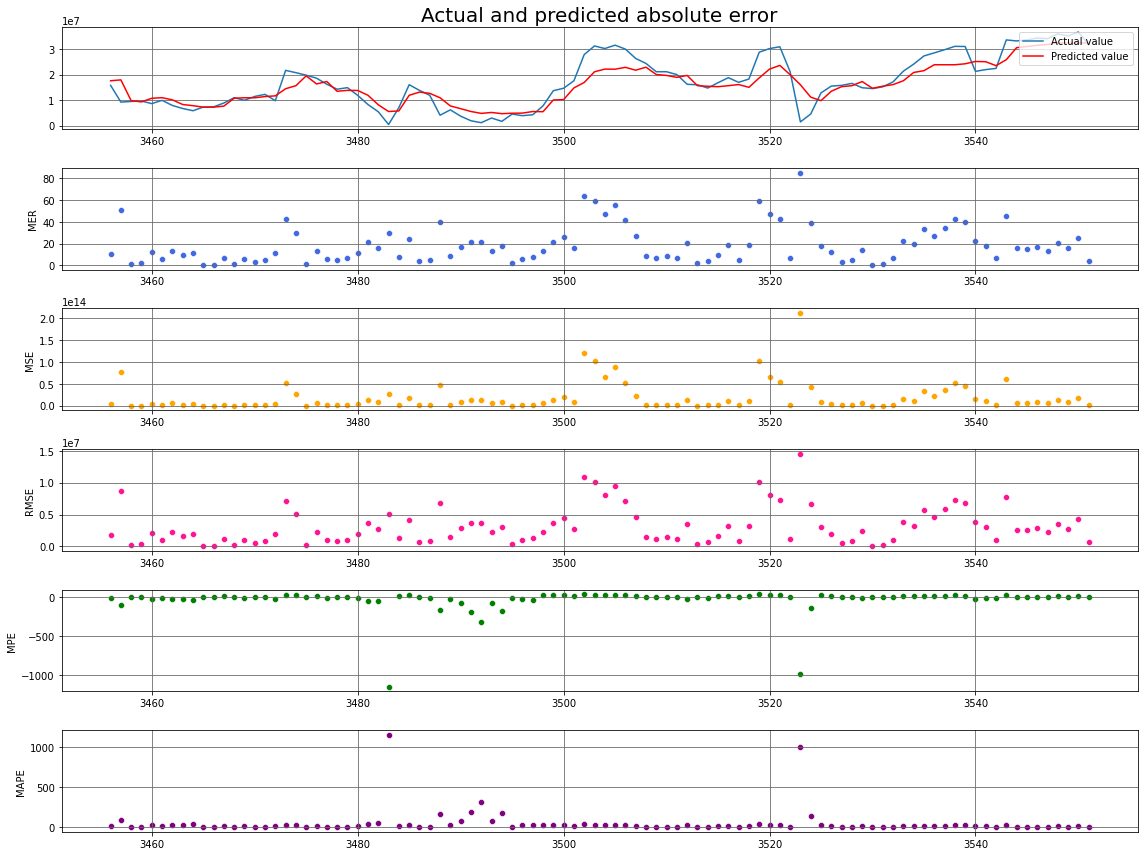

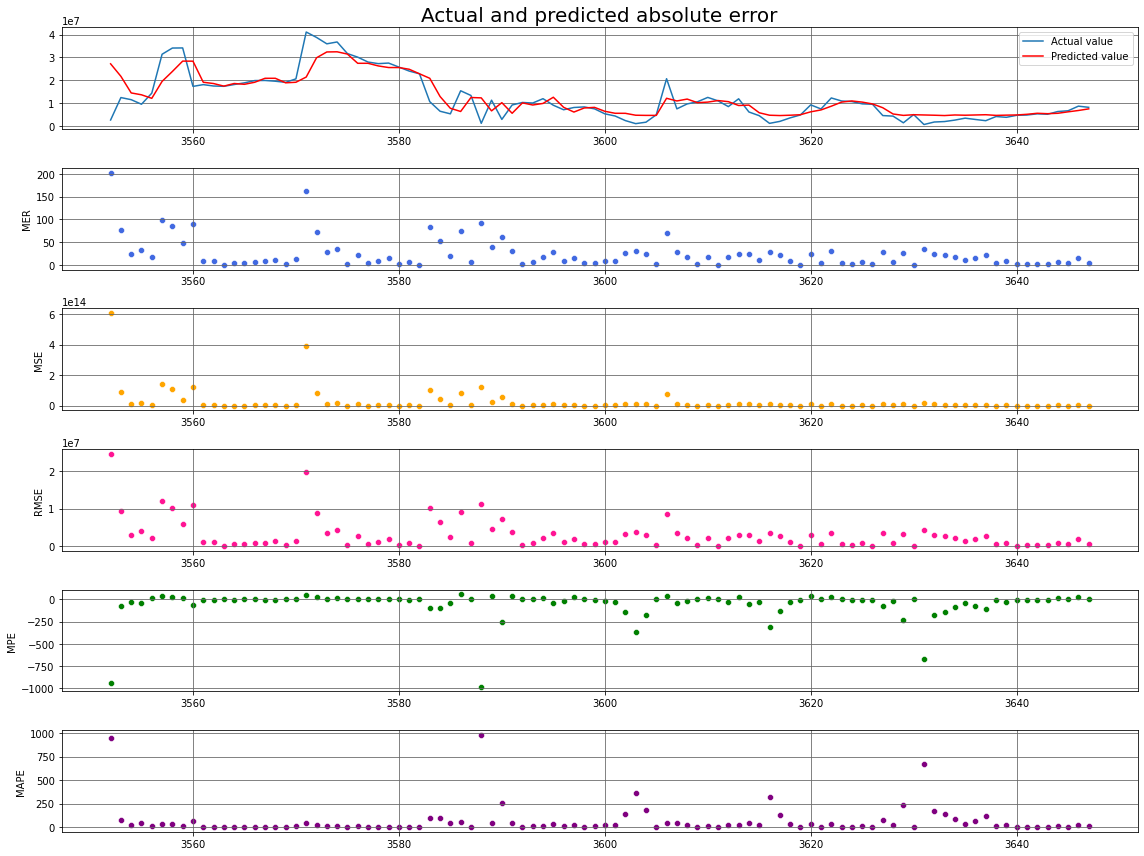

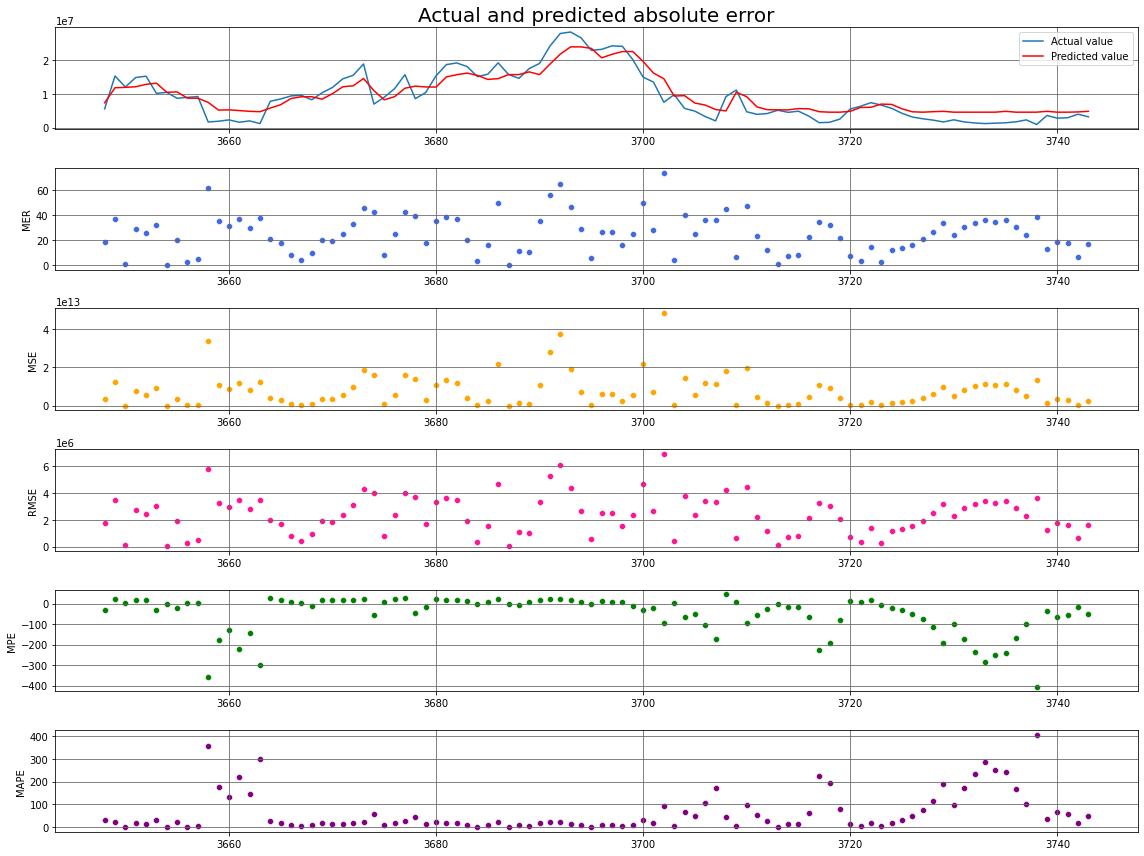

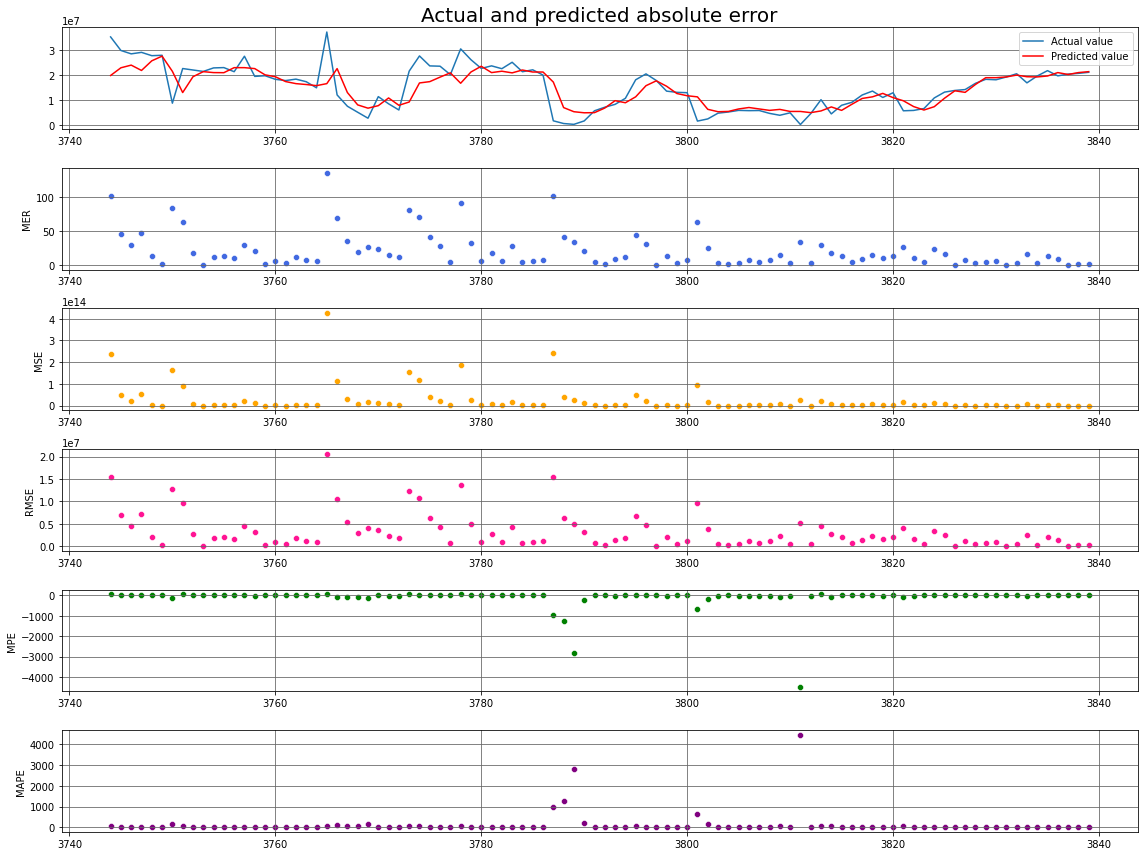

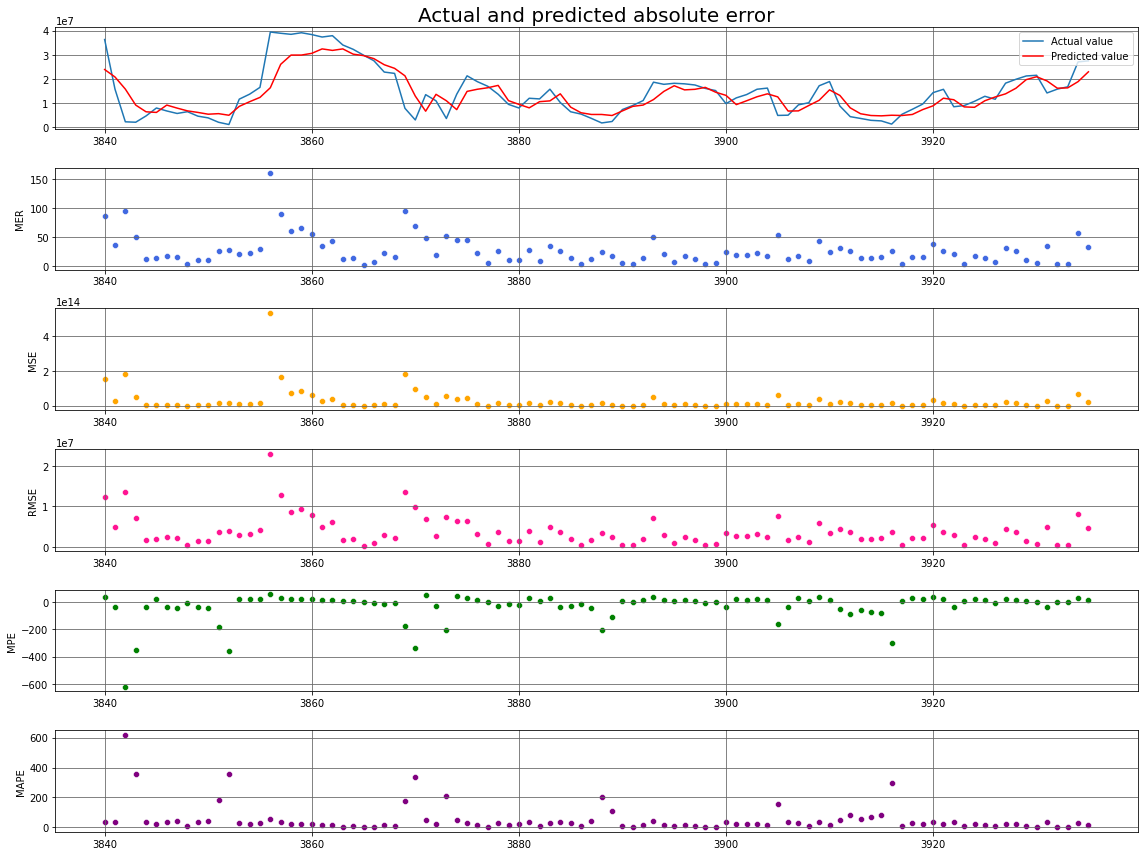

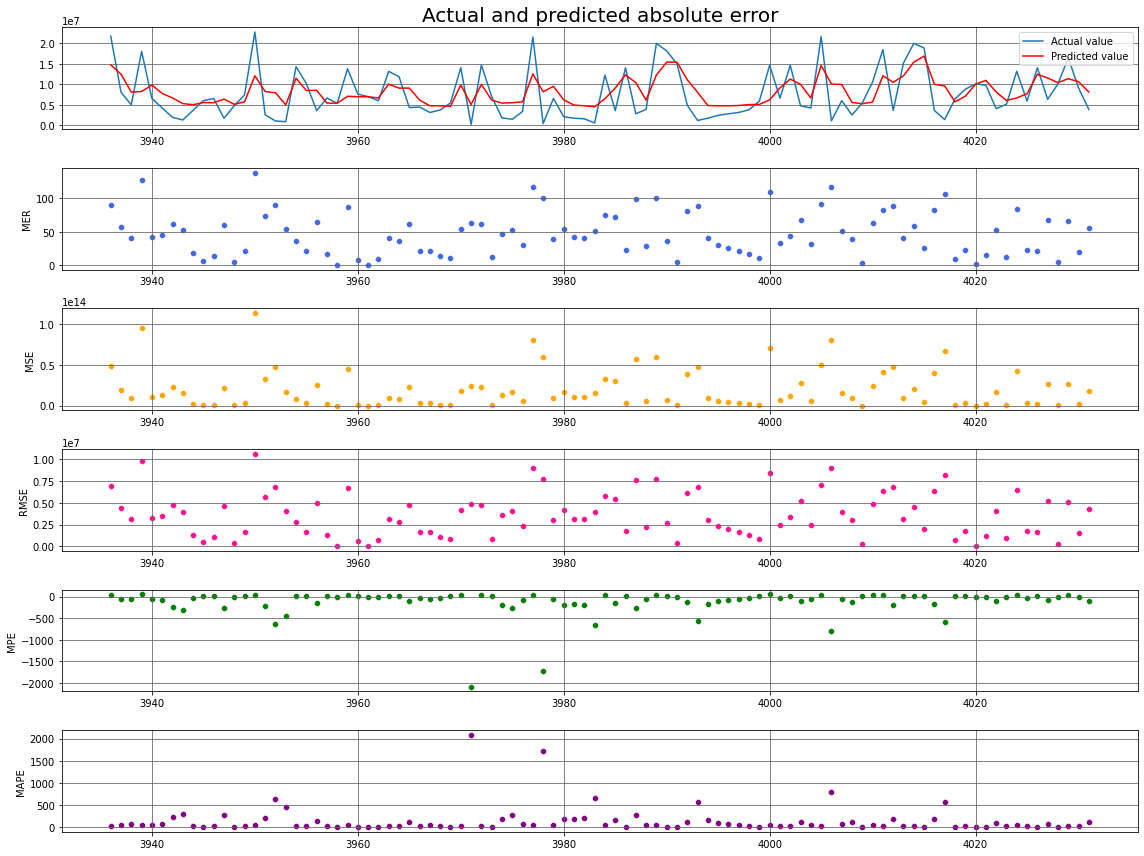

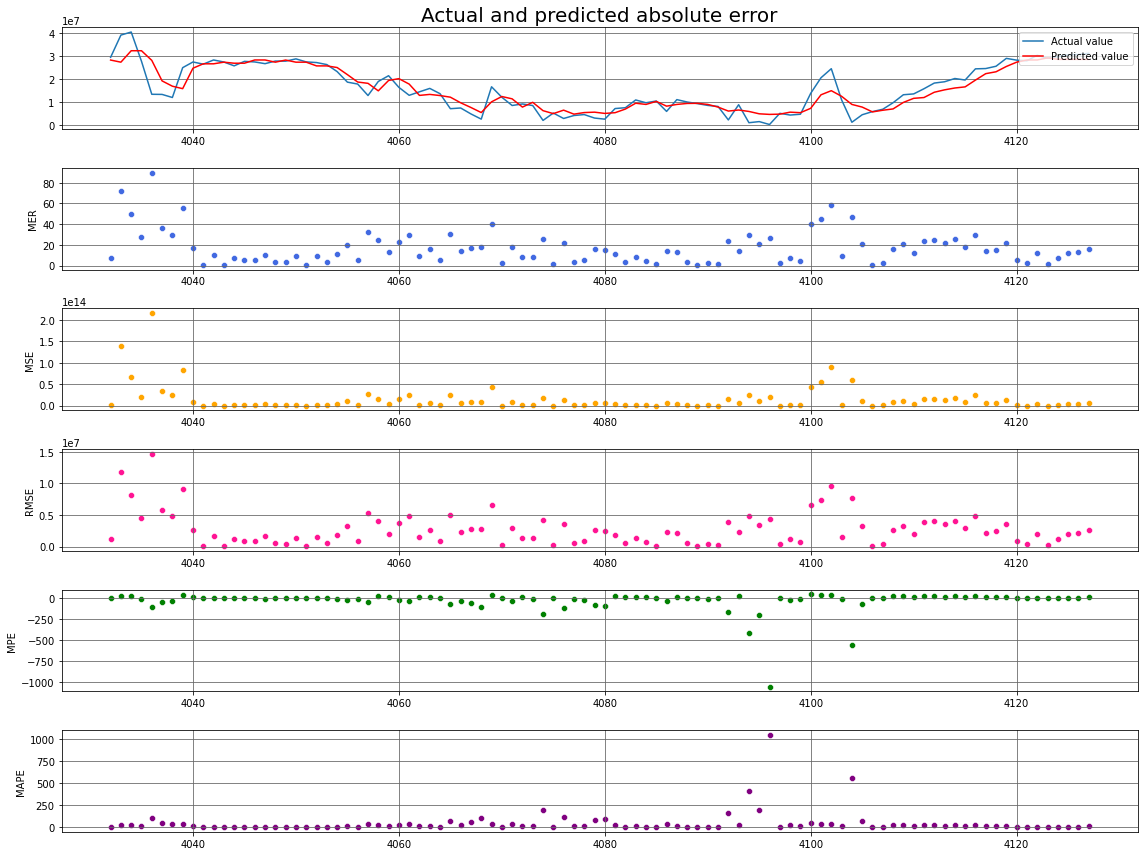

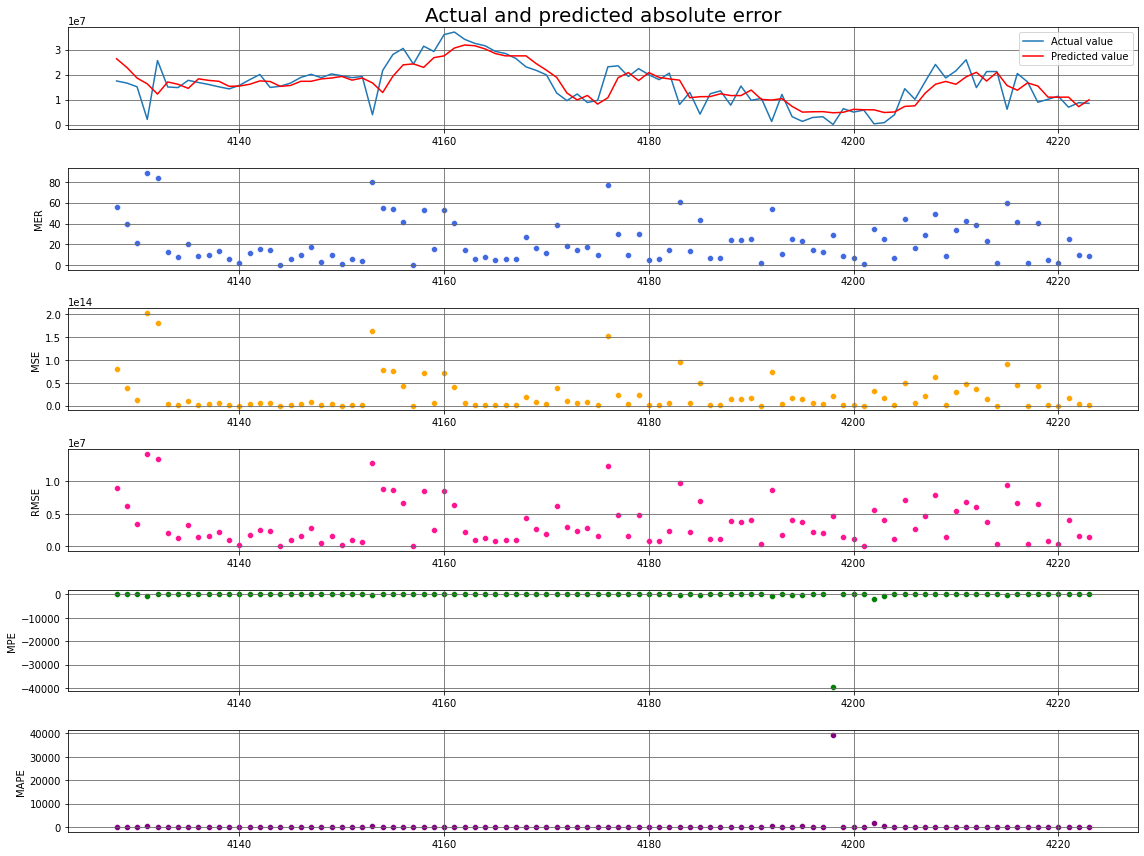

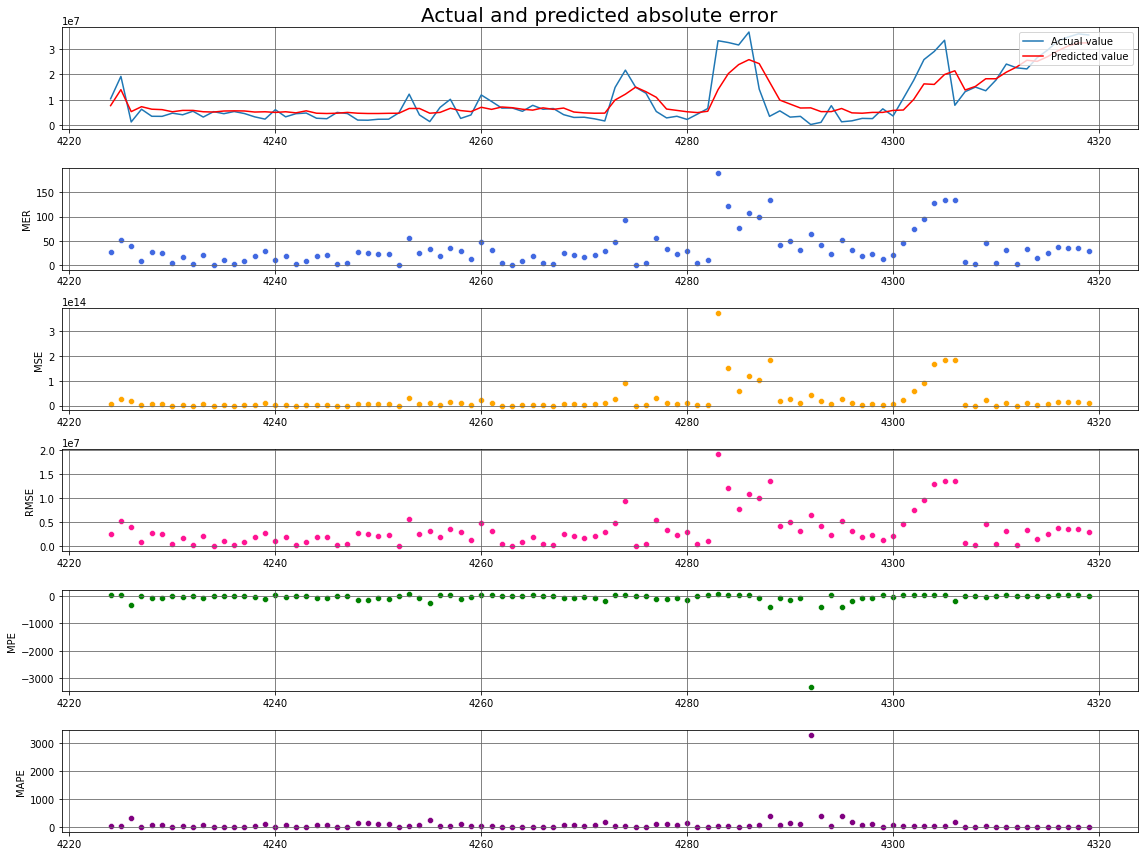

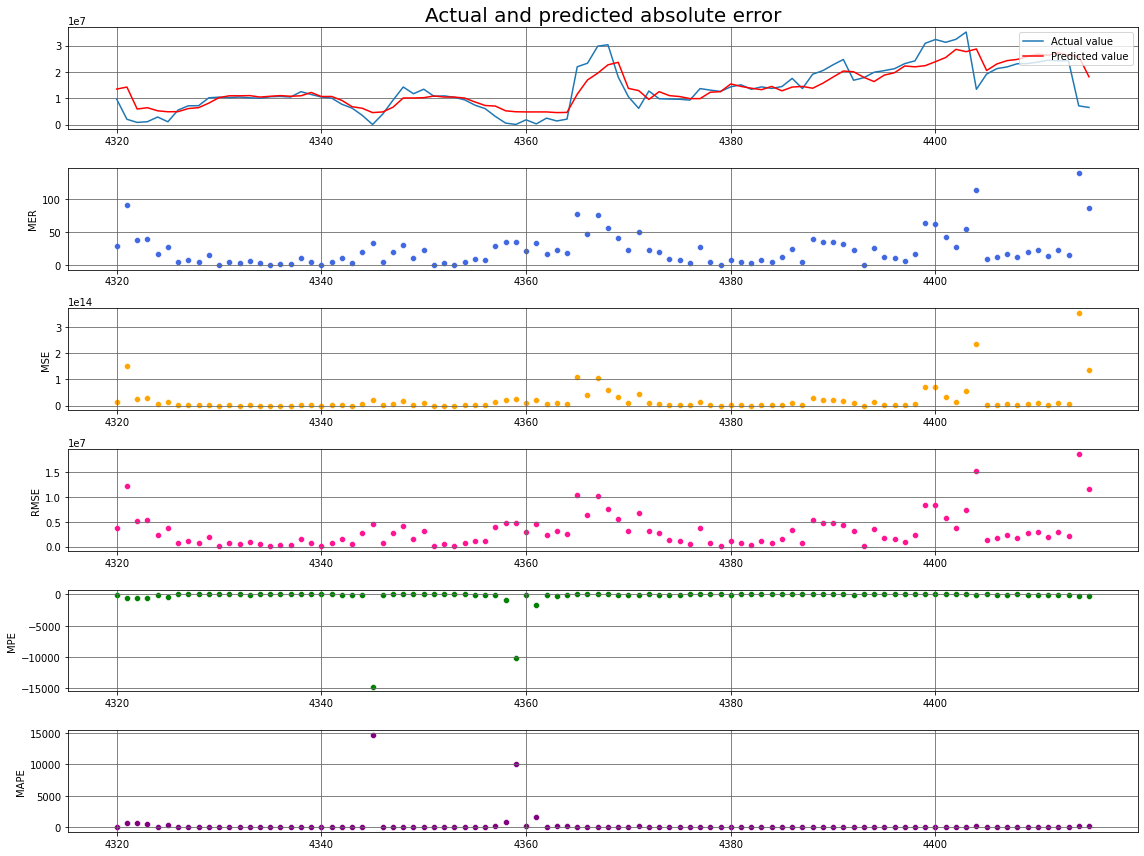

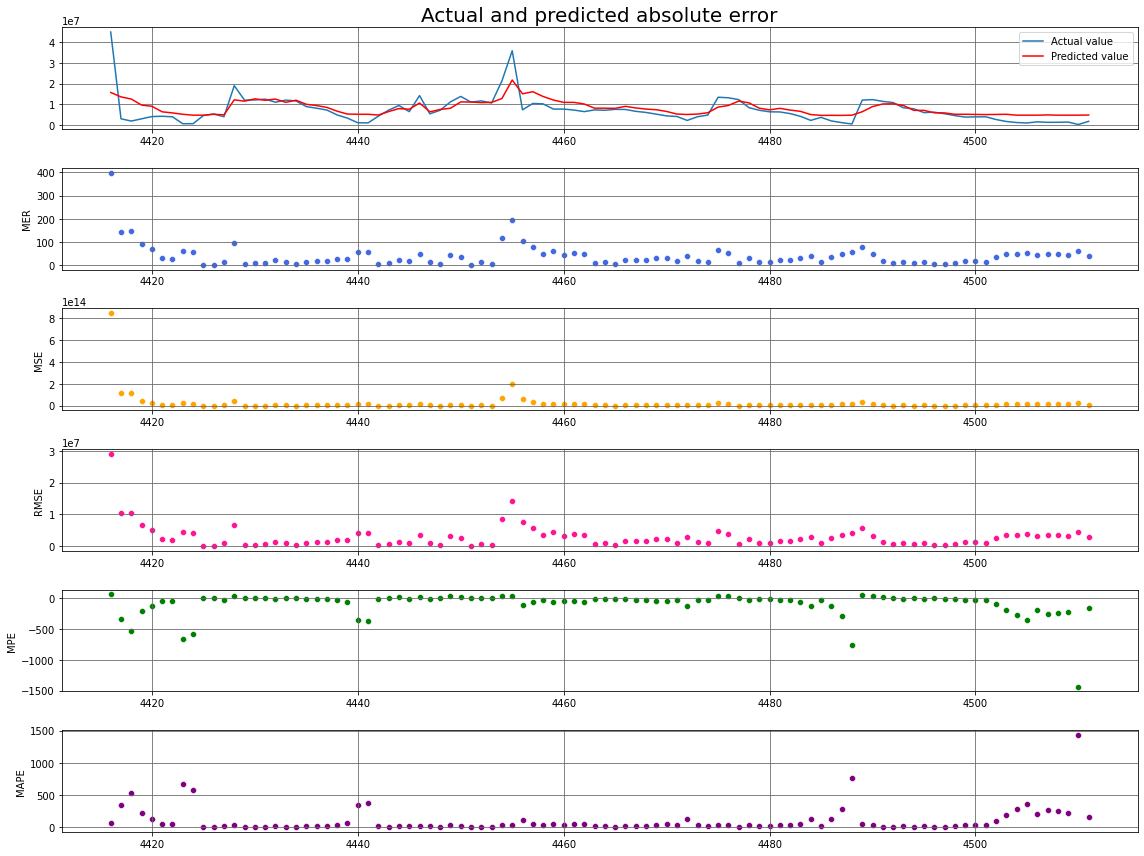

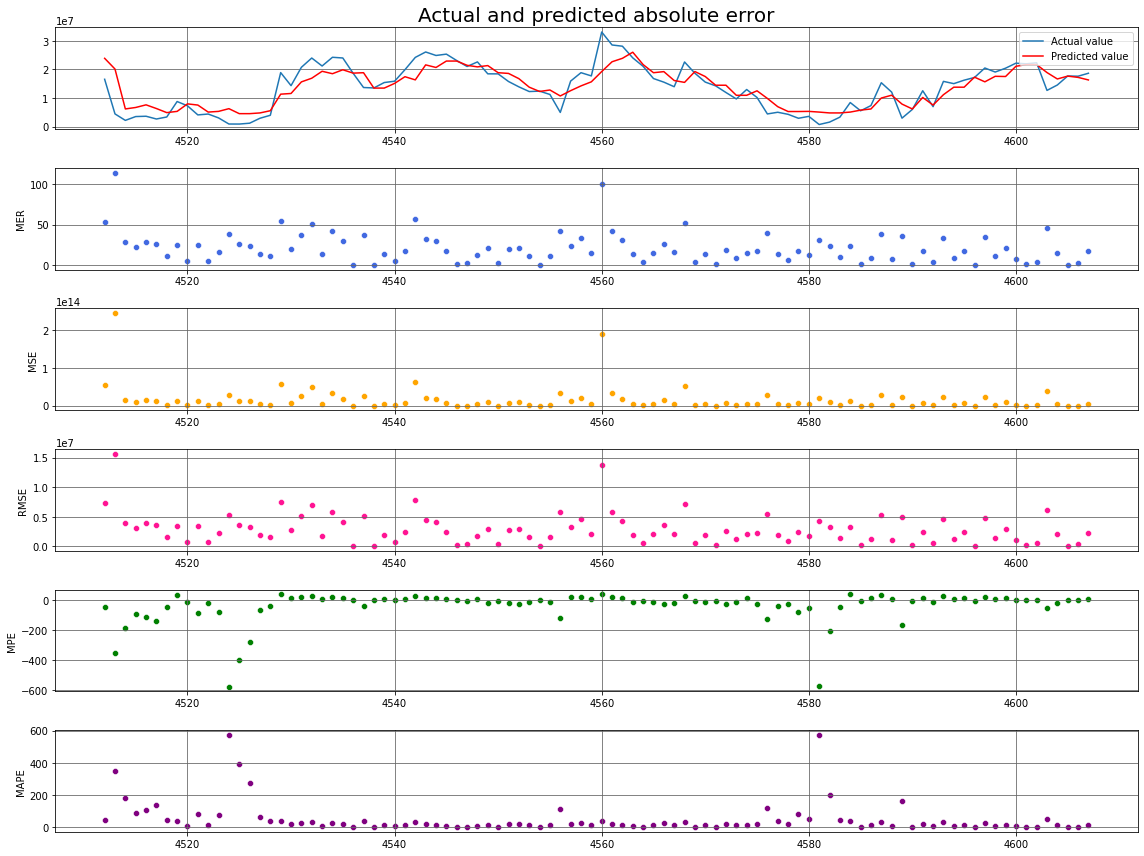

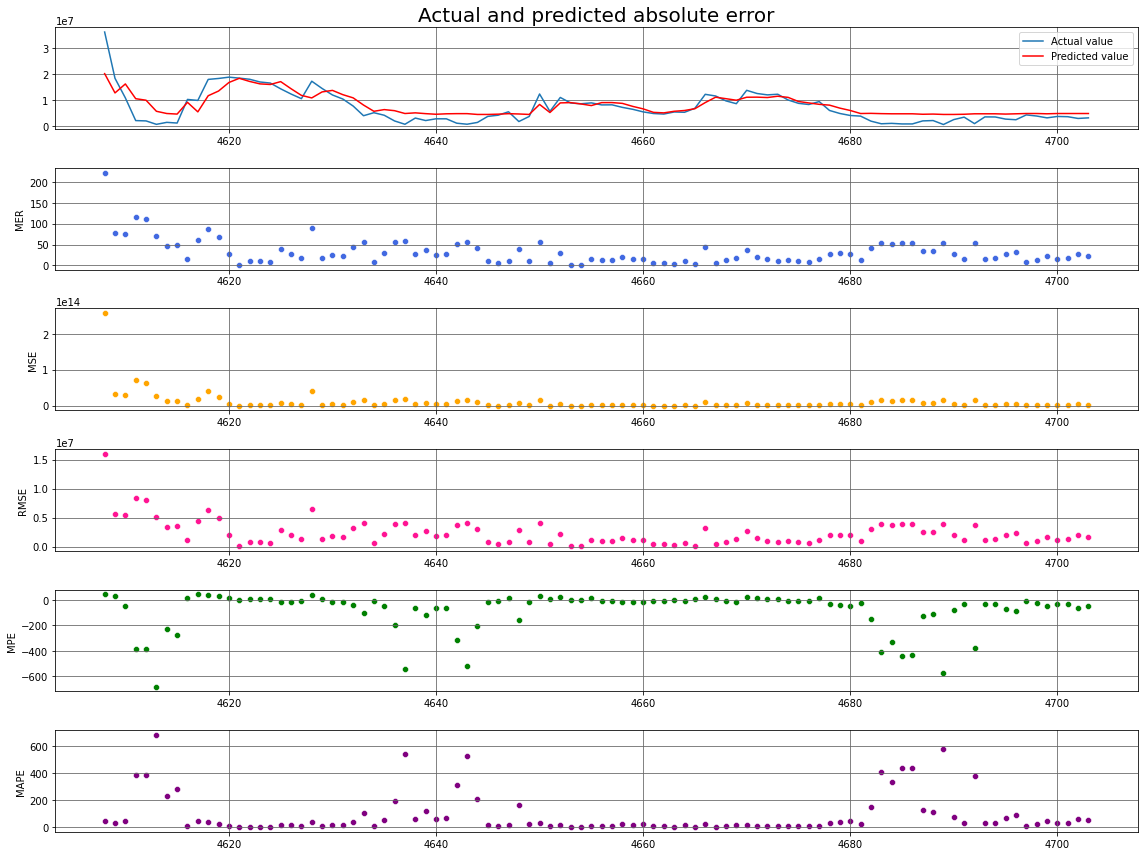

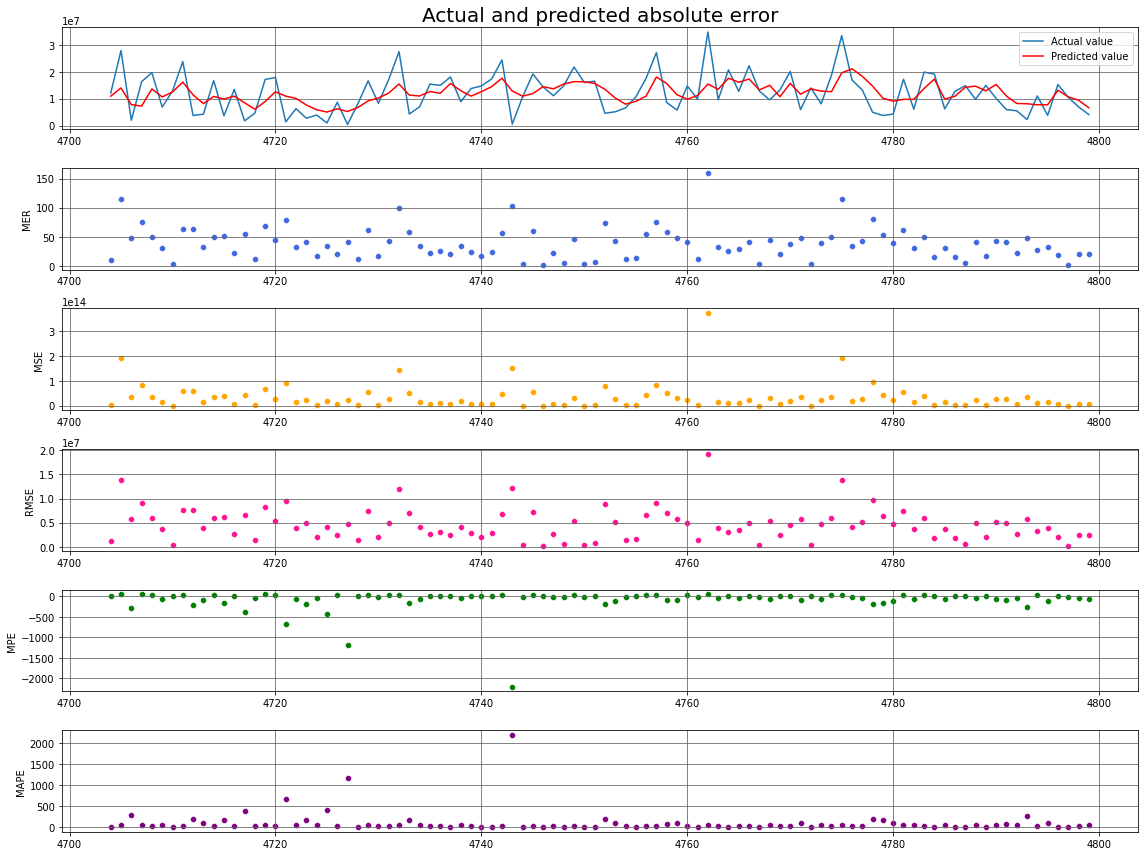

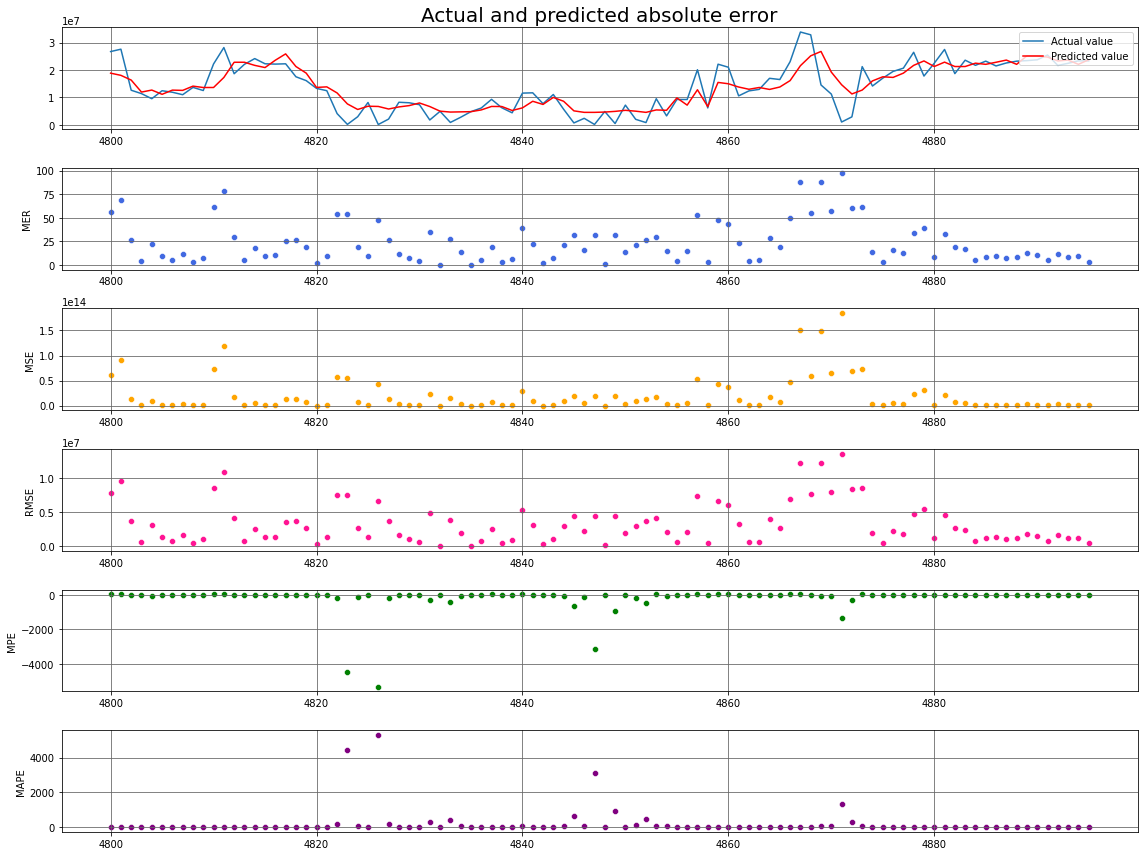

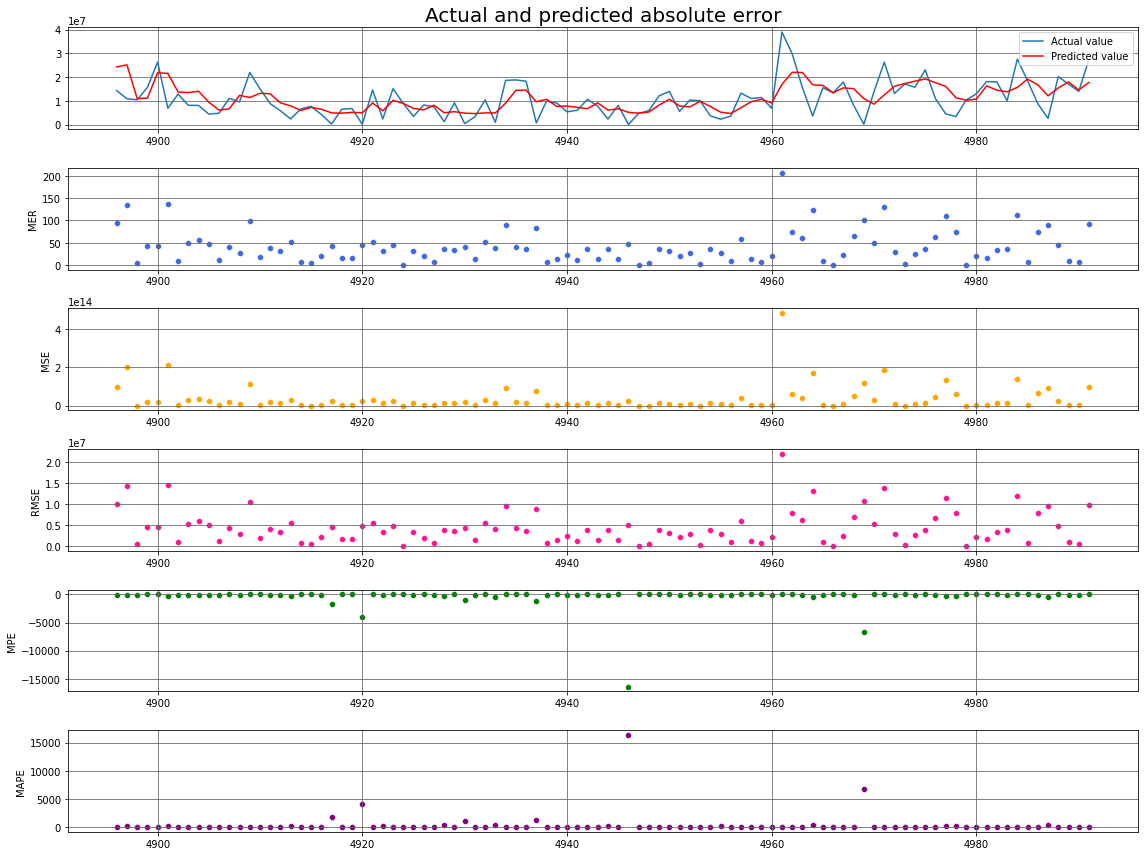

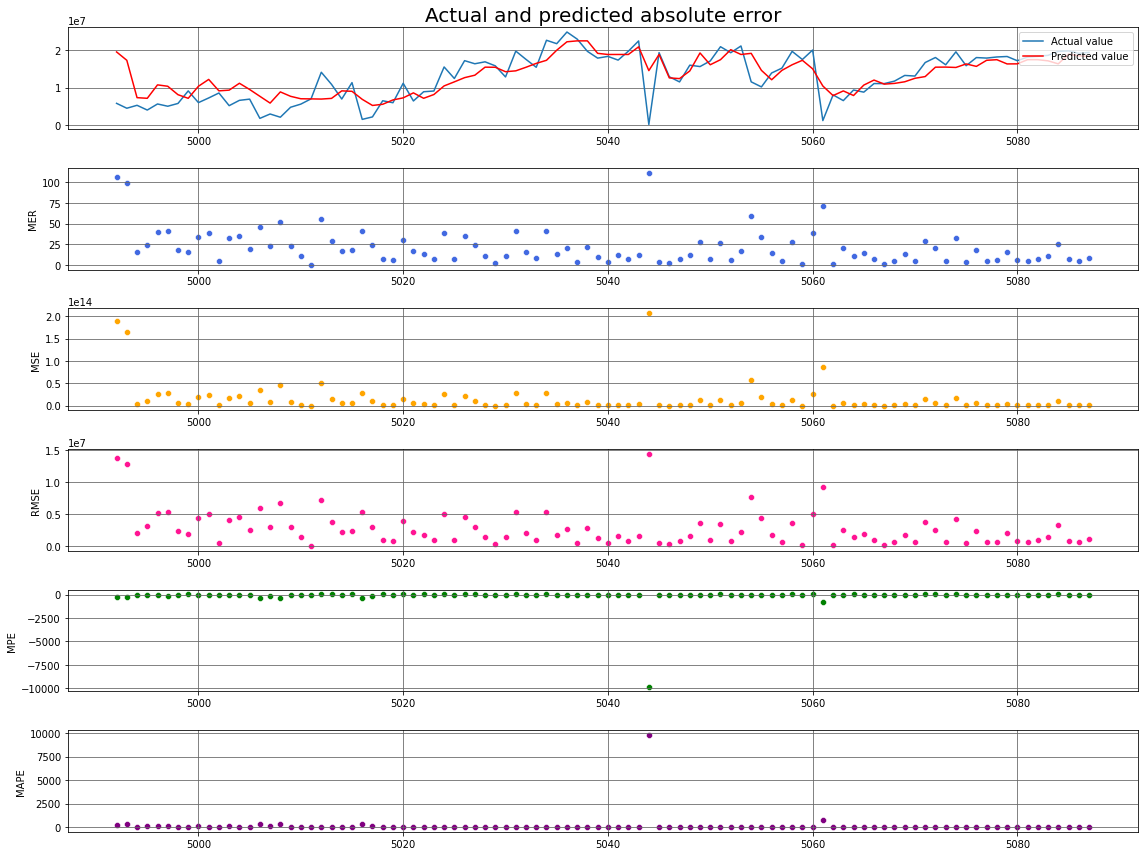

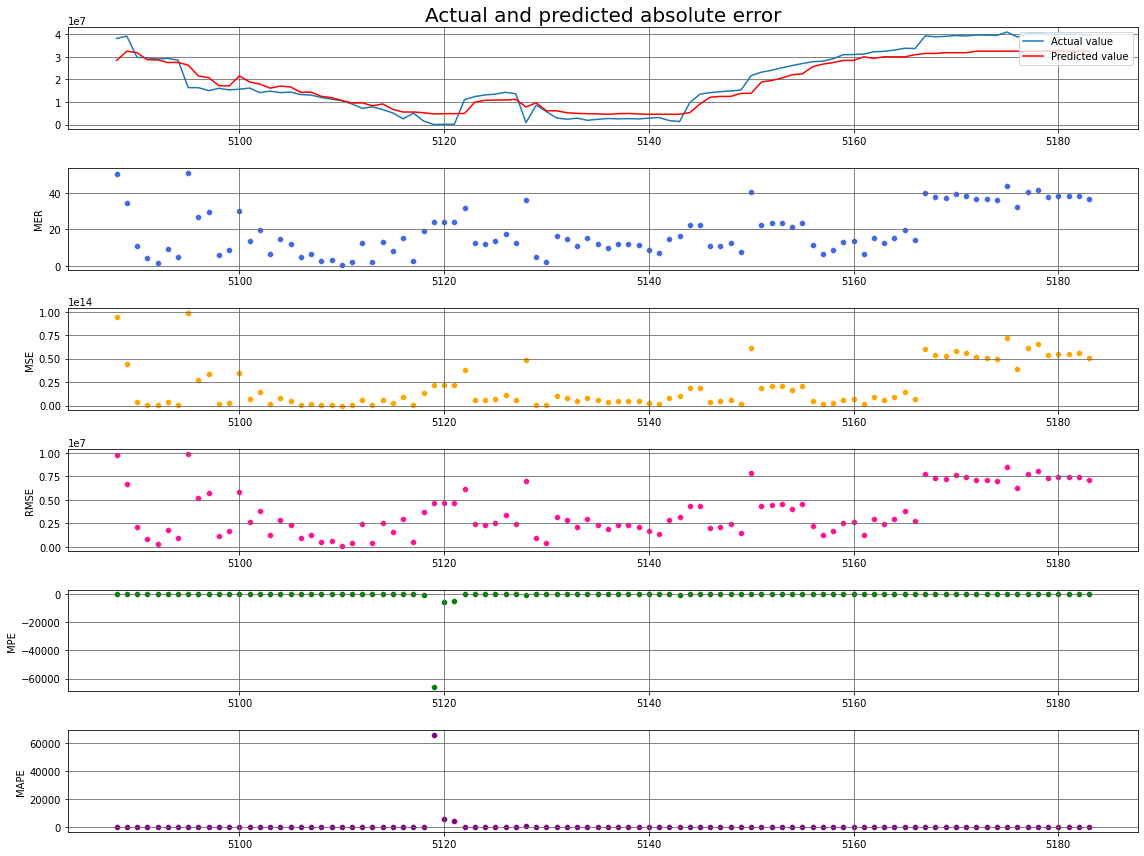

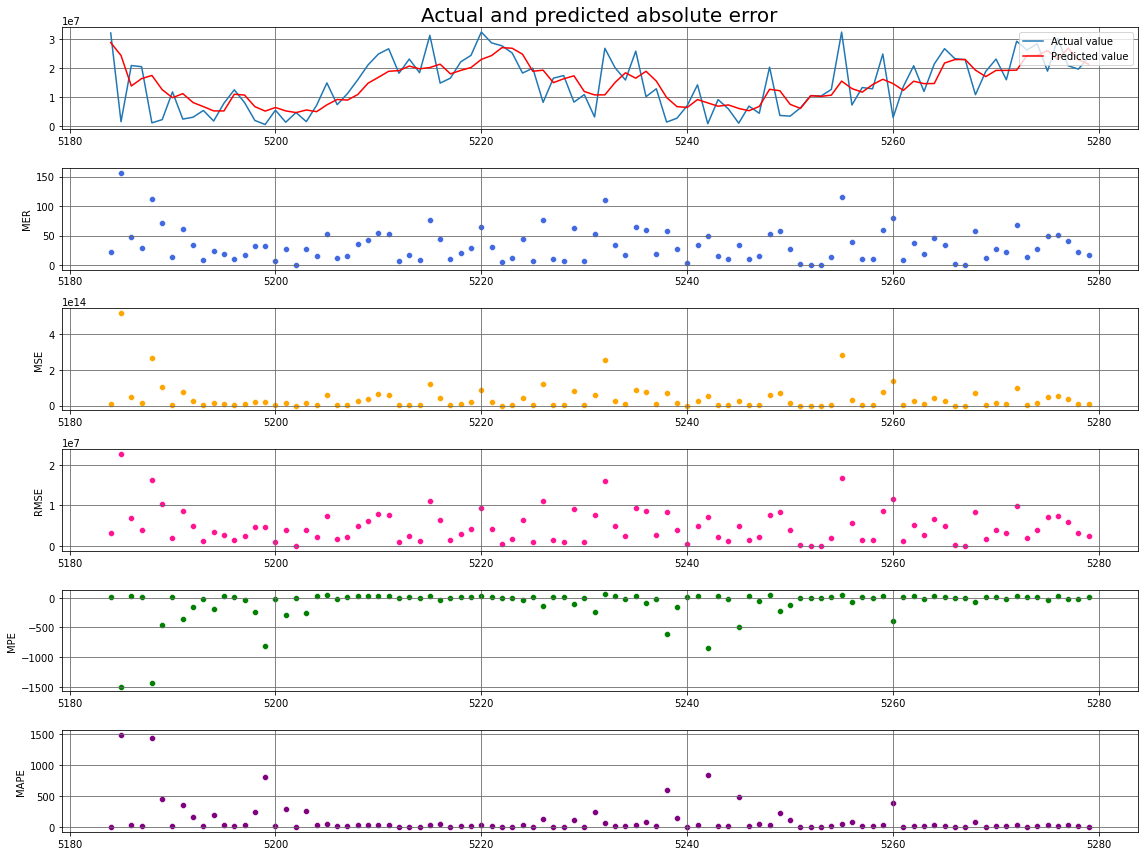

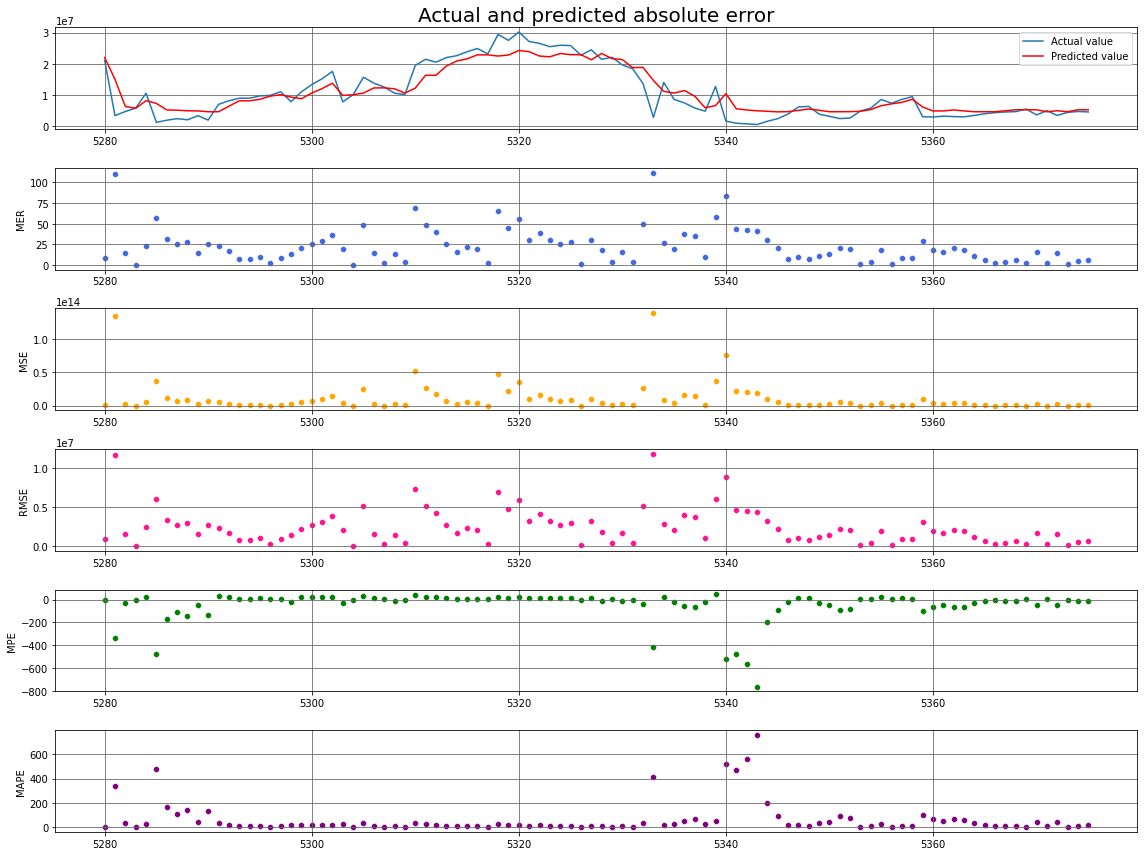

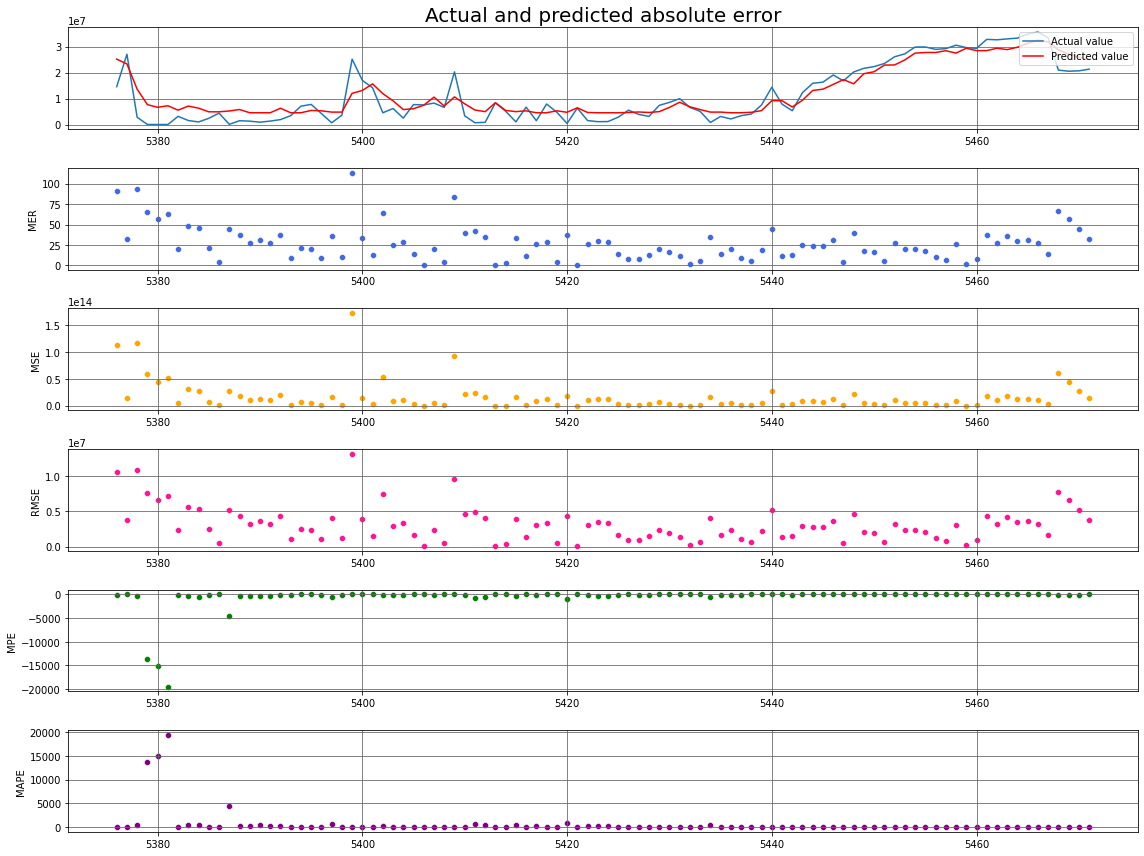

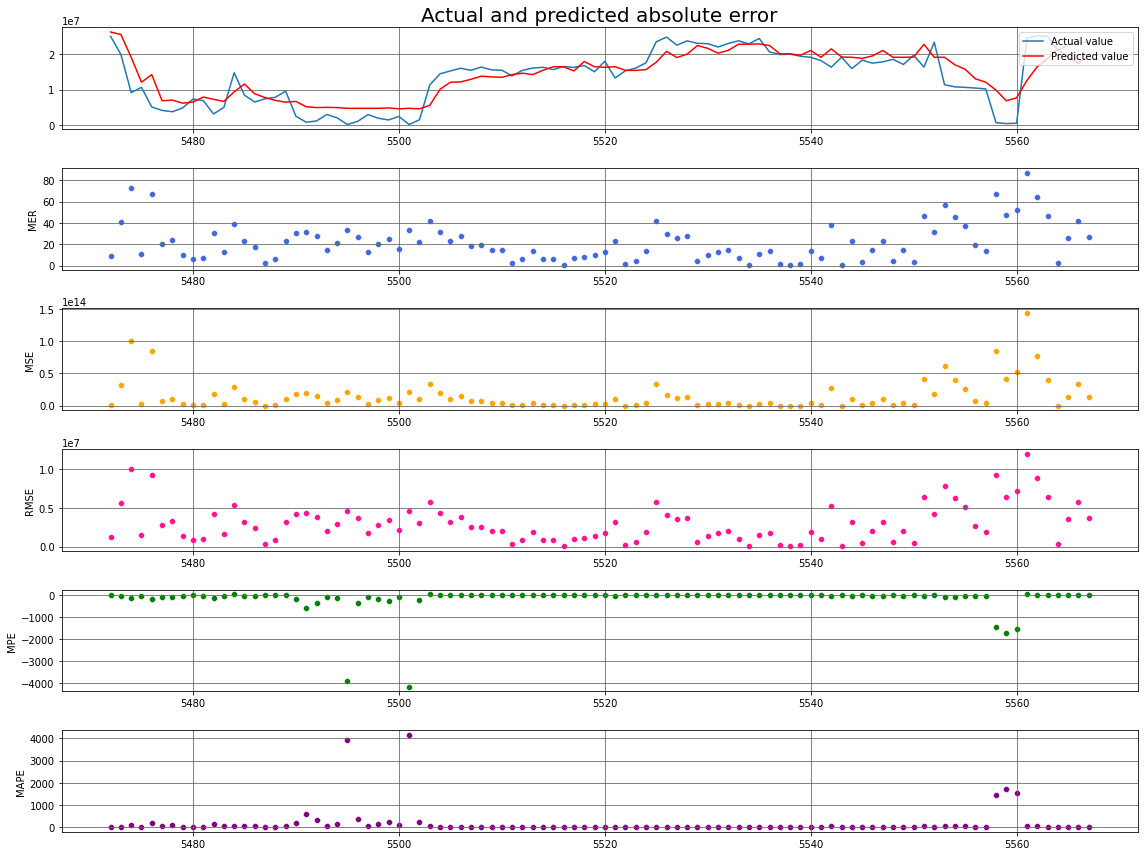

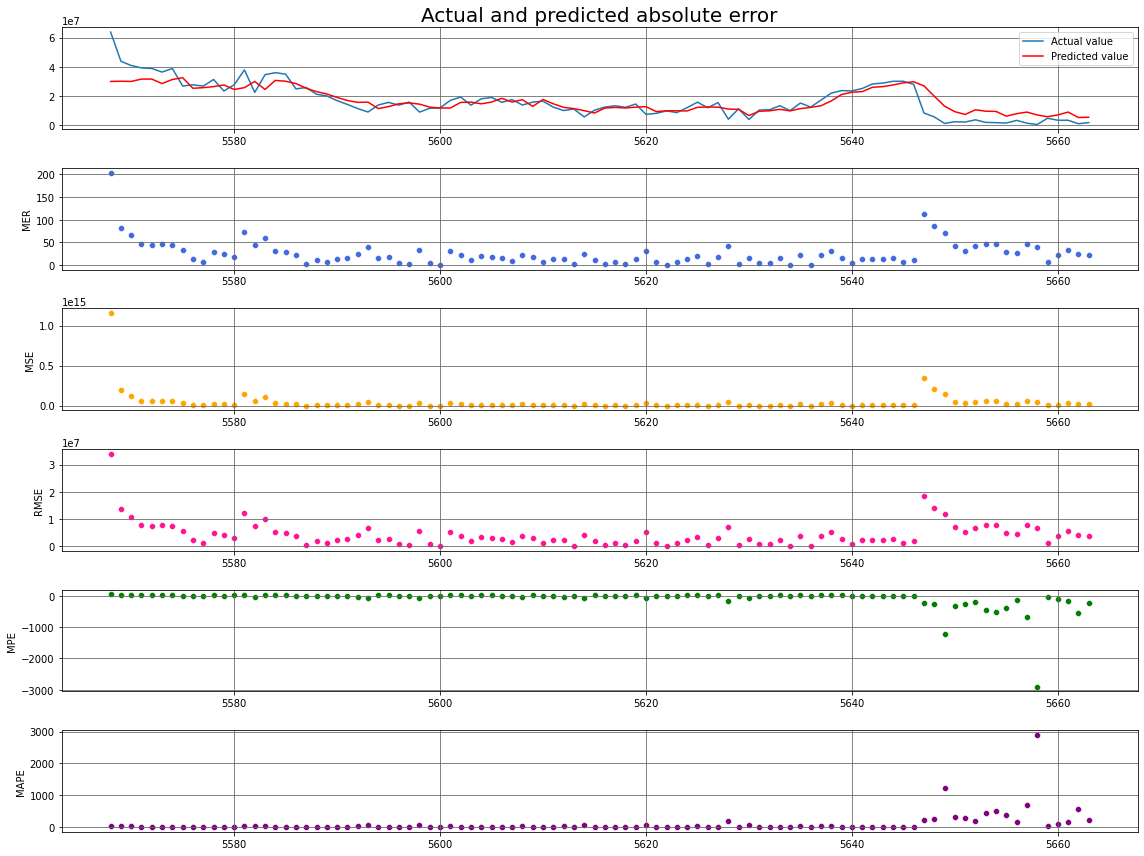

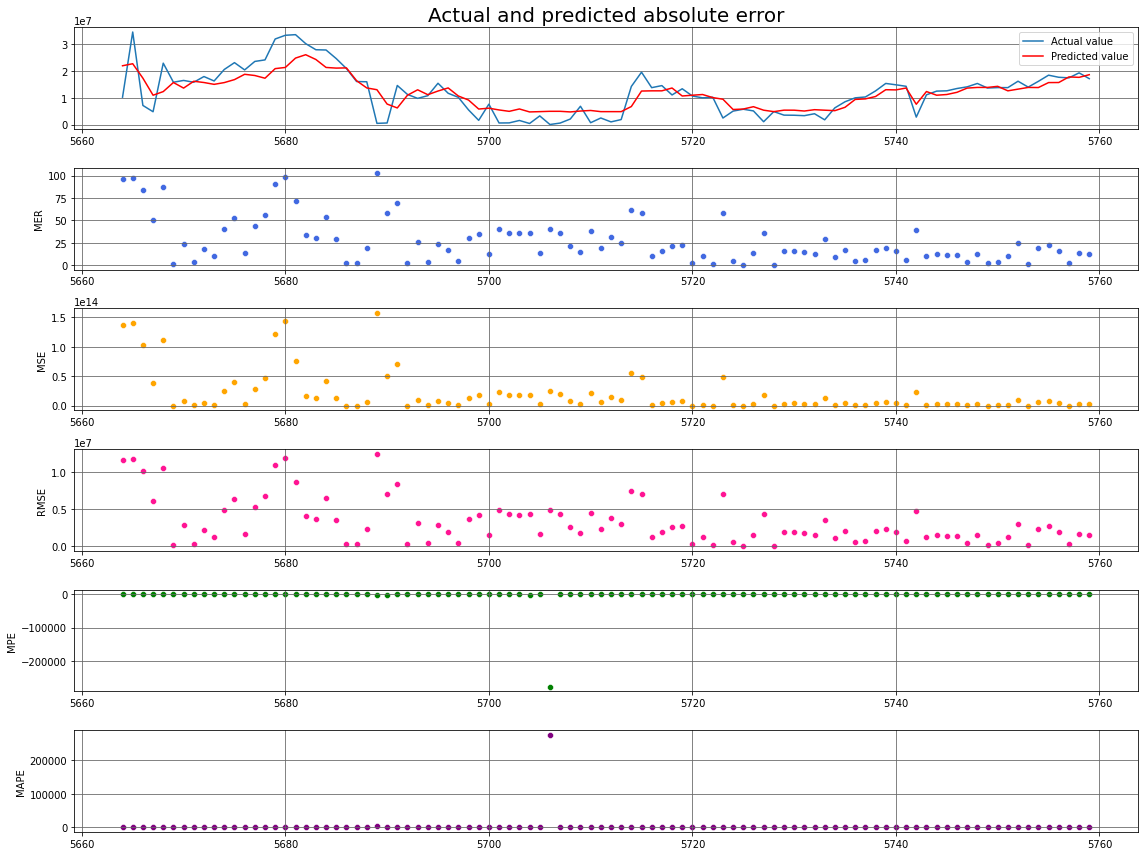

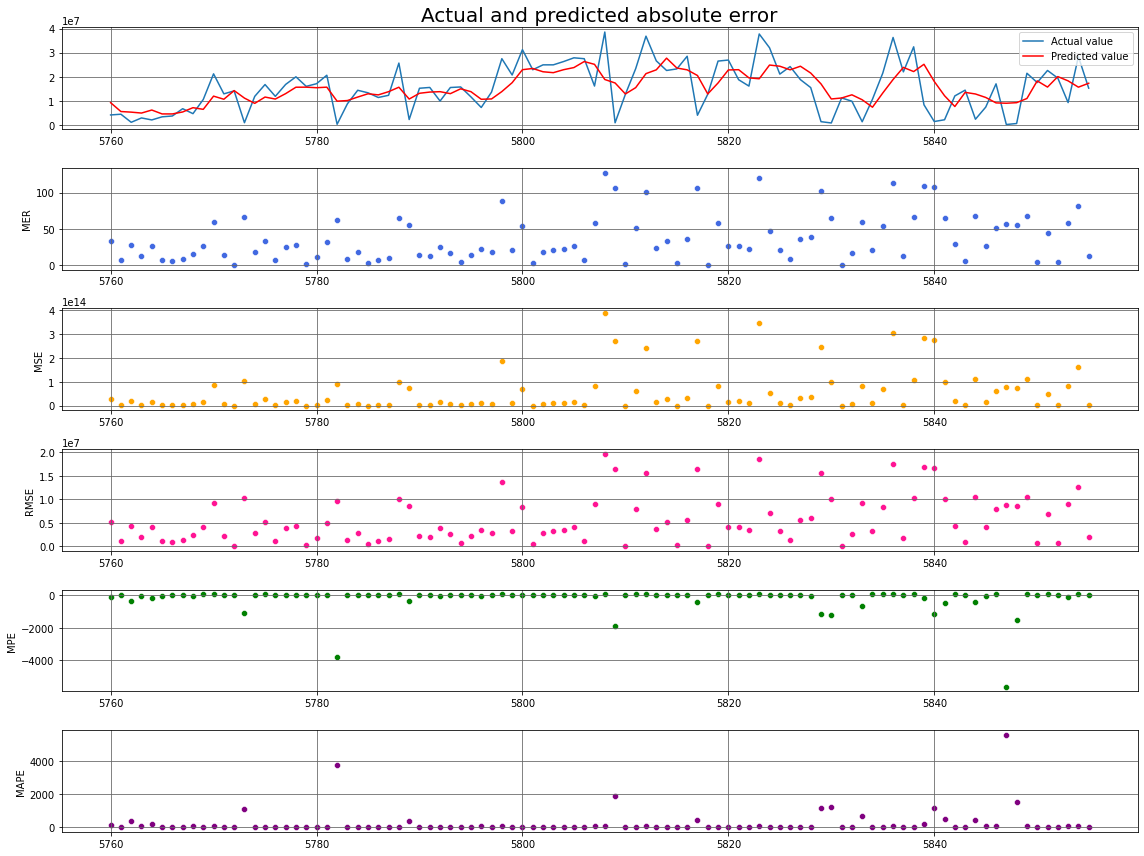

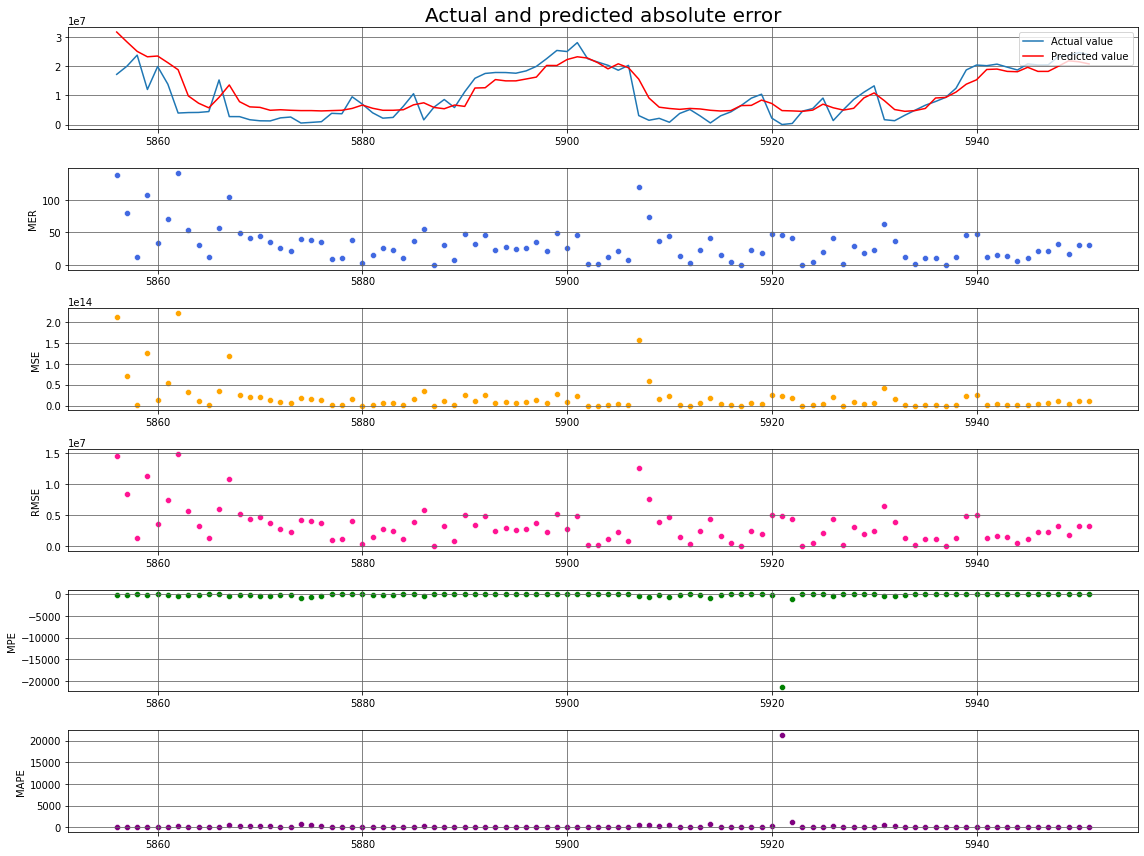

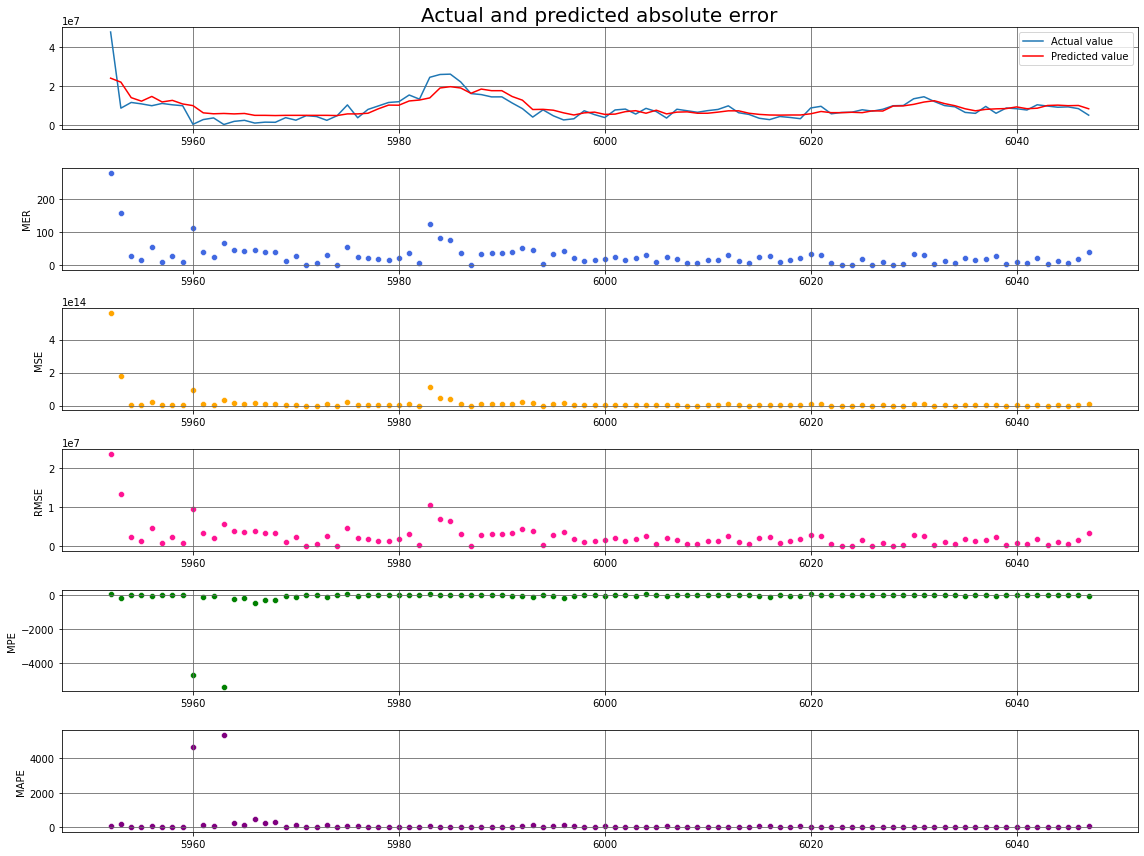

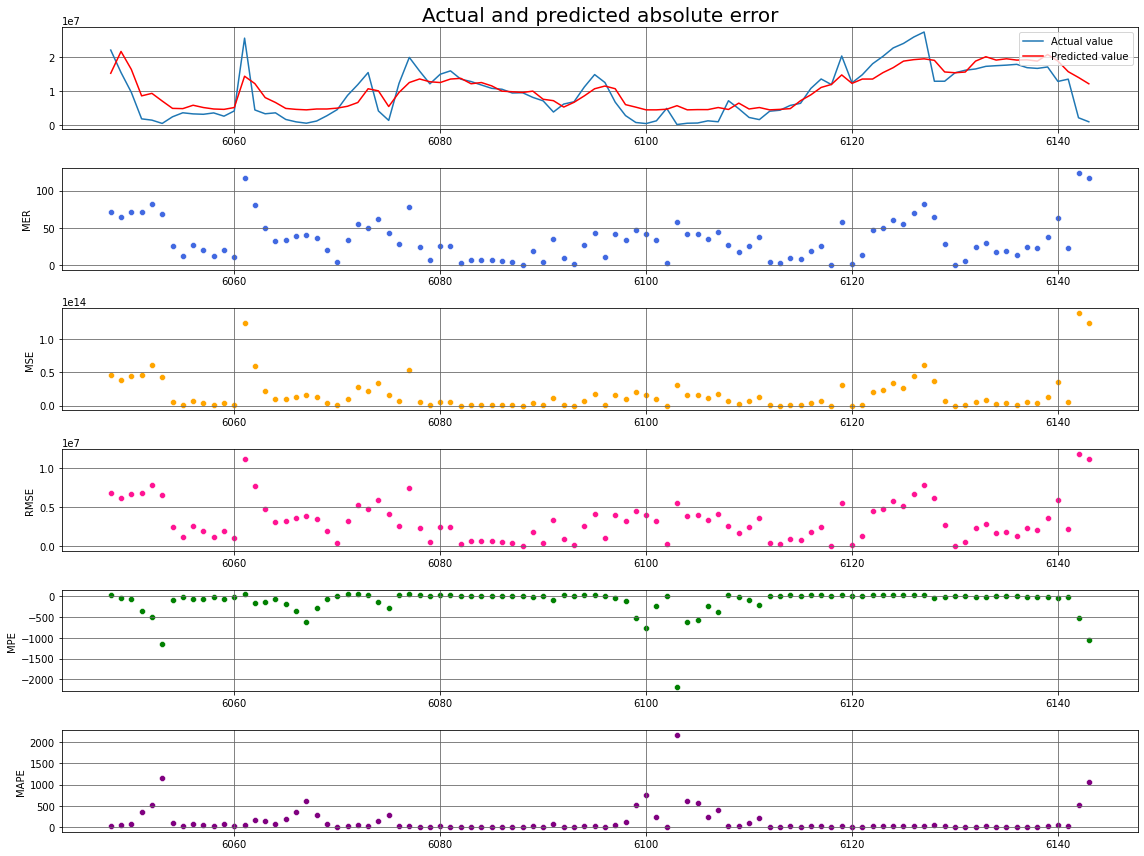

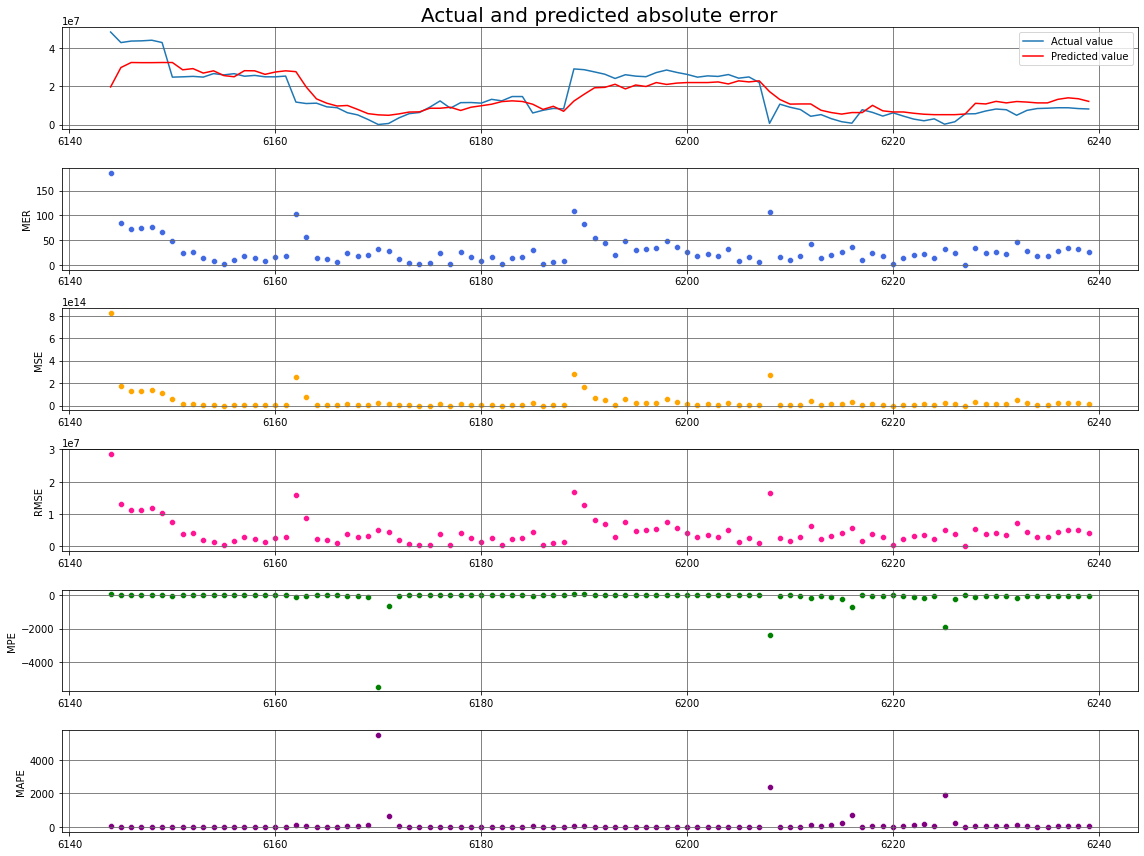

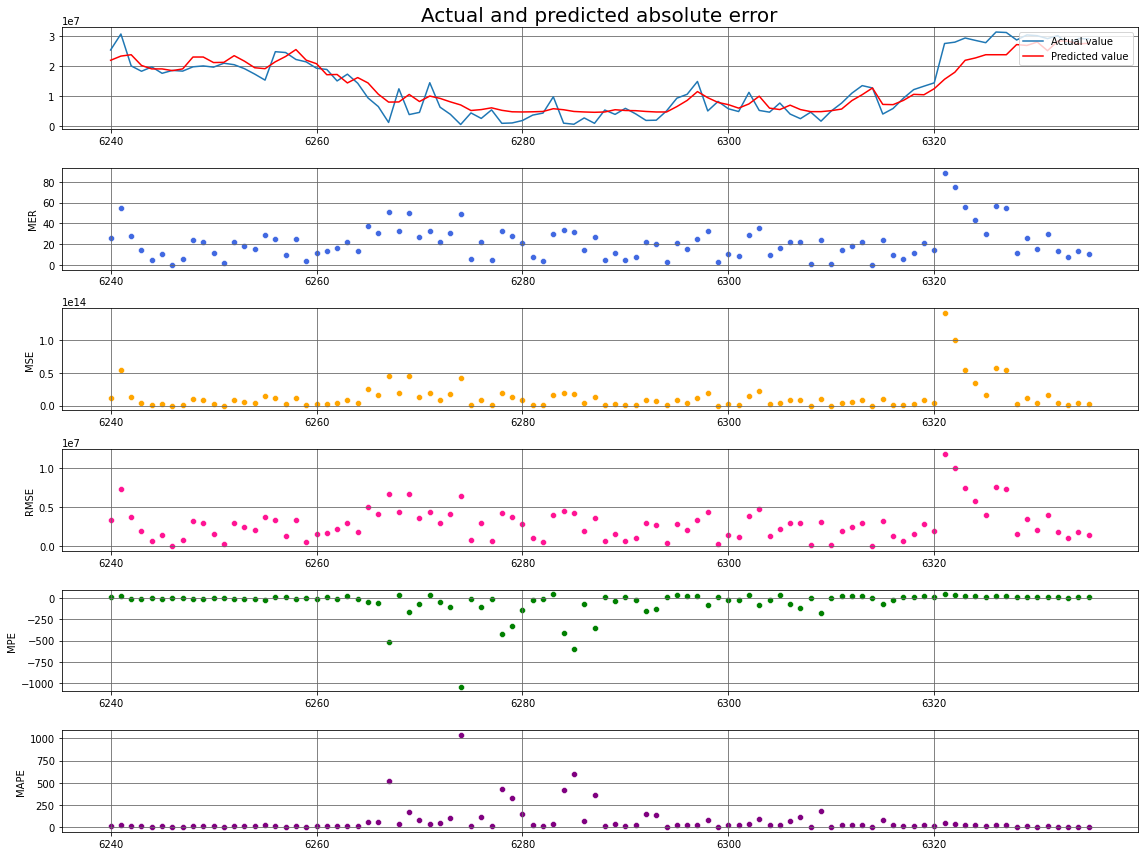

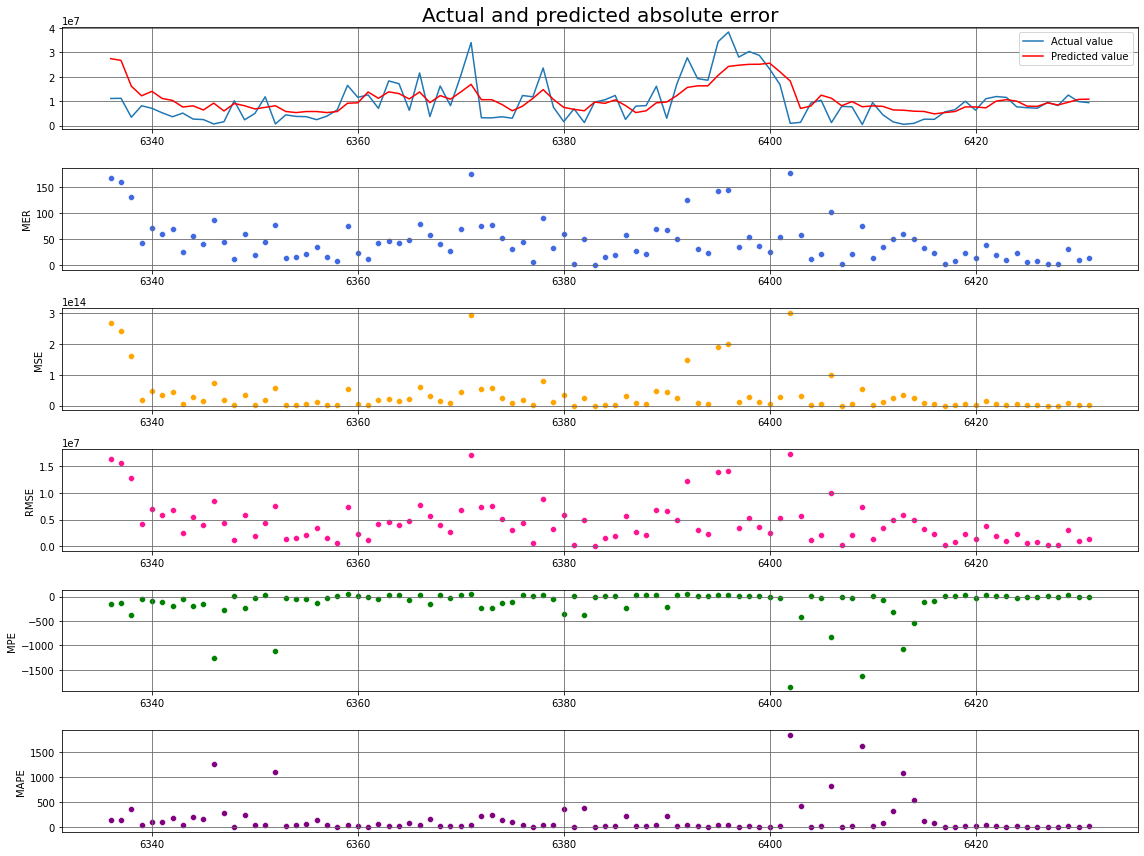

In [77]:
#Visualization
df3=df2
#[(df2['time'] >= '2019-05-25 00:00:00') & (df2['time'] <= '2019-05-25 23:45:00')]
from enum import auto
#df2=df2.set_index('time')
#merged=merged.reset_index()
for date, d in df3.groupby(df3['Dates']):
  fig, axes = plt.subplots(nrows=6, ncols=1,figsize=(16,12))
  ax1 = d['y_test'].plot(legend=True,linestyle = '-',label='Actual value',ax=axes[0])
  ax1 = d['y_preds'].plot(color='red',legend=True,style='-',label='Predicted value',ax=axes[0])
  ax1.legend(loc='upper right')
  ax1.set_title('Actual and predicted absolute error',  fontsize=20)
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  #ax2=sns.scatterplot(data=d,x = d.index,y=d['Absolute error'],ax=axes[2], color='crimson')
  ax2=sns.scatterplot(data=d,x = d.index,y=d['MPE'],ax=axes[4], color='green')
  ax3=sns.scatterplot(data=d,x = d.index,y=d['MAPE'],ax=axes[5], color='purple')
  ax4=sns.scatterplot(data=d,x = d.index,y=d['MSE'],ax=axes[2], color='orange')
  ax5=sns.scatterplot(data=d,x = d.index,y=d['RMSE'],ax=axes[3], color='deeppink')
  ax6=sns.scatterplot(data=d,x = d.index,y=d['MER'],ax=axes[1], color='royalblue')
  ax1.legend(loc='upper right')
  ax2.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax3.grid(b=True, which='major', color='#666666', linestyle='-')
  ax4.grid(b=True, which='major', color='#666666', linestyle='-')
  ax5.grid(b=True, which='major', color='#666666', linestyle='-')
  ax6.grid(b=True, which='major', color='#666666', linestyle='-')
  ax2.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax3.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax4.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax5.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax6.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  plt.tight_layout()
  plt.xlim=auto
  plt.ylim=auto
  ax1.xlim=auto
  ax2.ylim=auto


## **From hier is Appendx**

In [141]:

df2 = merged[(merged['time'] > "2019-12-23 06:00:00") & (merged['time'] < "2019-12-23 09:45:00")]
df2[['time','d_abs','y_preds','Relative_error']].sort_values(by=['Relative_error'],ascending=False)

time      d_abs    y_preds  Relative_error
34212 2019-12-23 09:00:00    10803.7 13211360.4        122186.0
34208 2019-12-23 08:00:00   523695.5 13763329.7          2528.1
34207 2019-12-23 07:45:00  1033533.3 14232021.7          1277.0
34202 2019-12-23 06:30:00  1058652.2 14324178.9          1253.1
34204 2019-12-23 07:00:00  4134301.5 14530718.6           251.5
34214 2019-12-23 09:30:00  5165630.4 13284862.1           157.2
34211 2019-12-23 08:45:00  5585485.0 13911851.4           149.1
34201 2019-12-23 06:15:00  6319543.6 14168104.8           124.2
34213 2019-12-23 09:15:00  7415245.3 13097392.4            76.6
34209 2019-12-23 08:15:00  7915636.1 13377219.2            69.0
34206 2019-12-23 07:30:00  8644741.5 13929716.6            61.1
34203 2019-12-23 06:45:00 11213191.1 14635538.8            30.5
34210 2019-12-23 08:30:00 10624017.7 13568242.0            27.7
34205 2019-12-23 07:15:00 17423937.2 13693280.2            21.4

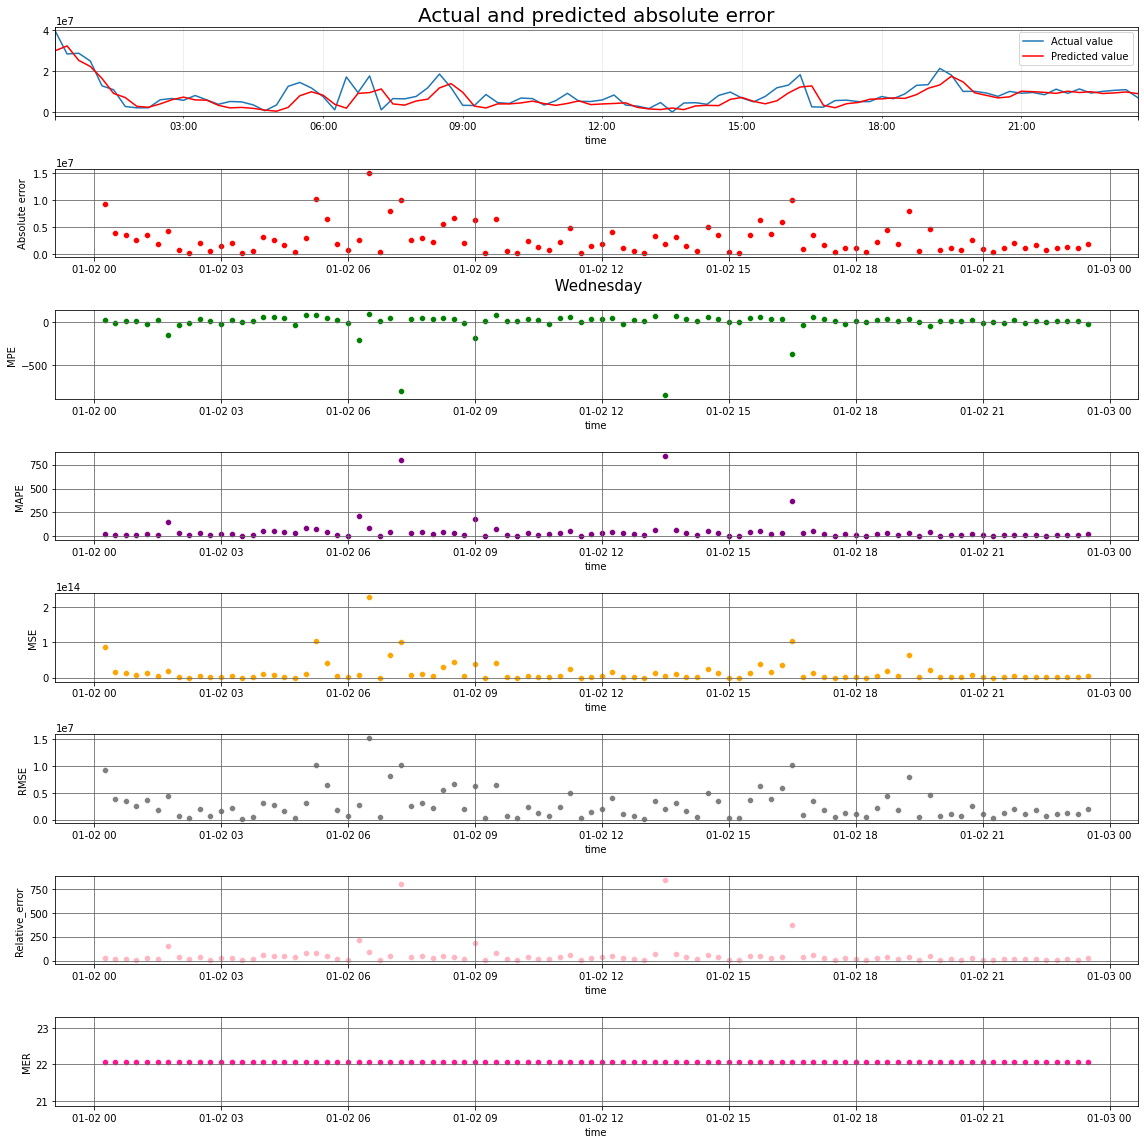

In [137]:
#merged[merged.time>='2019-12-23 00:00:00' and merged.time<='2019-12-23 23:59:00']
df2 = merged[(merged['time'] > "2019-01-02 00:00:00") & (merged['time'] < "2019-01-02 23:45:00")]
#Visualization
from enum import auto
df2=df2.set_index('time')
#merged=merged.reset_index()
for date, d in df2.groupby(df2['Dates']):
  fig, axes = plt.subplots(nrows=8, ncols=1,figsize=(16,16))
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Actual value',ax=axes[0])
  ax1 = d['y_preds'].plot(color='red',legend=True,style='-',label='Predicted value',ax=axes[0])
  ax1.legend(loc='upper right')
  ax1.set_title('Actual and predicted absolute error',  fontsize=20)
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax2=sns.scatterplot(data=d,x = d.index,y=d['Absolute error'],ax=axes[1], color='red')
  ax3=sns.scatterplot(data=d,x = d.index,y=d['MPE'],ax=axes[2], color='green')
  ax4=sns.scatterplot(data=d,x = d.index,y=d['MAPE'],ax=axes[3], color='purple')
  ax5=sns.scatterplot(data=d,x = d.index,y=d['MSE'],ax=axes[4], color='orange')
  ax6=sns.scatterplot(data=d,x = d.index,y=d['RMSE'],ax=axes[5], color='grey')
  ax7=sns.scatterplot(data=d,x = d.index,y=d['Relative_error'],ax=axes[6], color='lightpink')
  ax8=sns.scatterplot(data=d,x = d.index,y=d['MER'],ax=axes[7], color='deeppink')
  #ax2.set_ylabel('Absolute error')
  #ax2.set_title('Absolute error for each datapoint in a day ',  fontsize=20)
  ax2.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax2.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  ax2.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax3.grid(b=True, which='major', color='#666666', linestyle='-')
  ax4.grid(b=True, which='major', color='#666666', linestyle='-')
  ax5.grid(b=True, which='major', color='#666666', linestyle='-')
  ax6.grid(b=True, which='major', color='#666666', linestyle='-')
  ax7.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax8.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax2.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax3.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax4.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax5.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax6.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax7.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax8.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  plt.tight_layout()
  plt.xlim=auto
  plt.ylim=auto
  ax1.xlim=auto
  ax2.ylim=auto


In [ ]:
#merged.relative_error.between(-10, 61921, inclusive=False)
df = merged[merged['relative_error'].between(17, 76799)]
df[['d_abs','y_preds','relative_error','diff']].sort_values(by=['relative_error'],ascending=False)

In [ ]:
#merged.relative_error.between(-10, 61921, inclusive=False)
df = merged[merged['relative_error'].between(17, 76799)]
df1=df[['d_abs','y_preds','relative_error','diff','Day']].sort_values(by=['relative_error'],ascending=False)
df1.head()

In [ ]:
#merged.relative_error.between(-10, 61921, inclusive=False)
df = merged[merged['relative_error'].between(17, 76799)]
df1=df[['d_abs','y_preds','relative_error','diff','Day']].groupby(['relative_error','Day'])
df1.head()

In [ ]:
#Visualization
from enum import auto
#merged=merged.set_index('time')
for date, d in merged.groupby(merged['Dates']):
  df_new= d[['relative_error','d_abs','y_preds']].sort_values(by=['relative_error'],ascending=False)
  print(df_new.head())
